## Imports

In [347]:
import numpy as np
import uproot
import vector
import awkward as ak
import matplotlib.pyplot as plt
import mplhep as hep
import torch
from numpy.random import seed
seed_value = 420 
seed(seed_value)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,f1_score,classification_report,roc_auc_score,roc_curve,recall_score, average_precision_score
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as Data
from sklearn.metrics import roc_curve
import itertools
from sklearn.inspection import permutation_importance
import boost_histogram as bh
from sklearn.model_selection import KFold

#directory = "/Users/archiebrooks/Documents/Uni/mphys project/"
directory = "c:/Users/matis/OneDrive/Documents/Y4/Project/"

hep.style.use('ATLAS')

## Functions

In [355]:
def histogram(data, bins, data_label, axes, density=False, ratio=False, ratio_axes=None, set_range = None, weight_array=None, x_units='GeV', print_peak=False):
    if len(data[0]) != 1:
        if set_range is not None:
            global_min, global_max = set_range
        else:
            global_min = min([np.min(d) for d in data])
            global_max = max([np.max(d) for d in data])

        bin_edges = np.linspace(global_min, global_max, bins+1)
        counts = []
        errors = []
        bin_width = bin_edges[1]-bin_edges[0]
        for i in range(len(data)):
            if type(data[i])!= 'numpy.ndarray':
                data[i] = np.array(ak.to_numpy(data[i]))
            hist = bh.Histogram(bh.axis.Regular(bins, global_min, global_max))
            hist.fill(data[i], weight=weight_array[i]) if weight_array is not None else hist.fill(data[i])
            norm_factor = np.sum(hist.counts() * np.diff(hist.axes[0].edges))
            if density: hep.histplot(hist.counts()/norm_factor, hist.axes[0].edges, ax=axes, yerr=np.sqrt(hist.variances())/norm_factor,label=data_label[i], histtype='step')
            else: hep.histplot(hist.counts(), hist.axes[0].edges, ax=axes, yerr=np.sqrt(hist.variances()),label=data_label[i], histtype='step')
            counts.append(hist.counts()/norm_factor) if density else counts.append(hist.counts())
            errors.append(np.sqrt(hist.variances())/norm_factor) if density else errors.append(np.sqrt(hist.variances()))       
            if print_peak:
                peak_bin_index = np.argmax(hist.counts())
                peak_bin_center = (hist.axes[0].edges[peak_bin_index] + hist.axes[0].edges[peak_bin_index + 1]) / 2
                print(f"Peak bin center for {data_label[i]}: {peak_bin_center:.2f} {x_units}")
    else:
        hist = bh.Histogram(bh.axis.Regular(bins, global_min, global_max))
        hist.fill(data)
        hep.histplot(hist.view(), hist.axes[0].edges, ax=axes, yerr=np.sqrt(hist.variances()), label=data_label, histtype='step')
        if print_peak:
                peak_bin_index = np.argmax(hist.counts())
                peak_bin_center = (hist.axes[0].edges[peak_bin_index] + hist.axes[0].edges[peak_bin_index + 1]) / 2
                print(f"Peak bin center for {data_label}: {peak_bin_center:.2f} {x_units}")

    bin_width = hist.axes[0].edges[1]-hist.axes[0].edges[0]
    axes.set_ylabel(f'Events /{bin_width:.2g} {x_units}')
    axes.legend()

    if ratio:
        reference_counts = counts[0]
        for i in range(1, len(counts)):
            ratio_values = np.divide(counts[i], reference_counts, out=np.zeros_like(counts[i]), where=reference_counts != 0)
            ratio_errors = np.sqrt(np.divide(errors[i],counts[i], out=np.zeros_like(counts[i]), where=counts[i]!=0)**2 + (np.divide(errors[0],counts[0], out=np.zeros_like(counts[0]), where=counts[0]!=0)**2))
            hep.histplot(ratio_values, bin_edges, ax=ratio_axes, yerr=ratio_errors, label=f'{data_label[i]}/{data_label[0]}')
        ratio_axes.set_ylabel("Ratio")
        ratio_axes.set_xlabel(axes.get_xlabel())
        ratio_axes.axhline(1, color='black', linestyle='--')  # Reference line at ratio=1
        ratio_axes.legend()
        if ratio_axes.get_ylim()[1]>5:
            ratio_axes.set_ylim(0,5)

    hep.atlas.label(ax=axes)

def n_combinations(particles, n, dictionary, type):
    i = n
    while len(particles[ak.num(particles)>=i])!=0:
        particles_i = particles[ak.num(particles)==i]
        if len(particles_i)==0:
            i+=1
            continue
        indices = np.array(list(itertools.combinations(range(np.shape(particles_i)[1]), n)))
        dictionary[type+f'_{i}'] = particles_i[:, indices]
        i += 1
    return None

def duplicate_cleaner(matched_pairs):
    truth_ids = matched_pairs['truth']['ids']
    deduped_id_pairs = ak.Array([list(dict.fromkeys(row)) for row in ak.to_list(truth_ids)])
    no_repeats = ak.num(deduped_id_pairs) == ak.num(truth_ids)
    one_repeat = ak.num(deduped_id_pairs) == ak.num(truth_ids) - 1

    duplicate_pairs = matched_pairs[one_repeat]

    clean_pairs = matched_pairs[no_repeats]
    return clean_pairs, duplicate_pairs

j = 0
def duplicate_matcher(matched, i):
    repeat_ids = ak.unflatten(ak.ravel(ak.Array(matched['truth']['id'])),ak.num(ak.Array(matched['truth']['id'])))
    repeat_i = ak.num(repeat_ids[repeat_ids==i], axis=1)==2

    truth_i = matched['truth']['truth'][repeat_i]
    id_pairs_i = matched['truth']['id'][repeat_i]

    valid_id_particles = id_pairs_i[id_pairs_i['id']!=i]
    valid_id_particles = valid_id_particles[ak.num(valid_id_particles, axis=2)!=0]

    repeat_recos = id_pairs_i[id_pairs_i['id']==i]
    repeat_recos = repeat_recos[ak.num(repeat_recos, axis=2)!=0]

    duplicate_deltars = ak.unflatten(ak.ravel(repeat_recos['reco'].deltaR(truth_i[:,i-1])),2)
    min_dupdeltars = ak.unflatten(ak.min(duplicate_deltars, axis=1),1)

    matched_recos = repeat_recos[duplicate_deltars==min_dupdeltars]
    unmatched_recos = ak.unflatten(ak.ravel(repeat_recos['reco'][duplicate_deltars!=min_dupdeltars]),1)

    valid_id_particles = ak.concatenate((valid_id_particles, matched_recos), axis=1)
    possible_truth = ak.concatenate((truth_i[:,0:i-1],truth_i[:,i:len(matched['truth']['truth'][0])]), axis=1)

    id = np.tile(np.hstack((np.arange(1,i),np.arange(i+1,len(possible_truth[0])+2))), (len(possible_truth),1))
    pairs_2d = ak.cartesian({'reco':unmatched_recos,'truth':possible_truth})
    id_pairs_2d = ak.cartesian({'reco':unmatched_recos,'id':id})
    pairs_3d = ak.unflatten(pairs_2d, len(possible_truth[0]), axis=1)
    id_pairs_3d = ak.unflatten(id_pairs_2d, len(possible_truth[0]), axis=1)

    deltars = ak.unflatten(ak.ravel(pairs_3d['reco'].deltaR(pairs_3d['truth'])),len(truth[0])-1)
    min_deltars = ak.unflatten(np.min(deltars, axis=1),1)

    id_pairs_3d = id_pairs_3d[ak.unflatten(deltars == min_deltars,1)]
    id_pairs_3d = id_pairs_3d[min_deltars<0.4]
    add_match = valid_id_particles[ak.num(id_pairs_3d)!=0]

    valid_id_events = valid_id_particles[ak.num(id_pairs_3d)==0]
    pairs_to_concatenate = [valid_id_events]

    id_pairs_3d = id_pairs_3d[ak.num(id_pairs_3d)!=0]
    additional_matches = ak.concatenate((id_pairs_3d, add_match), axis=1)

    reshaped_ids = ak.unflatten(ak.ravel(ak.Array(additional_matches['id'])),ak.num(ak.Array(additional_matches['id'])))
    deduped_id_pairs = ak.Array([list(dict.fromkeys(row)) for row in ak.to_list(reshaped_ids)])
    if len(reshaped_ids) != 0:
        has_repeats = ak.num(deduped_id_pairs) != ak.num(reshaped_ids)
        pairs_to_concatenate.append(id_pairs_3d[has_repeats])
        print(len(id_pairs_3d[~has_repeats]))
        pairs_to_concatenate.append(additional_matches[~has_repeats])
    else:
        pairs_to_concatenate.append(id_pairs_3d)
    
    clean_id_pairs = ak.concatenate(pairs_to_concatenate)
    repeat_ids = ak.unflatten(ak.ravel(id_pairs['id']),ak.num(id_pairs['id']))
    return clean_id_pairs

def duplicate_cleaner(matched_pairs):
    truth_ids = matched_pairs['truth']['id']
    deduped_id_pairs = ak.Array([list(dict.fromkeys(row)) for row in ak.to_list(truth_ids)])
    no_repeats = ak.num(deduped_id_pairs) == ak.num(truth_ids)
    one_repeat = ak.num(deduped_id_pairs) == ak.num(truth_ids) - 1

    duplicate_pairs = matched_pairs[one_repeat]

    clean_pairs = matched_pairs[no_repeats]
    return clean_pairs, duplicate_pairs

def truth_matching(truth, truth_id, reco_jets, reco_leptons):
    id = np.tile(np.arange(1,len(truth[0])+1), (len(truth),1))

    indexed_truth = ak.zip({'truth': truth, 'id': id})
    truth_jets = indexed_truth[truth_id < 10]
    truth_leptons = indexed_truth[(truth_id > 10)&(truth_id<20)]

    jets_3d = ak.cartesian({'reco':reco_jets, 'truth': truth_jets}, axis=1, nested=True)

    deltars = jets_3d['reco'].deltaR(jets_3d['truth']['truth'])
    min_deltars = ak.min(deltars,axis=2)

    matched_jets = ak.flatten(jets_3d[(deltars==min_deltars)&(min_deltars<0.4)], axis=2)


    leptons_3d = ak.cartesian({'truth': truth_leptons, 'reco':reco_leptons}, axis=1, nested=True)

    deltars = leptons_3d['reco'].deltaR(leptons_3d['truth']['truth'])
    min_deltars = ak.min(deltars,axis=2)

    matched_leptons = ak.flatten(leptons_3d[(deltars==min_deltars)&(min_deltars<0.4)], axis=2)

    matched = ak.concatenate((matched_jets, matched_leptons), axis=1)

    matched_pairs, repeat_pairs = duplicate_cleaner(matched)


    fully_matched = matched_pairs[ak.num(matched_pairs)==len(truth[0])]

    truth_test = truth[ak.num(matched_pairs)==len(truth[0])]
    fully_matched_bool = ak.num(matched_pairs)==len(truth[0])

    return fully_matched, truth_test, fully_matched_bool

class Classifier_MLP(nn.Module):
    def __init__(self, in_dim, hidden_dim1, hidden_dim2, dropout_rate, out_dim):
        super().__init__()
        self.h1 = nn.Linear(in_dim, hidden_dim1)
        self.h2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.h3 = nn.Dropout(dropout_rate)
        self.out = nn.Linear(hidden_dim2, out_dim)
        self.out_dim = out_dim        

    def forward(self, x):
        x = F.relu(self.h1(x))
        x = F.relu(self.h2(x))
        x = self.h3(x)
        x = self.out(x)
        return x, F.softmax(x,dim=1)

    def fit(self, train_loader, valid_loader, optimiser, verbose=True):
        _results = []  # Store training and validation metrics
        for epoch in range(epochs):
            # Training loop
            self.train()  # Set the model to training mode
            with torch.enable_grad():
                train_loss = 0.0
                for batch, (x_train_batch, y_train_batch) in enumerate(train_loader):
                    self.zero_grad()  # Zero gradients
                    out, prob = self(x_train_batch)  # Forward pass
                    loss = F.cross_entropy(out, y_train_batch)  # Compute loss
                    loss.backward()  # Backpropagation
                    optimiser.step()  # Update weights
                    train_loss += loss.item() * x_train_batch.size(0)

            train_loss /= len(train_loader.dataset)  # Average training loss

            if verbose:
                print("Epoch: {}, Train Loss: {:4f}".format(epoch+1, train_loss))

            # Validation loop
            self.eval()  # Set the model to evaluation mode
            with torch.no_grad():
                correct = 0
                valid_loss = 0.0

                for i, (x_valid_batch, y_valid_batch) in enumerate(valid_loader):
                    out, prob = self(x_valid_batch)  # Forward pass
                    loss = F.cross_entropy(out, y_valid_batch)  # Compute loss
                    valid_loss += loss.item() * x_valid_batch.size(0)
                    preds = prob.argmax(dim=1, keepdim=True)  # Get predictions
                    correct += preds.eq(y_valid_batch.view_as(preds)).sum().item()  # Count correct

                valid_loss /= len(valid_loader.dataset)  # Average validation loss
                accuracy = correct / len(valid_loader.dataset)  # Calculate accuracy

            if verbose:
                print("Validation Loss: {:4f}, Validation Accuracy: {:4f}".format(valid_loss, accuracy))

            # Store results
            _results.append([epoch, train_loss, valid_loss, accuracy])

        results = np.array(_results)  # Make array of results
        print("Finished Training")
        print("Final validation error: ", 100.0 * (1 - accuracy), "%")

    def score(self,X_test_tensor,y_test_tensor):
        self.eval()
        with torch.no_grad():
            if isinstance(X_test_tensor, np.ndarray) or isinstance(y_test_tensor, np.ndarray):
                if isinstance(X_test_tensor, np.ndarray):
                    X_test_tensor = torch.from_numpy(X_test_tensor).float()
                if isinstance(y_test_tensor, np.ndarray):
                    y_test_tensor = torch.from_numpy(y_test_tensor).long()
                out, prob = self(X_test_tensor)
                y_pred_NN_partonic = (prob.cpu().detach().numpy().argmax(axis=1))
                return accuracy_score(y_test_tensor,y_pred_NN_partonic)
    

def AMS(TPR,FPR,b_r):
    AMS = np.sqrt(2*(TPR+FPR+b_r)*np.log(1+TPR/(FPR+b_r))-TPR)
    return AMS
b_reg = 0.001

def compare_train_test(clf, X_train, y_train, X_test, y_test, xlabel):
    decisions = [] # list to hold decisions of classifier
    for X,y in ((X_train, y_train), (X_test, y_test)): # train and test
        if hasattr(clf, "predict_proba"): # if predict_proba function exists
            d1 = clf.predict_proba(X[y<0.5])[:, 1] # background
            d2 = clf.predict_proba(X[y>0.5])[:, 1] # signal
        else: # predict_proba function doesn't exist
            X_tensor = torch.as_tensor(X, dtype=torch.float) # make tensor from X_test_scaled
            y_tensor = torch.as_tensor(y, dtype=torch.long) # make tensor from y_test
            X_var, y_var = Variable(X_tensor), Variable(y_tensor) # make variables from tensors
            d1 = clf(X_var[y_var<0.5])[1][:, 1].cpu().detach().numpy() # background
            d2 = clf(X_var[y_var>0.5])[1][:, 1].cpu().detach().numpy() # signal
        decisions += [d1, d2] # add to list of classifier decision
    
    highest_decision = max(np.max(d) for d in decisions) # get maximum score
    bin_edges = [] # list to hold bin edges
    bin_edge = -0.1 # start counter for bin_edges
    while bin_edge < highest_decision: # up to highest score
        bin_edge += 0.1 # increment
        bin_edges.append(bin_edge)
    
    ax[1,1].hist(decisions[0], # background in train set
             bins=bin_edges, # lower and upper range of the bins
             density=True, # area under the histogram will sum to 1
             histtype='stepfilled', # lineplot that's filled
             color='blue', label='Background (train)', # Background (train)
            alpha=0.5 ) # half transparency
    ax[1,1].hist(decisions[1], # background in train set
             bins=bin_edges, # lower and upper range of the bins
             density=True, # area under the histogram will sum to 1
             histtype='stepfilled', # lineplot that's filled
             color='orange', label='Signal (train)', # Signal (train)
            alpha=0.5 ) # half transparency

    hist_background, bin_edges = np.histogram(decisions[2], # background test
                                              bins=bin_edges, # number of bins in function definition
                                              density=True ) # area under the histogram will sum to 1
    
    scale = len(decisions[2]) / sum(hist_background) # between raw and normalised
    err_background = np.sqrt(hist_background * scale) / scale # error on test background

    width = 0.1 # histogram bin width
    center = (bin_edges[:-1] + bin_edges[1:]) / 2 # bin centres
    
    ax[1,1].errorbar(x=center, y=hist_background, yerr=err_background, fmt='o', # circles
                 c='blue', label='Background (test)' ) # Background (test)
    
    hist_signal, bin_edges = np.histogram(decisions[3], # siganl test
                                          bins=bin_edges, # number of bins in function definition
                                          density=True ) # area under the histogram will sum to 1
    scale = len(decisions[3]) / sum(hist_signal) # between raw and normalised
    err_signal = np.sqrt(hist_signal * scale) / scale # error on test background
    
    ax[1,1].errorbar(x=center, y=hist_signal, yerr=err_signal, fmt='o', # circles
                 c='orange', label='Signal (test)' ) # Signal (test)
    
    ax[1,1].set_xlabel(xlabel) # write x-axis label
    ax[1,1].set_ylabel("Arbitrary units") # write y-axis label
    ax[1,1].legend() # add legend

## Extracting Data

### 4 Top Matching

In [349]:
tree4 = uproot.open(directory + "4tops_skimmed_14nov.root")
tree4_truth = tree4['Truth;1']
tree4_reco = tree4['Reco;1']

events_4t_truth = tree4_truth.arrays(['b_id', 'b_pt', 'b_eta', 'b_phi', 'b_e', 'b_mass', 'W_decay_id', 'W_decay_pt', 'W_decay_eta', 'W_decay_phi', 'W_decay_e', 'W_decay_mass'])
events_4t_partonic = tree4_truth.arrays(['top_pt', 'top_eta', 'top_phi', 'top_e', 'top_mass', 'top_id', 'W_pt', 'W_eta', 'W_phi', 'W_e', 'W_mass', 'W_id'])
events_4t_reco = tree4_reco.arrays(['jet_pt', 'jet_eta', 'jet_phi', 'jet_mass', 'jet_btag', 'el_pt', 'el_eta', 'el_phi', 'el_charge', 'mu_pt', 'mu_eta', 'mu_phi', 'mu_charge', 'met_met', 'met_eta', 'met_phi'])
events_4t_reco['el_mass'] = 0.511e-3 * np.ones_like(events_4t_reco['el_pt'])
events_4t_reco['mu_mass'] = 0.1057 * np.ones_like(events_4t_reco['mu_pt'])

In [362]:
tree4 = uproot.open(directory + "4tops_skimmed_14nov.root")
tree4_truth = tree4['Truth;1']
tree4_reco = tree4['Reco;1']

events_4t_truth = tree4_truth.arrays(['b_id', 'b_pt', 'b_eta', 'b_phi', 'b_e', 'b_mass', 'W_decay_id', 'W_decay_pt', 'W_decay_eta', 'W_decay_phi', 'W_decay_e', 'W_decay_mass'])
events_4t_partonic = tree4_truth.arrays(['top_pt', 'top_eta', 'top_phi', 'top_e', 'top_mass', 'top_id', 'W_pt', 'W_eta', 'W_phi', 'W_e', 'W_mass', 'W_id'])
events_4t_reco = tree4_reco.arrays(['jet_pt', 'jet_eta', 'jet_phi', 'jet_mass', 'jet_btag', 'el_pt', 'el_eta', 'el_phi', 'el_charge', 'mu_pt', 'mu_eta', 'mu_phi', 'mu_charge', 'met_met', 'met_eta', 'met_phi'])
events_4t_reco['el_mass'] = 0.511e-3 * np.ones_like(events_4t_reco['el_pt'])
events_4t_reco['mu_mass'] = 0.1057 * np.ones_like(events_4t_reco['mu_pt'])

good_events_4t = ak.num(events_4t_truth['b_id']) == 4

invalid_events_4t_truth = events_4t_truth[~good_events_4t]
invalid_events_4t_truth['b_id'], invalid_events_4t_truth['b_pt'], invalid_events_4t_truth['b_eta'] = invalid_events_4t_truth['b_id'][:,1:], invalid_events_4t_truth['b_pt'][:,1:], invalid_events_4t_truth['b_eta'][:,1:]
invalid_events_4t_truth['b_phi'], invalid_events_4t_truth['b_e'], invalid_events_4t_truth['b_mass'] = invalid_events_4t_truth['b_phi'][:,1:], invalid_events_4t_truth['b_e'][:,1:], invalid_events_4t_truth['b_mass'][:,1:]

events_4t_truth = ak.concatenate((events_4t_truth[good_events_4t], invalid_events_4t_truth))
events_4t_reco = ak.concatenate((events_4t_reco[good_events_4t], events_4t_reco[~good_events_4t]))
events_4t_partonic = ak.concatenate((events_4t_partonic[good_events_4t], events_4t_partonic[~good_events_4t]))

x = events_4t_truth['W_decay_id'][(events_4t_truth['W_decay_id']==15)|(events_4t_truth['W_decay_id']==-15)]
events_4t_reco = events_4t_reco[ak.num(x)==0]
events_4t_partonic = events_4t_partonic[ak.num(x)==0]
events_4t_truth = events_4t_truth[ak.num(x)==0]

neutrino_remover = (abs(events_4t_truth['W_decay_id']) != 12)&(abs(events_4t_truth['W_decay_id']) != 14)&(abs(events_4t_truth['W_decay_id']) != 16)&(abs(events_4t_truth['W_decay_id']) != 18)
events_4t_truth['W_decay_id'] = events_4t_truth['W_decay_id'][neutrino_remover]
events_4t_truth['W_decay_pt'] = events_4t_truth['W_decay_pt'][neutrino_remover]
events_4t_truth['W_decay_eta'] = events_4t_truth['W_decay_eta'][neutrino_remover]
events_4t_truth['W_decay_phi'] = events_4t_truth['W_decay_phi'][neutrino_remover]
events_4t_truth['W_decay_e'] = events_4t_truth['W_decay_e'][neutrino_remover]
events_4t_truth['W_decay_mass'] = events_4t_truth['W_decay_mass'][neutrino_remover]

jet_pt_4t = events_4t_reco['jet_pt'][(events_4t_reco['jet_eta']<2.5) & (events_4t_reco['jet_eta']>-2.5)]
jet_eta_4t = events_4t_reco['jet_eta'][(events_4t_reco['jet_eta']<2.5) & (events_4t_reco['jet_eta']>-2.5)]
jet_phi_4t = events_4t_reco['jet_phi'][(events_4t_reco['jet_eta']<2.5) & (events_4t_reco['jet_eta']>-2.5)]
jet_mass_4t = events_4t_reco['jet_mass'][(events_4t_reco['jet_eta']<2.5) & (events_4t_reco['jet_eta']>-2.5)]

electron_pt_4t = events_4t_reco['el_pt'][(events_4t_reco['el_pt'] > 15) & (events_4t_reco['el_eta'] < 2.47) & (events_4t_reco['el_eta'] > -2.47)]
electron_eta_4t = events_4t_reco['el_eta'][(events_4t_reco['el_pt'] > 15) & (events_4t_reco['el_eta'] < 2.47) & (events_4t_reco['el_eta'] > -2.47)]
electron_phi_4t = events_4t_reco['el_phi'][(events_4t_reco['el_pt'] > 15) & (events_4t_reco['el_eta'] < 2.47) & (events_4t_reco['el_eta'] > -2.47)]
electron_mass_4t = events_4t_reco['el_mass'][(events_4t_reco['el_pt'] > 15) & (events_4t_reco['el_eta'] < 2.47) & (events_4t_reco['el_eta'] > -2.47)]

muon_pt_4t = events_4t_reco['mu_pt'][(events_4t_reco['mu_pt']>15) & (events_4t_reco['mu_eta']<2.5) & (events_4t_reco['mu_eta']>-2.5)]
muon_eta_4t = events_4t_reco['mu_eta'][(events_4t_reco['mu_pt']>15) & (events_4t_reco['mu_eta']<2.5) & (events_4t_reco['mu_eta']>-2.5)]
muon_phi_4t = events_4t_reco['mu_phi'][(events_4t_reco['mu_pt']>15) & (events_4t_reco['mu_eta']<2.5) & (events_4t_reco['mu_eta']>-2.5)]
muon_mass_4t = events_4t_reco['mu_mass'][(events_4t_reco['mu_pt']>15) & (events_4t_reco['mu_eta']<2.5) & (events_4t_reco['mu_eta']>-2.5)]

lepton_pt_4t = ak.concatenate((muon_pt_4t,electron_pt_4t), axis=1)
lepton_eta_4t = ak.concatenate((muon_eta_4t,electron_eta_4t), axis=1)
lepton_phi_4t = ak.concatenate((muon_phi_4t,electron_phi_4t), axis=1)
lepton_mass_4t = ak.concatenate((muon_mass_4t,electron_mass_4t), axis=1)

reco_pt_4t = ak.concatenate((jet_pt_4t,lepton_pt_4t), axis=1)
reco_eta_4t = ak.concatenate((jet_eta_4t,lepton_eta_4t), axis=1)
reco_phi_4t = ak.concatenate((jet_phi_4t,lepton_phi_4t), axis=1)
reco_mass_4t = ak.concatenate((jet_mass_4t,lepton_mass_4t), axis=1)

b_pt_4t = events_4t_truth['b_pt']
b_eta_4t = events_4t_truth['b_eta']
b_phi_4t = events_4t_truth['b_phi']
b_mass_4t = events_4t_truth['b_mass']
b_e_4t = events_4t_truth['b_e']
b_id_4t = events_4t_truth['b_id']

w_decay_pt_4t = events_4t_truth['W_decay_pt']
w_decay_eta_4t = events_4t_truth['W_decay_eta']
w_decay_phi_4t = events_4t_truth['W_decay_phi']
w_decay_mass_4t = events_4t_truth['W_decay_mass']
w_decay_e_4t = events_4t_truth['W_decay_e']
w_decay_id_4t = events_4t_truth['W_decay_id']

truth_pt_4t = ak.concatenate((b_pt_4t,w_decay_pt_4t), axis=1)
truth_eta_4t = ak.concatenate((b_eta_4t,w_decay_eta_4t), axis=1)
truth_phi_4t = ak.concatenate((b_phi_4t,w_decay_phi_4t), axis=1)
truth_mass_4t = ak.concatenate((b_mass_4t,w_decay_mass_4t), axis=1)
truth_e_4t = ak.concatenate((b_e_4t,w_decay_e_4t), axis=1)
truth_id_4t = ak.concatenate((b_id_4t,w_decay_id_4t), axis=1)

reco_4t = vector.zip({'pt':reco_pt_4t,'eta':reco_eta_4t,'phi':reco_phi_4t,'mass':reco_mass_4t})
truth_4t = vector.zip({'pt':truth_pt_4t,'eta':truth_eta_4t,'phi':truth_phi_4t,'mass':truth_mass_4t})

reco_4t_leptons = vector.zip({'pt':lepton_pt_4t,'eta':lepton_eta_4t,'phi':lepton_phi_4t,'mass':lepton_mass_4t})
reco_4t_jets = vector.zip({'pt':jet_pt_4t,'eta':jet_eta_4t,'phi':jet_phi_4t,'mass':jet_mass_4t})

truth_4t = truth_4t[(ak.num(reco_4t)!=0)]
reco_4t = reco_4t[(ak.num(reco_4t)!=0)]
reco_4t_leptons = reco_4t_leptons[(ak.num(reco_4t)!=0)]
reco_4t_jets = reco_4t_jets[(ak.num(reco_4t)!=0)]

In [ ]:
lepton_count_4t = ak.num(events_4t_truth['W_decay_id'][(abs(events_4t_truth['W_decay_id'])>10)&(abs(events_4t_truth['W_decay_id'])<19)])

events_4t_truth_0L = events_4t_truth[lepton_count_4t == 0]
events_4t_truth_1L = events_4t_truth[lepton_count_4t == 1]
events_4t_truth_2L = events_4t_truth[lepton_count_4t == 2]
events_4t_truth_3L = events_4t_truth[lepton_count_4t == 3]
events_4t_truth_4L = events_4t_truth[lepton_count_4t == 4]

truth_4t_0L, truth_id_4t_0L = truth_4t[lepton_count_4t == 0], truth_id_4t[lepton_count_4t == 0]
truth_4t_1L, truth_id_4t_1L = truth_4t[lepton_count_4t == 1], truth_id_4t[lepton_count_4t == 1]
truth_4t_2L, truth_id_4t_2L = truth_4t[lepton_count_4t == 2], truth_id_4t[lepton_count_4t == 2]
truth_4t_3L, truth_id_4t_3L = truth_4t[lepton_count_4t == 3], truth_id_4t[lepton_count_4t == 3]
truth_4t_4L, truth_id_4t_4L = truth_4t[lepton_count_4t == 4], truth_id_4t[lepton_count_4t == 4]

reco_4t_0L = reco_4t[lepton_count_4t == 0]
reco_4t_1L = reco_4t[lepton_count_4t == 1]
reco_4t_2L = reco_4t[lepton_count_4t == 2]
reco_4t_3L = reco_4t[lepton_count_4t == 3]
reco_4t_4L = reco_4t[lepton_count_4t == 4]

reco_4t_leptons_0L = reco_4t_leptons[lepton_count_4t == 0]
reco_4t_leptons_1L = reco_4t_leptons[lepton_count_4t == 1]
reco_4t_leptons_2L = reco_4t_leptons[lepton_count_4t == 2]
reco_4t_leptons_3L = reco_4t_leptons[lepton_count_4t == 3]
reco_4t_leptons_4L = reco_4t_leptons[lepton_count_4t == 4]

reco_4t_jets_0L = reco_4t_jets[lepton_count_4t == 0]
reco_4t_jets_1L = reco_4t_jets[lepton_count_4t == 1]
reco_4t_jets_2L = reco_4t_jets[lepton_count_4t == 2]
reco_4t_jets_3L = reco_4t_jets[lepton_count_4t == 3]

In [ ]:
print(np.argwhere(ak.num(truth_4t_0L)!=12))

[]


In [ ]:
fully_matched_4t_0L, truth_4t_test_0L, _ = truth_matching(truth_4t_0L, truth_id_4t_0L, reco_4t_jets_0L, reco_4t_leptons_0L)

fully_matched_ids_4t_0L = fully_matched_4t_0L['truth']['id']

t1_0L = truth_4t_test_0L[:,0]+truth_4t_test_0L[:,4]+truth_4t_test_0L[:,5]
t2_0L = truth_4t_test_0L[:,1]+truth_4t_test_0L[:,6]+truth_4t_test_0L[:,7]
t3_0L = truth_4t_test_0L[:,2]+truth_4t_test_0L[:,8]+truth_4t_test_0L[:,9]
t4_0L = truth_4t_test_0L[:,3]+truth_4t_test_0L[:,10]+truth_4t_test_0L[:,11]

top_1_particles_4t_0L = fully_matched_4t_0L['reco'][(fully_matched_ids_4t_0L==1)|(fully_matched_ids_4t_0L==5)|(fully_matched_ids_4t_0L==6)]
top_2_particles_4t_0L = fully_matched_4t_0L['reco'][(fully_matched_ids_4t_0L==2)|(fully_matched_ids_4t_0L==7)|(fully_matched_ids_4t_0L==8)]
antitop_1_particles_4t_0L = fully_matched_4t_0L['reco'][(fully_matched_ids_4t_0L==3)|(fully_matched_ids_4t_0L==9)|(fully_matched_ids_4t_0L==10)]
antitop_2_particles_4t_0L = fully_matched_4t_0L['reco'][(fully_matched_ids_4t_0L==4)|(fully_matched_ids_4t_0L==11)|(fully_matched_ids_4t_0L==12)]

top_1_4t_0L = ak.sum(top_1_particles_4t_0L, axis=1)
top_2_4t_0L = ak.sum(top_2_particles_4t_0L, axis=1)
antitop_1_4t_0L = ak.sum(antitop_1_particles_4t_0L, axis=1)
antitop_2_4t_0L = ak.sum(antitop_2_particles_4t_0L, axis=1)

reco_tops_4t_0L = ak.concatenate((top_1_4t_0L, top_2_4t_0L, antitop_1_4t_0L, antitop_2_4t_0L))
truth_tops_4t_0L = ak.concatenate((t1_0L, t2_0L, t3_0L, t4_0L))

reco_leptons_4t_0L_test = fully_matched_4t_0L['reco'][(fully_matched_4t_0L['reco'].tau==0.1057)|(fully_matched_4t_0L['reco'].tau == 0.511e-3)]
reco_jets_4t_0L = fully_matched_4t_0L['reco'][~(fully_matched_4t_0L['reco'].tau==0.1057)|(fully_matched_4t_0L['reco'].tau == 0.511e-3)]
reco_leptons_4t_0L = reco_leptons_4t_0L_test[ak.num(reco_leptons_4t_0L_test) !=0]

12


In [ ]:
print(len(reco_jets_4t_0L))
print(len(reco_leptons_4t_0L))

533
0


In [ ]:
fully_matched_4t_1L, truth_4t_test_1L, fully_matched_1L = truth_matching(truth_4t_1L, truth_id_4t_1L, reco_4t_jets_1L, reco_4t_leptons_1L)
fully_matched_ids_4t_1L = fully_matched_4t_1L['truth']['id']

fully_matched_events_4t_truth_1L = events_4t_truth_1L[fully_matched_1L]

lepton_locations_1L = ak.argmax(abs(fully_matched_events_4t_truth_1L['W_decay_id']), axis = 1)

matched_lepton_first_1L = fully_matched_4t_1L[lepton_locations_1L == 0]
matched_lepton_second_1L = fully_matched_4t_1L[lepton_locations_1L == 2]
matched_lepton_third_1L = fully_matched_4t_1L[lepton_locations_1L == 4]
matched_lepton_fourth_1L = fully_matched_4t_1L[lepton_locations_1L == 6]

matched_ids_first_1L = fully_matched_ids_4t_1L[lepton_locations_1L == 0]
matched_ids_second_1L = fully_matched_ids_4t_1L[lepton_locations_1L == 2]
matched_ids_third_1L = fully_matched_ids_4t_1L[lepton_locations_1L == 4]
matched_ids_fourth_1L = fully_matched_ids_4t_1L[lepton_locations_1L == 6]

truth_lepton_first_1L = truth_4t_test_1L[lepton_locations_1L == 0]
truth_lepton_second_1L = truth_4t_test_1L[lepton_locations_1L == 2]
truth_lepton_third_1L = truth_4t_test_1L[lepton_locations_1L == 4]
truth_lepton_fourth_1L = truth_4t_test_1L[lepton_locations_1L == 6]

t1_lepton_first_1L = truth_lepton_first_1L[:,0]+truth_lepton_first_1L[:,4]
t2_lepton_first_1L = truth_lepton_first_1L[:,1]+truth_lepton_first_1L[:,5]+truth_lepton_first_1L[:,6]
t3_lepton_first_1L = truth_lepton_first_1L[:,2]+truth_lepton_first_1L[:,7]+truth_lepton_first_1L[:,8]
t4_lepton_first_1L = truth_lepton_first_1L[:,3]+truth_lepton_first_1L[:,9]+truth_lepton_first_1L[:,10]

t1_lepton_second_1L = truth_lepton_second_1L[:,0]+truth_lepton_second_1L[:,4]+truth_lepton_second_1L[:,5]
t2_lepton_second_1L = truth_lepton_second_1L[:,1]+truth_lepton_second_1L[:,6]
t3_lepton_second_1L = truth_lepton_second_1L[:,2]+truth_lepton_second_1L[:,7]+truth_lepton_second_1L[:,8]
t4_lepton_second_1L = truth_lepton_second_1L[:,3]+truth_lepton_second_1L[:,9]+truth_lepton_second_1L[:,10]

t1_lepton_third_1L = truth_lepton_third_1L[:,0]+truth_lepton_third_1L[:,4]+truth_lepton_third_1L[:,5]
t2_lepton_third_1L = truth_lepton_third_1L[:,1]+truth_lepton_third_1L[:,6]+truth_lepton_third_1L[:,7]
t3_lepton_third_1L = truth_lepton_third_1L[:,2]+truth_lepton_third_1L[:,8]
t4_lepton_third_1L = truth_lepton_third_1L[:,3]+truth_lepton_third_1L[:,9]+truth_lepton_third_1L[:,10]

t1_lepton_fourth_1L = truth_lepton_fourth_1L[:,0]+truth_lepton_fourth_1L[:,4]+truth_lepton_fourth_1L[:,5]
t2_lepton_fourth_1L = truth_lepton_fourth_1L[:,1]+truth_lepton_fourth_1L[:,6]+truth_lepton_fourth_1L[:,7]
t3_lepton_fourth_1L = truth_lepton_fourth_1L[:,2]+truth_lepton_fourth_1L[:,8]+truth_lepton_fourth_1L[:,9]
t4_lepton_fourth_1L = truth_lepton_fourth_1L[:,3]+truth_lepton_fourth_1L[:,10]

t1_1L = ak.concatenate((t1_lepton_first_1L,t1_lepton_second_1L, t1_lepton_third_1L, t1_lepton_fourth_1L))
t2_1L = ak.concatenate((t2_lepton_first_1L,t2_lepton_second_1L, t2_lepton_third_1L, t2_lepton_fourth_1L))
t3_1L = ak.concatenate((t3_lepton_first_1L,t3_lepton_second_1L, t3_lepton_third_1L, t3_lepton_fourth_1L))
t4_1L = ak.concatenate((t4_lepton_first_1L,t4_lepton_second_1L, t4_lepton_third_1L, t4_lepton_fourth_1L))

top_1_particles_lepton_first_1L = matched_lepton_first_1L['reco'][(matched_ids_first_1L==1)|(matched_ids_first_1L==5)]
top_2_particles_lepton_first_1L = matched_lepton_first_1L['reco'][(matched_ids_first_1L==2)|(matched_ids_first_1L==6)|(matched_ids_first_1L==7)]
antitop_1_particles_lepton_first_1L = matched_lepton_first_1L['reco'][(matched_ids_first_1L==3)|(matched_ids_first_1L==8)|(matched_ids_first_1L==9)]
antitop_2_particles_lepton_first_1L = matched_lepton_first_1L['reco'][(matched_ids_first_1L==4)|(matched_ids_first_1L==10)|(matched_ids_first_1L==11)]

top_1_particles_lepton_second_1L = matched_lepton_second_1L['reco'][(matched_ids_second_1L==1)|(matched_ids_second_1L==5)|(matched_ids_second_1L==6)]
top_2_particles_lepton_second_1L = matched_lepton_second_1L['reco'][(matched_ids_second_1L==2)|(matched_ids_second_1L==7)]
antitop_1_particles_lepton_second_1L = matched_lepton_second_1L['reco'][(matched_ids_second_1L==3)|(matched_ids_second_1L==8)|(matched_ids_second_1L==9)]
antitop_2_particles_lepton_second_1L = matched_lepton_second_1L['reco'][(matched_ids_second_1L==4)|(matched_ids_second_1L==10)|(matched_ids_second_1L==11)]

top_1_particles_lepton_third_1L = matched_lepton_third_1L['reco'][(matched_ids_third_1L==1)|(matched_ids_third_1L==5)|(matched_ids_third_1L==6)]
top_2_particles_lepton_third_1L = matched_lepton_third_1L['reco'][(matched_ids_third_1L==2)|(matched_ids_third_1L==7)|(matched_ids_third_1L==8)]
antitop_1_particles_lepton_third_1L = matched_lepton_third_1L['reco'][(matched_ids_third_1L==3)|(matched_ids_third_1L==9)]
antitop_2_particles_lepton_third_1L = matched_lepton_third_1L['reco'][(matched_ids_third_1L==4)|(matched_ids_third_1L==10)|(matched_ids_third_1L==11)]

top_1_particles_lepton_fourth_1L = matched_lepton_fourth_1L['reco'][(matched_ids_fourth_1L==1)|(matched_ids_fourth_1L==5)|(matched_ids_fourth_1L==6)]
top_2_particles_lepton_fourth_1L = matched_lepton_fourth_1L['reco'][(matched_ids_fourth_1L==2)|(matched_ids_fourth_1L==7)|(matched_ids_fourth_1L==8)]
antitop_1_particles_lepton_fourth_1L = matched_lepton_fourth_1L['reco'][(matched_ids_fourth_1L==3)|(matched_ids_fourth_1L==9)|(matched_ids_fourth_1L==10)]
antitop_2_particles_lepton_fourth_1L = matched_lepton_fourth_1L['reco'][(matched_ids_fourth_1L==4)|(matched_ids_fourth_1L==11)]

top_1_particles_4t_1L = ak.concatenate((top_1_particles_lepton_first_1L, top_1_particles_lepton_second_1L, top_1_particles_lepton_third_1L, top_1_particles_lepton_fourth_1L))
top_2_particles_4t_1L = ak.concatenate((top_2_particles_lepton_first_1L, top_2_particles_lepton_second_1L, top_2_particles_lepton_third_1L, top_2_particles_lepton_fourth_1L))
antitop_1_particles_4t_1L = ak.concatenate((antitop_1_particles_lepton_first_1L, antitop_1_particles_lepton_second_1L, antitop_1_particles_lepton_third_1L, antitop_1_particles_lepton_fourth_1L))
antitop_2_particles_4t_1L = ak.concatenate((antitop_2_particles_lepton_first_1L, antitop_2_particles_lepton_second_1L, antitop_2_particles_lepton_third_1L, antitop_2_particles_lepton_fourth_1L))

top_1_4t_1L = ak.sum(top_1_particles_4t_1L, axis=1)
top_2_4t_1L = ak.sum(top_2_particles_4t_1L, axis=1)
antitop_1_4t_1L = ak.sum(antitop_1_particles_4t_1L, axis=1)
antitop_2_4t_1L = ak.sum(antitop_2_particles_4t_1L, axis=1)

reco_tops_4t_1L = ak.concatenate((top_1_4t_1L, top_2_4t_1L, antitop_1_4t_1L, antitop_2_4t_1L))
truth_tops_4t_1L = ak.concatenate((t1_1L, t2_1L, t3_1L, t4_1L))

11


In [ ]:
print(len(top_1_4t_1L))

768


In [ ]:
reco_leptons_4t_1L_test = fully_matched_4t_1L['reco'][(fully_matched_4t_1L['reco'].tau==0.1057)|(fully_matched_4t_1L['reco'].tau == 0.511e-3)]
reco_jets_4t_1L = fully_matched_4t_1L['reco'][~(fully_matched_4t_1L['reco'].tau==0.1057)|(fully_matched_4t_1L['reco'].tau == 0.511e-3)]
reco_leptons_4t_1L = reco_leptons_4t_1L_test[ak.num(reco_leptons_4t_1L_test) !=0]

In [ ]:
print(len(reco_leptons_4t_1L))
print(reco_jets_4t_1L.M)

471
[[16.7, 8.75, 7.03, 13.4, 3.25, ..., 7.46, 8.23, 4.31, 4.77e-07, 1.64], ...]


768

In [ ]:
fully_matched_4t_2L, truth_4t_test_2L, fully_matched_2L = truth_matching(truth_4t_2L, truth_id_4t_2L, reco_4t_jets_2L, reco_4t_leptons_2L)
fully_matched_ids_4t_2L = fully_matched_4t_2L['truth']['id']

fully_matched_events_4t_truth_2L = events_4t_truth_2L[fully_matched_2L]

lepton_indices = ak.sort(ak.argsort(abs(fully_matched_events_4t_truth_2L['W_decay_id']), axis = 1, ascending=False)[:,:2], axis=1)

matched_01_2L, truth_lepton_01_2L = fully_matched_4t_2L[(lepton_indices[:,0]==0)&(lepton_indices[:,1]==1)], truth_4t_test_2L[(lepton_indices[:,0]==0)&(lepton_indices[:,1]==1)]
t1_01_2L, t2_01_2L, t3_01_2L, t4_01_2L = truth_lepton_01_2L[:,0]+truth_lepton_01_2L[:,4], truth_lepton_01_2L[:,1]+truth_lepton_01_2L[:,5], truth_lepton_01_2L[:,2]+truth_lepton_01_2L[:,6]+truth_lepton_01_2L[:,7], truth_lepton_01_2L[:,3]+truth_lepton_01_2L[:,8]+truth_lepton_01_2L[:,9]
t1_01_particles_2L = matched_01_2L['reco'][(matched_01_2L['truth']['id']==1)|(matched_01_2L['truth']['id']==5)]
t2_01_particles_2L = matched_01_2L['reco'][(matched_01_2L['truth']['id']==2)|(matched_01_2L['truth']['id']==6)]
t3_01_particles_2L = matched_01_2L['reco'][(matched_01_2L['truth']['id']==3)|(matched_01_2L['truth']['id']==7)|(matched_01_2L['truth']['id']==8)]
t4_01_particles_2L = matched_01_2L['reco'][(matched_01_2L['truth']['id']==4)|(matched_01_2L['truth']['id']==9)|(matched_01_2L['truth']['id']==10)]

matched_03_2L, truth_lepton_03_2L = fully_matched_4t_2L[(lepton_indices[:,0]==0)&(lepton_indices[:,1]==3)], truth_4t_test_2L[(lepton_indices[:,0]==0)&(lepton_indices[:,1]==3)]
t1_03_2L, t2_03_2L, t3_03_2L, t4_03_2L = truth_lepton_03_2L[:,0]+truth_lepton_03_2L[:,4], truth_lepton_03_2L[:,1]+truth_lepton_03_2L[:,5]+truth_lepton_03_2L[:,6], truth_lepton_03_2L[:,2]+truth_lepton_03_2L[:,7], truth_lepton_03_2L[:,3]+truth_lepton_03_2L[:,8]+truth_lepton_03_2L[:,9]
t1_03_particles_2L = matched_03_2L['reco'][(matched_03_2L['truth']['id']==1)|(matched_03_2L['truth']['id']==5)]
t2_03_particles_2L = matched_03_2L['reco'][(matched_03_2L['truth']['id']==2)|(matched_03_2L['truth']['id']==6)|(matched_03_2L['truth']['id']==7)]
t3_03_particles_2L = matched_03_2L['reco'][(matched_03_2L['truth']['id']==3)|(matched_03_2L['truth']['id']==8)]
t4_03_particles_2L = matched_03_2L['reco'][(matched_03_2L['truth']['id']==4)|(matched_03_2L['truth']['id']==9)|(matched_03_2L['truth']['id']==10)]

matched_05_2L, truth_lepton_05_2L = fully_matched_4t_2L[(lepton_indices[:,0]==0)&(lepton_indices[:,1]==5)], truth_4t_test_2L[(lepton_indices[:,0]==0)&(lepton_indices[:,1]==5)]
t1_05_2L, t2_05_2L, t3_05_2L, t4_05_2L = truth_lepton_05_2L[:,0]+truth_lepton_05_2L[:,4], truth_lepton_05_2L[:,1]+truth_lepton_05_2L[:,5]+truth_lepton_05_2L[:,6], truth_lepton_05_2L[:,2]+truth_lepton_05_2L[:,7]+truth_lepton_05_2L[:,8], truth_lepton_05_2L[:,3]+truth_lepton_05_2L[:,9]
t1_05_particles_2L = matched_05_2L['reco'][(matched_05_2L['truth']['id']==1)|(matched_05_2L['truth']['id']==5)]
t2_05_particles_2L = matched_05_2L['reco'][(matched_05_2L['truth']['id']==2)|(matched_05_2L['truth']['id']==6)|(matched_05_2L['truth']['id']==7)]
t3_05_particles_2L = matched_05_2L['reco'][(matched_05_2L['truth']['id']==3)|(matched_05_2L['truth']['id']==8)|(matched_05_2L['truth']['id']==9)]
t4_05_particles_2L = matched_05_2L['reco'][(matched_05_2L['truth']['id']==4)|(matched_05_2L['truth']['id']==10)]

matched_23_2L, truth_lepton_23_2L = fully_matched_4t_2L[(lepton_indices[:,0]==2)&(lepton_indices[:,1]==3)], truth_4t_test_2L[(lepton_indices[:,0]==2)&(lepton_indices[:,1]==3)]
t1_23_2L, t2_23_2L, t3_23_2L, t4_23_2L = truth_lepton_23_2L[:,0]+truth_lepton_23_2L[:,4]+truth_lepton_23_2L[:,5], truth_lepton_23_2L[:,1]+truth_lepton_23_2L[:,6], truth_lepton_23_2L[:,2]+truth_lepton_23_2L[:,7], truth_lepton_23_2L[:,3]+truth_lepton_23_2L[:,8]+truth_lepton_23_2L[:,9]
t1_23_particles_2L = matched_23_2L['reco'][(matched_23_2L['truth']['id']==1)|(matched_23_2L['truth']['id']==5)|(matched_23_2L['truth']['id']==6)]
t2_23_particles_2L = matched_23_2L['reco'][(matched_23_2L['truth']['id']==2)|(matched_23_2L['truth']['id']==7)]
t3_23_particles_2L = matched_23_2L['reco'][(matched_23_2L['truth']['id']==3)|(matched_23_2L['truth']['id']==8)]
t4_23_particles_2L = matched_23_2L['reco'][(matched_23_2L['truth']['id']==4)|(matched_23_2L['truth']['id']==9)|(matched_23_2L['truth']['id']==10)]

matched_25_2L, truth_lepton_25_2L = fully_matched_4t_2L[(lepton_indices[:,0]==2)&(lepton_indices[:,1]==5)], truth_4t_test_2L[(lepton_indices[:,0]==2)&(lepton_indices[:,1]==5)]
t1_25_2L, t2_25_2L, t3_25_2L, t4_25_2L = truth_lepton_25_2L[:,0]+truth_lepton_25_2L[:,4]+truth_lepton_25_2L[:,5], truth_lepton_25_2L[:,1]+truth_lepton_25_2L[:,6], truth_lepton_25_2L[:,2]+truth_lepton_25_2L[:,7]+truth_lepton_25_2L[:,8], truth_lepton_25_2L[:,3]+truth_lepton_25_2L[:,9]
t1_25_particles_2L = matched_25_2L['reco'][(matched_25_2L['truth']['id']==1)|(matched_25_2L['truth']['id']==5)|(matched_25_2L['truth']['id']==6)]
t2_25_particles_2L = matched_25_2L['reco'][(matched_25_2L['truth']['id']==2)|(matched_25_2L['truth']['id']==7)]
t3_25_particles_2L = matched_25_2L['reco'][(matched_25_2L['truth']['id']==3)|(matched_25_2L['truth']['id']==8)|(matched_25_2L['truth']['id']==9)]
t4_25_particles_2L = matched_25_2L['reco'][(matched_25_2L['truth']['id']==4)|(matched_25_2L['truth']['id']==10)]

matched_45_2L, truth_lepton_45_2L = fully_matched_4t_2L[lepton_indices[:,0]==4], truth_4t_test_2L[lepton_indices[:,0]==4]
t1_45_2L, t2_45_2L, t3_45_2L, t4_45_2L = truth_lepton_45_2L[:,0]+truth_lepton_45_2L[:,4]+truth_lepton_45_2L[:,5], truth_lepton_45_2L[:,1]+truth_lepton_45_2L[:,6]+truth_lepton_45_2L[:,7], truth_lepton_45_2L[:,2]+truth_lepton_45_2L[:,8], truth_lepton_45_2L[:,3]+truth_lepton_45_2L[:,9]
t1_45_particles_2L = matched_45_2L['reco'][(matched_45_2L['truth']['id']==1)|(matched_45_2L['truth']['id']==5)|(matched_45_2L['truth']['id']==6)]
t2_45_particles_2L = matched_45_2L['reco'][(matched_45_2L['truth']['id']==2)|(matched_45_2L['truth']['id']==7)|(matched_45_2L['truth']['id']==8)]
t3_45_particles_2L = matched_45_2L['reco'][(matched_45_2L['truth']['id']==3)|(matched_45_2L['truth']['id']==9)]
t4_45_particles_2L = matched_45_2L['reco'][(matched_45_2L['truth']['id']==4)|(matched_45_2L['truth']['id']==10)]

t1_4t_2L = ak.concatenate((t1_01_2L,t1_03_2L, t1_05_2L, t1_23_2L, t1_25_2L, t1_45_2L))
t2_4t_2L = ak.concatenate((t2_01_2L,t2_03_2L, t2_05_2L, t2_23_2L, t2_25_2L, t2_45_2L))
t3_4t_2L = ak.concatenate((t3_01_2L,t3_03_2L, t3_05_2L, t3_23_2L, t3_25_2L, t3_45_2L))
t4_4t_2L = ak.concatenate((t4_01_2L,t4_03_2L, t4_05_2L, t4_23_2L, t4_25_2L, t4_45_2L))

top1_particles_2L = ak.concatenate((t1_01_particles_2L, t1_03_particles_2L, t1_05_particles_2L, t1_23_particles_2L, t1_25_particles_2L, t1_45_particles_2L))
top2_particles_2L = ak.concatenate((t2_01_particles_2L, t2_03_particles_2L, t2_05_particles_2L, t2_23_particles_2L, t2_25_particles_2L, t2_45_particles_2L))
top3_particles_2L = ak.concatenate((t3_01_particles_2L, t3_03_particles_2L, t3_05_particles_2L, t3_23_particles_2L, t3_25_particles_2L, t3_45_particles_2L))
top4_particles_2L = ak.concatenate((t4_01_particles_2L, t4_03_particles_2L, t4_05_particles_2L, t4_23_particles_2L, t4_25_particles_2L, t4_45_particles_2L))

top1_4t_2L = ak.sum(top1_particles_2L, axis=1)
top2_4t_2L = ak.sum(top2_particles_2L, axis=1)
top3_4t_2L = ak.sum(top3_particles_2L, axis=1)
top4_4t_2L = ak.sum(top4_particles_2L, axis=1)

reco_tops_4t_2L = ak.concatenate((top1_4t_2L, top2_4t_2L, top3_4t_2L, top4_4t_2L))
truth_tops_4t_2L = ak.concatenate((t1_4t_2L, t2_4t_2L, t3_4t_2L, t4_4t_2L))

10


In [ ]:
reco_leptons_4t_2L_test = fully_matched_4t_2L['reco'][(fully_matched_4t_2L['reco'].tau==0.1057)|(fully_matched_4t_2L['reco'].tau == 0.511e-3)]
reco_jets_4t_2L = fully_matched_4t_2L['reco'][~(fully_matched_4t_2L['reco'].tau==0.1057)|(fully_matched_4t_2L['reco'].tau == 0.511e-3)]
reco_leptons_4t_2L = reco_leptons_4t_2L_test[ak.num(reco_leptons_4t_2L_test) !=0]

In [ ]:
print(len(reco_leptons_4t_2L))
print(reco_jets_4t_2L.M)

346
[[10, 25.3, 7.97, 6.59, 7.33, 6.1, 5.61, 3.5, 7.05, 4.39], ..., [22.2, ...]]


Peak bin center for $t_1$: 170.00 GeV
Peak bin center for $t_2$: 170.00 GeV
Peak bin center for $\overline{t}_1$: 170.00 GeV
Peak bin center for $\overline{t}_2$: 170.00 GeV
Peak bin center for $t_1$: 165.00 GeV
Peak bin center for $t_2$: 165.00 GeV
Peak bin center for $\overline{t}_1$: 165.00 GeV
Peak bin center for $\overline{t}_2$: 165.00 GeV
Peak bin center for Reco Tops: 165.00 GeV
Peak bin center for Truth Tops: 175.00 GeV


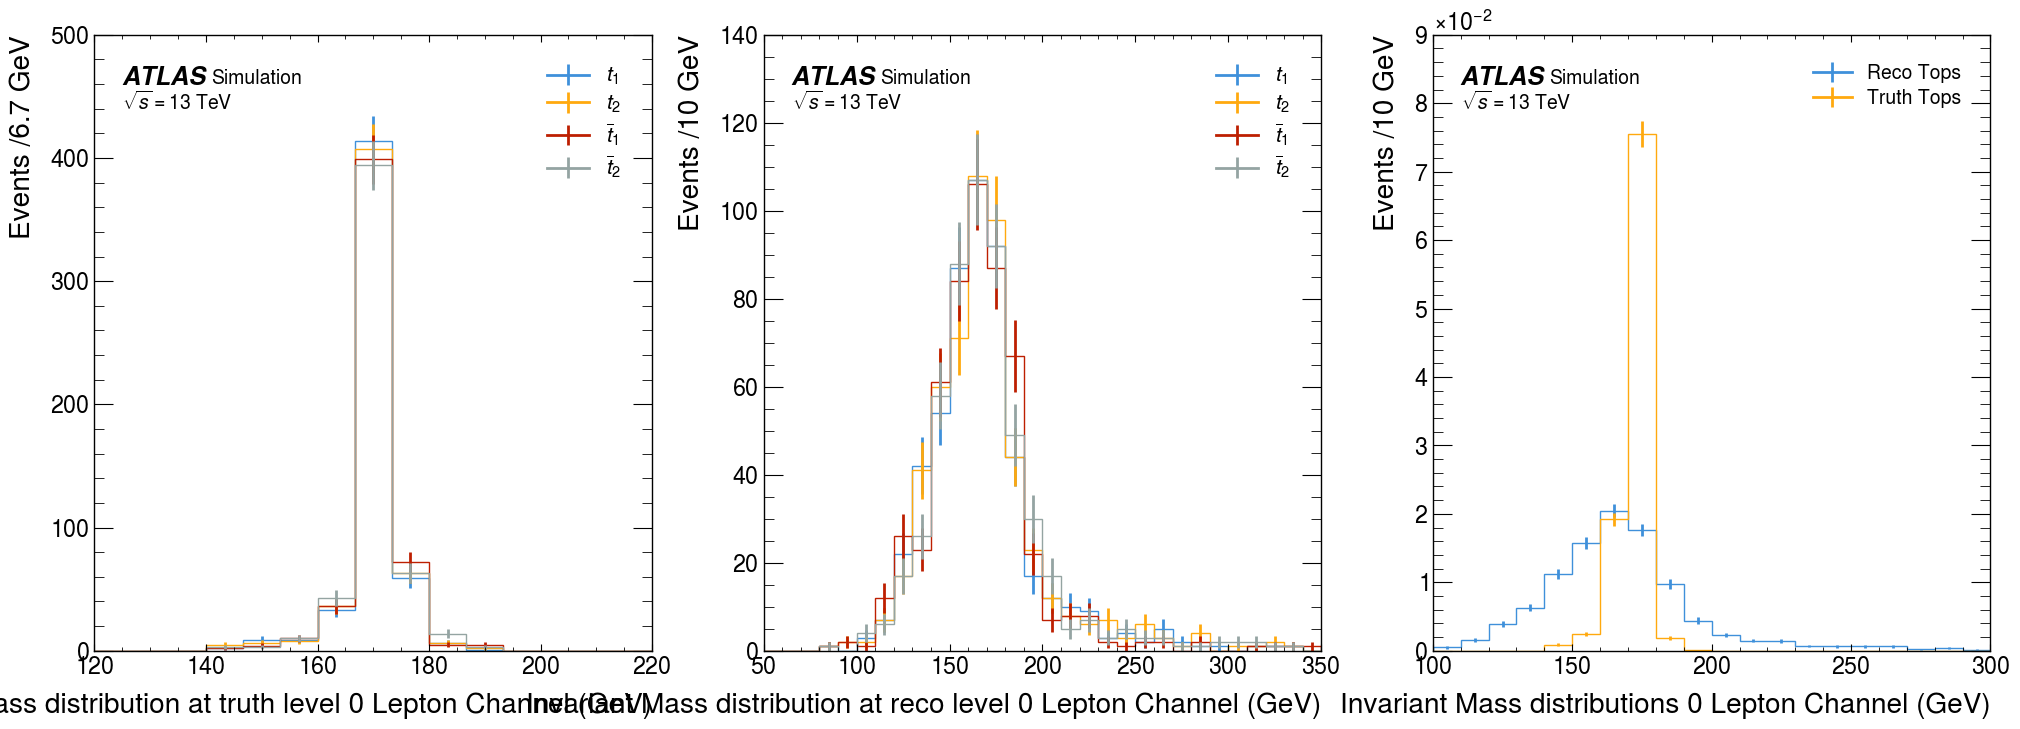

Peak bin center for $t_1$: 170.00 GeV
Peak bin center for $t_2$: 170.00 GeV
Peak bin center for $\overline{t}_1$: 170.00 GeV
Peak bin center for $\overline{t}_2$: 170.00 GeV
Peak bin center for $t_1$: 165.00 GeV
Peak bin center for $t_2$: 165.00 GeV
Peak bin center for $\overline{t}_1$: 175.00 GeV
Peak bin center for $\overline{t}_2$: 165.00 GeV
Peak bin center for Reco Tops: 163.33 GeV
Peak bin center for Truth Tops: 170.00 GeV


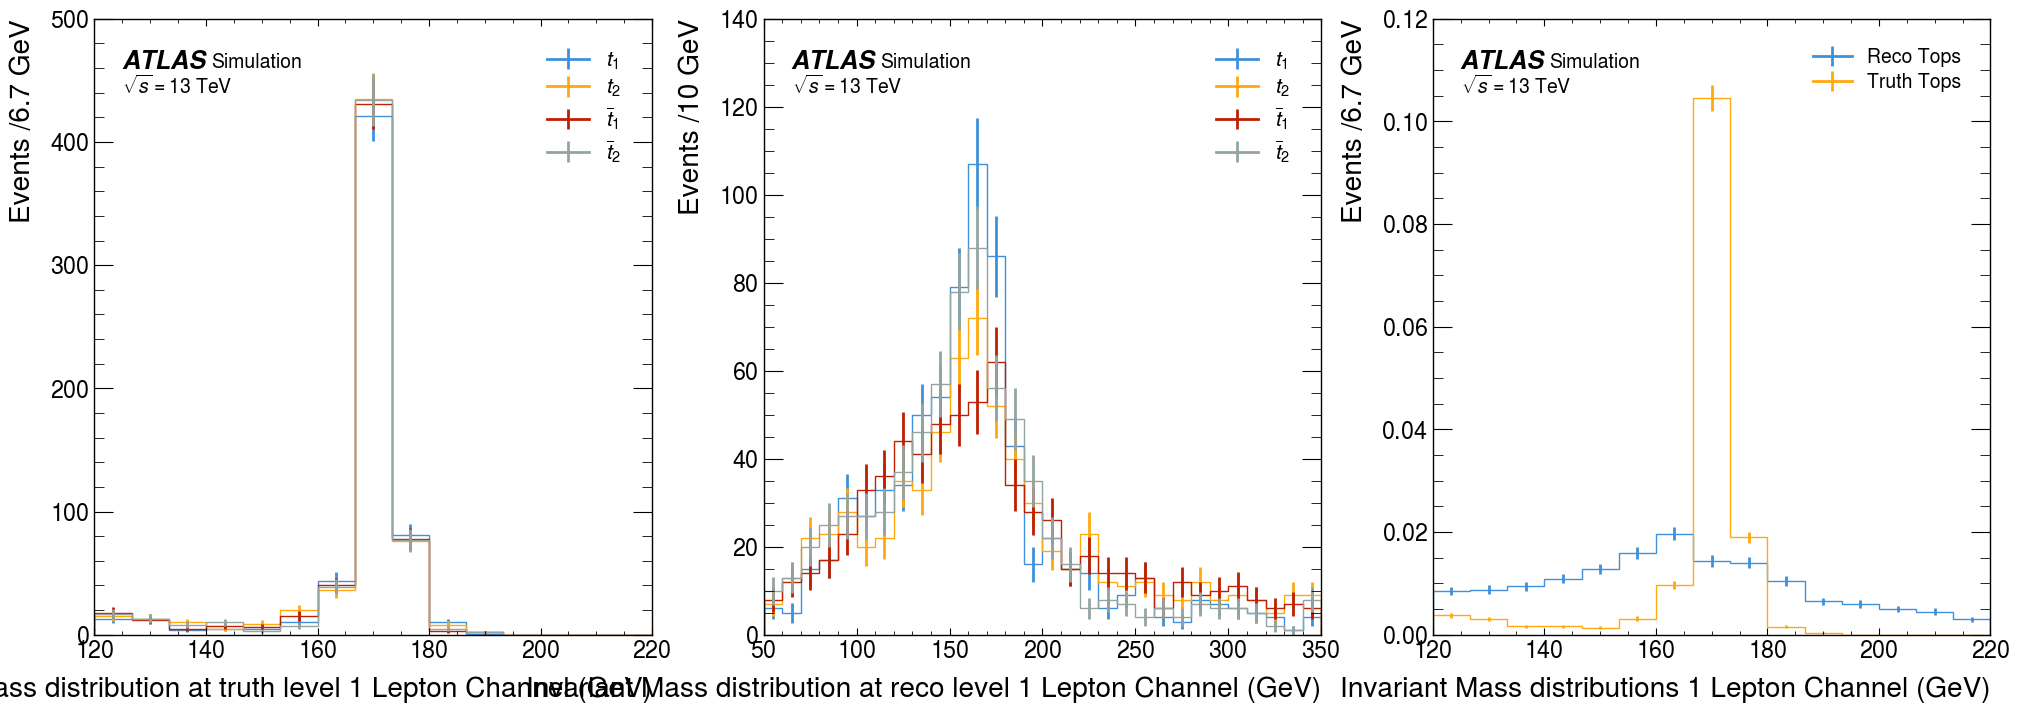

Peak bin center for $t_1$: 175.00 GeV
Peak bin center for $t_2$: 175.00 GeV
Peak bin center for $\overline{t}_1$: 175.00 GeV
Peak bin center for $\overline{t}_2$: 175.00 GeV
Peak bin center for $t_1$: 125.00 GeV
Peak bin center for $t_2$: 145.00 GeV
Peak bin center for $\overline{t}_1$: 165.00 GeV
Peak bin center for $\overline{t}_2$: 125.00 GeV
Peak bin center for Reco Tops: 125.00 GeV
Peak bin center for Truth Tops: 175.00 GeV


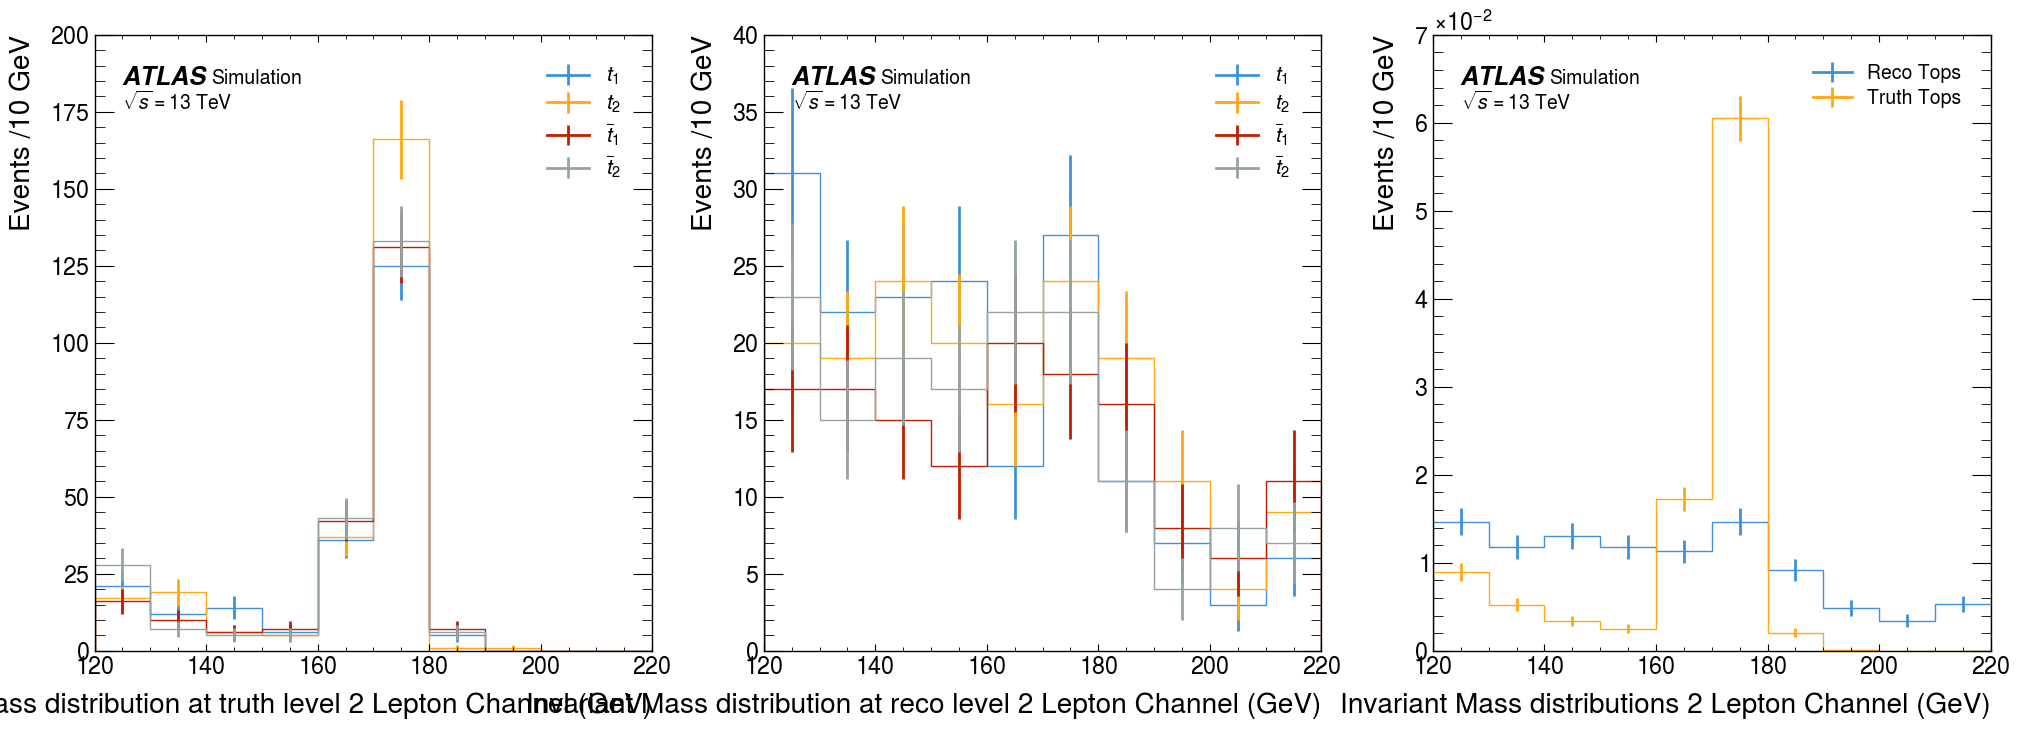

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (24,8))
histogram([t1_0L.m, t2_0L.m, t3_0L.m, t4_0L.m], 15, [r'$t_1$', r'$t_2$', r'$\overline{t}_1$', r'$\overline{t}_2$'], ax[0], density = False, x_units='GeV', set_range=(120,220), print_peak=True)
ax[0].set_xlabel(r'Invariant Mass distribution at truth level 0 Lepton Channel (GeV)')
ax[0].legend(fontsize=15)
histogram([top_1_4t_0L.m, top_2_4t_0L.m, antitop_1_4t_0L.m, antitop_2_4t_0L.m], 30, [r'$t_1$',r'$t_2$',r'$\overline{t}_1$',r'$\overline{t}_2$'], ax[1], density = False, x_units='GeV', print_peak=True, set_range=(50,350))
ax[1].set_xlabel(r'Invariant Mass distribution at reco level 0 Lepton Channel (GeV)')
ax[1].legend(fontsize=15)
histogram([reco_tops_4t_0L.m,truth_tops_4t_0L.m], 20, ['Reco Tops', 'Truth Tops'], ax[2], density = True, x_units='GeV', print_peak=True, set_range=(100,300))
ax[2].set_xlabel(r'Invariant Mass distributions 0 Lepton Channel (GeV)')

plt.subplots_adjust(hspace=0.25)
plt.show()

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (24,8))
histogram([t1_1L.m, t2_1L.m, t3_1L.m, t4_1L.m], 15, [r'$t_1$', r'$t_2$', r'$\overline{t}_1$', r'$\overline{t}_2$'], ax[0], density = False, x_units='GeV', set_range=(120,220), print_peak=True)
ax[0].set_xlabel(r'Invariant Mass distribution at truth level 1 Lepton Channel (GeV)')
ax[0].legend(fontsize=15)
histogram([top_1_4t_1L.m, top_2_4t_1L.m, antitop_1_4t_1L.m, antitop_2_4t_1L.m], 30, [r'$t_1$',r'$t_2$',r'$\overline{t}_1$',r'$\overline{t}_2$'], ax[1], density = False, x_units='GeV', print_peak=True, set_range=(50,350))
ax[1].set_xlabel(r'Invariant Mass distribution at reco level 1 Lepton Channel (GeV)')
ax[1].legend(fontsize=15)
histogram([reco_tops_4t_1L.m,truth_tops_4t_1L.m], 15, ['Reco Tops', 'Truth Tops'], ax[2], density = True, x_units='GeV', print_peak=True, set_range=(120,220))
ax[2].set_xlabel(r'Invariant Mass distributions 1 Lepton Channel (GeV)')

plt.subplots_adjust(hspace=0.25)
plt.show()

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (24,8))
histogram([t1_4t_2L.m, t2_4t_2L.m, t3_4t_2L.m, t4_4t_2L.m], 10, [r'$t_1$', r'$t_2$', r'$\overline{t}_1$', r'$\overline{t}_2$'], ax[0], density = False, x_units='GeV', set_range=(120,220), print_peak=True)
ax[0].set_xlabel(r'Invariant Mass distribution at truth level 2 Lepton Channel (GeV)')
ax[0].legend(fontsize=15)
histogram([top1_4t_2L.m, top2_4t_2L.m, top3_4t_2L.m, top4_4t_2L.m], 10, [r'$t_1$',r'$t_2$',r'$\overline{t}_1$',r'$\overline{t}_2$'], ax[1], density = False, x_units='GeV', print_peak=True, set_range=(120,220))
ax[1].set_xlabel(r'Invariant Mass distribution at reco level 2 Lepton Channel (GeV)')
ax[1].legend(fontsize=15)
histogram([reco_tops_4t_2L.m,truth_tops_4t_2L.m], 10, ['Reco Tops', 'Truth Tops'], ax[2], density = True, x_units='GeV', print_peak=True, set_range=(120,220))
ax[2].set_xlabel(r'Invariant Mass distributions 2 Lepton Channel (GeV)')

plt.subplots_adjust(hspace=0.25)
plt.show()



### 3 Top Matching

In [374]:
tree3W = uproot.open(directory + "tttW_withtruth_nov13 (1).root")
tree3W_truth = tree3W['Truth;1']
tree3W_reco = tree3W['Reco;1']

events_3tj_truth = tree3W_truth.arrays(['b_id', 'b_pt', 'b_eta', 'b_phi', 'b_e', 'b_mass', 'W_decay_id', 'W_decay_pt', 'W_decay_eta', 'W_decay_phi', 'W_decay_e', 'W_decay_mass'])
events_3tj_partonic = tree3W_truth.arrays(['top_pt', 'top_eta', 'top_phi', 'top_e', 'top_mass', 'top_id', 'W_pt', 'W_eta', 'W_phi', 'W_e', 'W_mass', 'W_id',])
events_3tj_reco = tree3W_reco.arrays(['jet_pt', 'jet_eta', 'jet_phi', 'jet_mass', 'jet_btag', 'el_pt', 'el_eta', 'el_phi', 'el_charge', 'mu_pt', 'mu_charge', 'met_met', 'met_eta', 'met_phi'])
events_3tj_reco['el_mass'] = 0.511e-3 * np.ones_like(events_3tj_reco['el_pt'])
events_3tj_reco['mu_mass'] = 0.1057 * np.ones_like(events_3tj_reco['mu_pt'])

x = events_3tj_truth['W_decay_id'][(events_3tj_truth['W_decay_id']==15)|(events_3tj_truth['W_decay_id']==-15)]
events_3tj_reco = events_3tj_reco[ak.num(x)==0]
events_3tj_partonic = events_3tj_partonic[ak.num(x)==0]
events_3tj_truth = events_3tj_truth[ak.num(x)==0]


neutrino_remover = (abs(events_3tj_truth['W_decay_id']) != 12)&(abs(events_3tj_truth['W_decay_id']) != 14)&(abs(events_3tj_truth['W_decay_id']) != 16)&(abs(events_3tj_truth['W_decay_id']) != 18)
events_3tj_truth['W_decay_id'] = events_3tj_truth['W_decay_id'][neutrino_remover]
events_3tj_truth['W_decay_pt'] = events_3tj_truth['W_decay_pt'][neutrino_remover]
events_3tj_truth['W_decay_eta'] = events_3tj_truth['W_decay_eta'][neutrino_remover]
events_3tj_truth['W_decay_phi'] = events_3tj_truth['W_decay_phi'][neutrino_remover]
events_3tj_truth['W_decay_e'] = events_3tj_truth['W_decay_e'][neutrino_remover]
events_3tj_truth['W_decay_mass'] = events_3tj_truth['W_decay_mass'][neutrino_remover]


jet_pt_3tj = events_3tj_reco['jet_pt'][(events_3tj_reco['jet_eta']<2.5) & (events_3tj_reco['jet_eta']>-2.5)]
jet_eta_3tj = events_3tj_reco['jet_eta'][(events_3tj_reco['jet_eta']<2.5) & (events_3tj_reco['jet_eta']>-2.5)]
jet_phi_3tj = events_3tj_reco['jet_phi'][(events_3tj_reco['jet_eta']<2.5) & (events_3tj_reco['jet_eta']>-2.5)]
jet_mass_3tj = events_3tj_reco['jet_mass'][(events_3tj_reco['jet_eta']<2.5) & (events_3tj_reco['jet_eta']>-2.5)]

electron_pt_3tj = events_3tj_reco['el_pt'][(events_3tj_reco['el_pt'] > 15) & (events_3tj_reco['el_eta'] < 2.47) & (events_3tj_reco['el_eta'] > -2.47)]
electron_eta_3tj = events_3tj_reco['el_eta'][(events_3tj_reco['el_pt'] > 15) & (events_3tj_reco['el_eta'] < 2.47) & (events_3tj_reco['el_eta'] > -2.47)]
electron_phi_3tj = events_3tj_reco['el_phi'][(events_3tj_reco['el_pt'] > 15) & (events_3tj_reco['el_eta'] < 2.47) & (events_3tj_reco['el_eta'] > -2.47)]
electron_mass_3tj = events_3tj_reco['el_mass'][(events_3tj_reco['el_pt'] > 15) & (events_3tj_reco['el_eta'] < 2.47) & (events_3tj_reco['el_eta'] > -2.47)]

"""
muon_pt_3tj = events_3tj_reco['mu_pt'][(events_3tj_reco['mu_pt']>15) & (events_3tj_reco['mu_eta']<2.5) & (events_3tj_reco['mu_eta']>-2.5)]
muon_eta_3tj = events_3tj_reco['mu_eta'][(events_3tj_reco['mu_pt']>15) & (events_3tj_reco['mu_eta']<2.5) & (events_3tj_reco['mu_eta']>-2.5)]
muon_phi_3tj = events_3tj_reco['mu_phi'][(events_3tj_reco['mu_pt']>15) & (events_3tj_reco['mu_eta']<2.5) & (events_3tj_reco['mu_eta']>-2.5)]
muon_mass_3tj = events_3tj_reco['mu_mass'][(events_3tj_reco['mu_pt']>15) & (events_3tj_reco['mu_eta']<2.5) & (events_3tj_reco['mu_eta']>-2.5)]
"""

reco_pt_3tj = ak.concatenate((jet_pt_3tj,electron_pt_3tj), axis=1)
reco_eta_3tj = ak.concatenate((jet_eta_3tj,electron_eta_3tj), axis=1)
reco_phi_3tj = ak.concatenate((jet_phi_3tj,electron_phi_3tj), axis=1)
reco_mass_3tj = ak.concatenate((jet_mass_3tj,electron_mass_3tj), axis=1)

b_pt_3tj = events_3tj_truth['b_pt']
b_eta_3tj = events_3tj_truth['b_eta']
b_phi_3tj = events_3tj_truth['b_phi']
b_mass_3tj = events_3tj_truth['b_mass']
b_e_3tj = events_3tj_truth['b_e']
b_id_3tj = events_3tj_truth['b_id']


w_decay_pt_3tj = events_3tj_truth['W_decay_pt']
w_decay_eta_3tj = events_3tj_truth['W_decay_eta']
w_decay_phi_3tj = events_3tj_truth['W_decay_phi']
w_decay_mass_3tj = events_3tj_truth['W_decay_mass']
w_decay_e_3tj = events_3tj_truth['W_decay_e']
w_decay_id_3tj = events_3tj_truth['W_decay_id']

truth_pt_3tj = ak.concatenate((b_pt_3tj,w_decay_pt_3tj), axis=1)
truth_eta_3tj = ak.concatenate((b_eta_3tj,w_decay_eta_3tj), axis=1)
truth_phi_3tj = ak.concatenate((b_phi_3tj,w_decay_phi_3tj), axis=1)
truth_mass_3tj = ak.concatenate((b_mass_3tj,w_decay_mass_3tj), axis=1)
truth_e_3tj = ak.concatenate((b_e_3tj,w_decay_e_3tj), axis=1)
truth_id_3tj = ak.concatenate((b_id_3tj,w_decay_id_3tj), axis=1)

reco_3tj = vector.zip({'pt':reco_pt_3tj,'eta':reco_eta_3tj,'phi':reco_phi_3tj,'mass':reco_mass_3tj})
truth_3tj = vector.zip({'pt':truth_pt_3tj,'eta':truth_eta_3tj,'phi':truth_phi_3tj,'mass':truth_mass_3tj})

reco_3tj_leptons = vector.zip({'pt':electron_pt_3tj,'eta':electron_eta_3tj,'phi':electron_phi_3tj,'mass':electron_mass_3tj})
reco_3tj_jets = vector.zip({'pt':jet_pt_3tj,'eta':jet_eta_3tj,'phi':jet_phi_3tj,'mass':jet_mass_3tj})

In [375]:
lepton_count_3tj = ak.num(events_3tj_truth['W_decay_id'][(abs(events_3tj_truth['W_decay_id'])>10)&(abs(events_3tj_truth['W_decay_id'])<19)])
events_3tj_truth_0L = events_3tj_truth[lepton_count_3tj == 0]
events_3tj_truth_1L = events_3tj_truth[lepton_count_3tj == 1]
events_3tj_truth_2L = events_3tj_truth[lepton_count_3tj == 2]
events_3tj_truth_3L = events_3tj_truth[lepton_count_3tj == 3]
events_3tj_truth_4L = events_3tj_truth[lepton_count_3tj == 4]

truth_3tj_0L, truth_id_3tj_0L = truth_3tj[lepton_count_3tj == 0], truth_id_3tj[lepton_count_3tj == 0]
truth_3tj_1L, truth_id_3tj_1L = truth_3tj[lepton_count_3tj == 1], truth_id_3tj[lepton_count_3tj == 1]
truth_3tj_2L, truth_id_3tj_2L = truth_3tj[lepton_count_3tj == 2], truth_id_3tj[lepton_count_3tj == 2]
truth_3tj_3L, truth_id_3tj_3L = truth_3tj[lepton_count_3tj == 3], truth_id_3tj[lepton_count_3tj == 3]
truth_3tj_4L, truth_id_3tj_4L = truth_3tj[lepton_count_3tj == 4], truth_id_3tj[lepton_count_3tj == 4]

reco_3tj_0L = reco_3tj[lepton_count_3tj == 0]
reco_3tj_1L = reco_3tj[lepton_count_3tj == 1]
reco_3tj_2L = reco_3tj[lepton_count_3tj == 2]
reco_3tj_3L = reco_3tj[lepton_count_3tj == 3]
reco_3tj_4L = reco_3tj[lepton_count_3tj == 4]

reco_3tj_leptons_0L = reco_3tj_leptons[lepton_count_3tj == 0]
reco_3tj_leptons_1L = reco_3tj_leptons[lepton_count_3tj == 1]
reco_3tj_leptons_2L = reco_3tj_leptons[lepton_count_3tj == 2]
reco_3tj_leptons_3L = reco_3tj_leptons[lepton_count_3tj == 3]
reco_3tj_leptons_4L = reco_3tj_leptons[lepton_count_3tj == 4]

reco_3tj_jets_0L = reco_3tj_jets[lepton_count_3tj == 0]
reco_3tj_jets_1L = reco_3tj_jets[lepton_count_3tj == 1]
reco_3tj_jets_2L = reco_3tj_jets[lepton_count_3tj == 2]
reco_3tj_jets_3L = reco_3tj_jets[lepton_count_3tj == 3]

In [376]:
print(len(truth_3tj_0L))
print(len(truth_id_3tj_0L))

103846
103846


In [377]:
print(ak.num(truth_3tj_0L))

[11, 11, 11, 11, 11, 11, 11, 11, 11, ..., 11, 11, 11, 11, 11, 11, 11, 11, 11]


In [378]:
fully_matched_3tj_0L, truth_3tj_test_0L, _ = truth_matching(truth_3tj_0L, truth_id_3tj_0L, reco_3tj_jets_0L, reco_3tj_leptons_0L)

fully_matched_ids_3tj_0L = fully_matched_3tj_0L['truth']['id']

t1_0L = truth_3tj_test_0L[:,0]+truth_3tj_test_0L[:,4]+truth_3tj_test_0L[:,5]
t2_0L = truth_3tj_test_0L[:,1]+truth_3tj_test_0L[:,6]+truth_3tj_test_0L[:,7]
t3_0L = truth_3tj_test_0L[:,2]+truth_3tj_test_0L[:,8]+truth_3tj_test_0L[:,9]

top_1_particles_3tj_0L = fully_matched_3tj_0L['reco'][(fully_matched_ids_3tj_0L==1)|(fully_matched_ids_3tj_0L==5)|(fully_matched_ids_3tj_0L==6)]
top_2_particles_3tj_0L = fully_matched_3tj_0L['reco'][(fully_matched_ids_3tj_0L==2)|(fully_matched_ids_3tj_0L==7)|(fully_matched_ids_3tj_0L==8)]
top_3_particles_3tj_0L = fully_matched_3tj_0L['reco'][(fully_matched_ids_3tj_0L==3)|(fully_matched_ids_3tj_0L==9)|(fully_matched_ids_3tj_0L==10)]

top_1_3tj_0L = ak.sum(top_1_particles_3tj_0L, axis=1)
top_2_3tj_0L = ak.sum(top_2_particles_3tj_0L, axis=1)
top_3_3tj_0L = ak.sum(top_3_particles_3tj_0L, axis=1)

reco_tops_3tj_0L = ak.concatenate((top_1_3tj_0L, top_2_3tj_0L, top_3_3tj_0L))
truth_tops_3tj_0L = ak.concatenate((t1_0L, t2_0L, t3_0L))

reco_leptons_3tj_0L_test = fully_matched_3tj_0L['reco'][(fully_matched_3tj_0L['reco'].tau==0.1057)|(fully_matched_3tj_0L['reco'].tau == 0.511e-3)]
reco_jets_3tj_0L = fully_matched_3tj_0L['reco'][~(fully_matched_3tj_0L['reco'].tau==0.1057)|(fully_matched_3tj_0L['reco'].tau == 0.511e-3)]
reco_leptons_3tj_0L = reco_leptons_3tj_0L_test[ak.num(reco_leptons_3tj_0L_test) !=0]

In [404]:
fully_matched_3tj_1L, truth_3tj_test_1L, fully_matched_1L = truth_matching(truth_3tj_1L, truth_id_3tj_1L, reco_3tj_jets_1L, reco_3tj_leptons_1L)
fully_matched_ids_3tj_1L = fully_matched_3tj_1L['truth']['id']

fully_matched_events_3tj_truth_1L = events_3tj_truth_1L[fully_matched_1L]

lepton_locations_1L = ak.argmax(abs(fully_matched_events_3tj_truth_1L['W_decay_id']), axis = 1)

matched_lepton_first_1L = fully_matched_3tj_1L[lepton_locations_1L == 0]
matched_lepton_second_1L = fully_matched_3tj_1L[lepton_locations_1L == 2]
matched_lepton_third_1L = fully_matched_3tj_1L[lepton_locations_1L == 4]

matched_ids_first_1L = fully_matched_ids_3tj_1L[lepton_locations_1L == 0]
matched_ids_second_1L = fully_matched_ids_3tj_1L[lepton_locations_1L == 2]
matched_ids_third_1L = fully_matched_ids_3tj_1L[lepton_locations_1L == 4]

truth_lepton_first_1L = truth_3tj_test_1L[lepton_locations_1L == 0]
truth_lepton_second_1L = truth_3tj_test_1L[lepton_locations_1L == 2]
truth_lepton_third_1L = truth_3tj_test_1L[lepton_locations_1L == 4]

t1_lepton_first_1L = truth_lepton_first_1L[:,0]+truth_lepton_first_1L[:,4]
t2_lepton_first_1L = truth_lepton_first_1L[:,1]+truth_lepton_first_1L[:,5]+truth_lepton_first_1L[:,6]
t3_lepton_first_1L = truth_lepton_first_1L[:,2]+truth_lepton_first_1L[:,7]+truth_lepton_first_1L[:,8]

t1_lepton_second_1L = truth_lepton_second_1L[:,0]+truth_lepton_second_1L[:,4]+truth_lepton_second_1L[:,5]
t2_lepton_second_1L = truth_lepton_second_1L[:,1]+truth_lepton_second_1L[:,6]
t3_lepton_second_1L = truth_lepton_second_1L[:,2]+truth_lepton_second_1L[:,7]+truth_lepton_second_1L[:,8]

t1_lepton_third_1L = truth_lepton_third_1L[:,0]+truth_lepton_third_1L[:,4]+truth_lepton_third_1L[:,5]
t2_lepton_third_1L = truth_lepton_third_1L[:,1]+truth_lepton_third_1L[:,6]+truth_lepton_third_1L[:,7]
t3_lepton_third_1L = truth_lepton_third_1L[:,2]+truth_lepton_third_1L[:,8]

t1_lepton_fourth_1L = truth_lepton_fourth_1L[:,0]+truth_lepton_fourth_1L[:,4]+truth_lepton_fourth_1L[:,5]
t2_lepton_fourth_1L = truth_lepton_fourth_1L[:,1]+truth_lepton_fourth_1L[:,6]+truth_lepton_fourth_1L[:,7]
t3_lepton_fourth_1L = truth_lepton_fourth_1L[:,2]+truth_lepton_fourth_1L[:,8]+truth_lepton_fourth_1L[:,9]

t1_1L = ak.concatenate((t1_lepton_first_1L,t1_lepton_second_1L, t1_lepton_third_1L, t1_lepton_fourth_1L))
t2_1L = ak.concatenate((t2_lepton_first_1L,t2_lepton_second_1L, t2_lepton_third_1L, t2_lepton_fourth_1L))
t3_1L = ak.concatenate((t3_lepton_first_1L,t3_lepton_second_1L, t3_lepton_third_1L, t3_lepton_fourth_1L))

top_1_particles_lepton_first_1L = matched_lepton_first_1L['reco'][(matched_ids_first_1L==1)|(matched_ids_first_1L==5)]
top_2_particles_lepton_first_1L = matched_lepton_first_1L['reco'][(matched_ids_first_1L==2)|(matched_ids_first_1L==6)|(matched_ids_first_1L==7)]
top_3_particles_lepton_first_1L = matched_lepton_first_1L['reco'][(matched_ids_first_1L==3)|(matched_ids_first_1L==8)|(matched_ids_first_1L==9)]

top_1_particles_lepton_second_1L = matched_lepton_second_1L['reco'][(matched_ids_second_1L==1)|(matched_ids_second_1L==5)|(matched_ids_second_1L==6)]
top_2_particles_lepton_second_1L = matched_lepton_second_1L['reco'][(matched_ids_second_1L==2)|(matched_ids_second_1L==7)]
top_3_particles_lepton_second_1L = matched_lepton_second_1L['reco'][(matched_ids_second_1L==3)|(matched_ids_second_1L==8)|(matched_ids_second_1L==9)]

top_1_particles_lepton_third_1L = matched_lepton_third_1L['reco'][(matched_ids_third_1L==1)|(matched_ids_third_1L==5)|(matched_ids_third_1L==6)]
top_2_particles_lepton_third_1L = matched_lepton_third_1L['reco'][(matched_ids_third_1L==2)|(matched_ids_third_1L==7)|(matched_ids_third_1L==8)]
top_3_particles_lepton_third_1L = matched_lepton_third_1L['reco'][(matched_ids_third_1L==3)|(matched_ids_third_1L==9)]

top_1_particles_lepton_fourth_1L = matched_lepton_fourth_1L['reco'][(matched_ids_fourth_1L==1)|(matched_ids_fourth_1L==5)|(matched_ids_fourth_1L==6)]
top_2_particles_lepton_fourth_1L = matched_lepton_fourth_1L['reco'][(matched_ids_fourth_1L==2)|(matched_ids_fourth_1L==7)|(matched_ids_fourth_1L==8)]
top_3_particles_lepton_fourth_1L = matched_lepton_fourth_1L['reco'][(matched_ids_fourth_1L==3)|(matched_ids_fourth_1L==9)|(matched_ids_fourth_1L==10)]

top_1_particles_3tj_1L = ak.concatenate((top_1_particles_lepton_first_1L, top_1_particles_lepton_second_1L, top_1_particles_lepton_third_1L, top_1_particles_lepton_fourth_1L))
top_2_particles_3tj_1L = ak.concatenate((top_2_particles_lepton_first_1L, top_2_particles_lepton_second_1L, top_2_particles_lepton_third_1L, top_2_particles_lepton_fourth_1L))
top_3_particles_3tj_1L = ak.concatenate((top_3_particles_lepton_first_1L, top_3_particles_lepton_second_1L, top_3_particles_lepton_third_1L, top_3_particles_lepton_fourth_1L))

top_1_3tj_1L = ak.sum(top_1_particles_3tj_1L, axis=1)
top_2_3tj_1L = ak.sum(top_2_particles_3tj_1L, axis=1)
top_3_3tj_1L = ak.sum(top_3_particles_3tj_1L, axis=1)

reco_tops_3tj_1L = ak.concatenate((top_1_3tj_1L, top_2_3tj_1L, top_3_3tj_1L))
truth_tops_3tj_1L = ak.concatenate((t1_1L, t2_1L, t3_1L, t4_1L))

reco_leptons_3tj_1L_test = fully_matched_3tj_1L['reco'][(fully_matched_3tj_1L['reco'].tau==0.1057)|(fully_matched_3tj_1L['reco'].tau == 0.511e-3)]
reco_jets_3tj_1L = fully_matched_3tj_1L['reco'][~(fully_matched_3tj_1L['reco'].tau==0.1057)|(fully_matched_3tj_1L['reco'].tau == 0.511e-3)]
reco_leptons_3tj_1L = reco_leptons_3tj_1L_test[ak.num(reco_leptons_3tj_1L_test) !=0]

In [ ]:
tree3W = uproot.open(directory + "tttW_withtruth_nov13 (1).root")
tree3W_truth = tree3W['Truth;1']
tree3W_reco = tree3W['Reco;1']

events_3tW_truth = tree3W_truth.arrays(['b_id', 'b_pt', 'b_eta', 'b_phi', 'b_e', 'b_mass', 'W_decay_id', 'W_decay_pt', 'W_decay_eta', 'W_decay_phi', 'W_decay_e', 'W_decay_mass'])
events_3tW_partonic = tree3W_truth.arrays(['top_pt', 'top_eta', 'top_phi', 'top_e', 'top_mass', 'top_id', 'W_pt', 'W_eta', 'W_phi', 'W_e', 'W_mass', 'W_id',])
events_3tW_reco = tree3W_reco.arrays(['jet_pt', 'jet_eta', 'jet_phi', 'jet_mass', 'jet_btag', 'el_pt', 'el_eta', 'el_phi', 'el_charge', 'mu_pt', 'mu_charge', 'met_met', 'met_eta', 'met_phi'])
events_3tW_reco['el_mass'] = 0.511e-3 * np.ones_like(events_3tW_reco['el_pt'])
events_3tW_reco['mu_mass'] = 0.1057 * np.ones_like(events_3tW_reco['mu_pt'])

x = events_3tW_truth['W_decay_id'][(events_3tW_truth['W_decay_id']==15)|(events_3tW_truth['W_decay_id']==-15)]
events_3tW_reco = events_3tW_reco[ak.num(x)==0]
events_3tW_partonic = events_3tW_partonic[ak.num(x)==0]
events_3tW_truth = events_3tW_truth[ak.num(x)==0]


neutrino_remover = (abs(events_3tW_truth['W_decay_id']) != 12)&(abs(events_3tW_truth['W_decay_id']) != 14)&(abs(events_3tW_truth['W_decay_id']) != 16)&(abs(events_3tW_truth['W_decay_id']) != 18)
events_3tW_truth['W_decay_id'] = events_3tW_truth['W_decay_id'][neutrino_remover]
events_3tW_truth['W_decay_pt'] = events_3tW_truth['W_decay_pt'][neutrino_remover]
events_3tW_truth['W_decay_eta'] = events_3tW_truth['W_decay_eta'][neutrino_remover]
events_3tW_truth['W_decay_phi'] = events_3tW_truth['W_decay_phi'][neutrino_remover]
events_3tW_truth['W_decay_e'] = events_3tW_truth['W_decay_e'][neutrino_remover]
events_3tW_truth['W_decay_mass'] = events_3tW_truth['W_decay_mass'][neutrino_remover]


jet_pt_3tW = events_3tW_reco['jet_pt'][(events_3tW_reco['jet_eta']<2.5) & (events_3tW_reco['jet_eta']>-2.5)]
jet_eta_3tW = events_3tW_reco['jet_eta'][(events_3tW_reco['jet_eta']<2.5) & (events_3tW_reco['jet_eta']>-2.5)]
jet_phi_3tW = events_3tW_reco['jet_phi'][(events_3tW_reco['jet_eta']<2.5) & (events_3tW_reco['jet_eta']>-2.5)]
jet_mass_3tW = events_3tW_reco['jet_mass'][(events_3tW_reco['jet_eta']<2.5) & (events_3tW_reco['jet_eta']>-2.5)]

electron_pt_3tW = events_3tW_reco['el_pt'][(events_3tW_reco['el_pt'] > 15) & (events_3tW_reco['el_eta'] < 2.47) & (events_3tW_reco['el_eta'] > -2.47)]
electron_eta_3tW = events_3tW_reco['el_eta'][(events_3tW_reco['el_pt'] > 15) & (events_3tW_reco['el_eta'] < 2.47) & (events_3tW_reco['el_eta'] > -2.47)]
electron_phi_3tW = events_3tW_reco['el_phi'][(events_3tW_reco['el_pt'] > 15) & (events_3tW_reco['el_eta'] < 2.47) & (events_3tW_reco['el_eta'] > -2.47)]
electron_mass_3tW = events_3tW_reco['el_mass'][(events_3tW_reco['el_pt'] > 15) & (events_3tW_reco['el_eta'] < 2.47) & (events_3tW_reco['el_eta'] > -2.47)]

"""
muon_pt_3tW = events_3tW_reco['mu_pt'][(events_3tW_reco['mu_pt']>15) & (events_3tW_reco['mu_eta']<2.5) & (events_3tW_reco['mu_eta']>-2.5)]
muon_eta_3tW = events_3tW_reco['mu_eta'][(events_3tW_reco['mu_pt']>15) & (events_3tW_reco['mu_eta']<2.5) & (events_3tW_reco['mu_eta']>-2.5)]
muon_phi_3tW = events_3tW_reco['mu_phi'][(events_3tW_reco['mu_pt']>15) & (events_3tW_reco['mu_eta']<2.5) & (events_3tW_reco['mu_eta']>-2.5)]
muon_mass_3tW = events_3tW_reco['mu_mass'][(events_3tW_reco['mu_pt']>15) & (events_3tW_reco['mu_eta']<2.5) & (events_3tW_reco['mu_eta']>-2.5)]
"""

reco_pt_3tW = ak.concatenate((jet_pt_3tW,electron_pt_3tW), axis=1)
reco_eta_3tW = ak.concatenate((jet_eta_3tW,electron_eta_3tW), axis=1)
reco_phi_3tW = ak.concatenate((jet_phi_3tW,electron_phi_3tW), axis=1)
reco_mass_3tW = ak.concatenate((jet_mass_3tW,electron_mass_3tW), axis=1)

b_pt_3tW = events_3tW_truth['b_pt']
b_eta_3tW = events_3tW_truth['b_eta']
b_phi_3tW = events_3tW_truth['b_phi']
b_mass_3tW = events_3tW_truth['b_mass']
b_e_3tW = events_3tW_truth['b_e']
b_id_3tW = events_3tW_truth['b_id']


w_decay_pt_3tW = events_3tW_truth['W_decay_pt']
w_decay_eta_3tW = events_3tW_truth['W_decay_eta']
w_decay_phi_3tW = events_3tW_truth['W_decay_phi']
w_decay_mass_3tW = events_3tW_truth['W_decay_mass']
w_decay_e_3tW = events_3tW_truth['W_decay_e']
w_decay_id_3tW = events_3tW_truth['W_decay_id']

truth_pt_3tW = ak.concatenate((b_pt_3tW,w_decay_pt_3tW), axis=1)
truth_eta_3tW = ak.concatenate((b_eta_3tW,w_decay_eta_3tW), axis=1)
truth_phi_3tW = ak.concatenate((b_phi_3tW,w_decay_phi_3tW), axis=1)
truth_mass_3tW = ak.concatenate((b_mass_3tW,w_decay_mass_3tW), axis=1)
truth_e_3tW = ak.concatenate((b_e_3tW,w_decay_e_3tW), axis=1)
truth_id_3tW = ak.concatenate((b_id_3tW,w_decay_id_3tW), axis=1)

reco_3tW = vector.zip({'pt':reco_pt_3tW,'eta':reco_eta_3tW,'phi':reco_phi_3tW,'mass':reco_mass_3tW})
truth_3tW = vector.zip({'pt':truth_pt_3tW,'eta':truth_eta_3tW,'phi':truth_phi_3tW,'mass':truth_mass_3tW})

reco_3tW_leptons = vector.zip({'pt':electron_pt_3tW,'eta':electron_eta_3tW,'phi':electron_phi_3tW,'mass':electron_mass_3tW})
reco_3tW_jets = vector.zip({'pt':jet_pt_3tW,'eta':jet_eta_3tW,'phi':jet_phi_3tW,'mass':jet_mass_3tW})

In [403]:
lepton_count_3tW = ak.num(events_3tW_truth['W_decay_id'][(abs(events_3tW_truth['W_decay_id'])>10)&(abs(events_3tW_truth['W_decay_id'])<19)])
events_3tW_truth_0L = events_3tW_truth[lepton_count_3tW == 0]

events_3tW_truth_1L = events_3tW_truth[lepton_count_3tW == 1]

events_3tW_truth_2L = events_3tW_truth[lepton_count_3tW == 2]
events_3tW_truth_3L = events_3tW_truth[lepton_count_3tW == 3]
events_3tW_truth_4L = events_3tW_truth[lepton_count_3tW == 4]

truth_3tW_0L, truth_id_3tW_0L = truth_3tW[lepton_count_3tW == 0], truth_id_3tW[lepton_count_3tW == 0]
truth_3tW_1L, truth_id_3tW_1L = truth_3tW[lepton_count_3tW == 1], truth_id_3tW[lepton_count_3tW == 1]
truth_3tW_2L, truth_id_3tW_2L = truth_3tW[lepton_count_3tW == 2], truth_id_3tW[lepton_count_3tW == 2]
truth_3tW_3L, truth_id_3tW_3L = truth_3tW[lepton_count_3tW == 3], truth_id_3tW[lepton_count_3tW == 3]
truth_3tW_4L, truth_id_3tW_4L = truth_3tW[lepton_count_3tW == 4], truth_id_3tW[lepton_count_3tW == 4]

reco_3tW_0L = reco_3tW[lepton_count_3tW == 0]
reco_3tW_1L = reco_3tW[lepton_count_3tW == 1]
reco_3tW_2L = reco_3tW[lepton_count_3tW == 2]
reco_3tW_3L = reco_3tW[lepton_count_3tW == 3]
reco_3tW_4L = reco_3tW[lepton_count_3tW == 4]

reco_3tW_leptons_0L = reco_3tW_leptons[lepton_count_3tW == 0]
reco_3tW_leptons_1L = reco_3tW_leptons[lepton_count_3tW == 1]
reco_3tW_leptons_2L = reco_3tW_leptons[lepton_count_3tW == 2]
reco_3tW_leptons_3L = reco_3tW_leptons[lepton_count_3tW == 3]
reco_3tW_leptons_4L = reco_3tW_leptons[lepton_count_3tW == 4]

reco_3tW_jets_0L = reco_3tW_jets[lepton_count_3tW == 0]
reco_3tW_jets_1L = reco_3tW_jets[lepton_count_3tW == 1]
print(len(reco_3tW_jets_1L))
print(len(reco_3tW_jets))
reco_3tW_jets_2L = reco_3tW_jets[lepton_count_3tW == 2]
reco_3tW_jets_3L = reco_3tW_jets[lepton_count_3tW == 3]

133128
315352


In [356]:
fully_matched_3tW_0L, truth_3tW_test_0L, _ = truth_matching(truth_3tW_0L, truth_id_3tW_0L, reco_3tW_jets_0L, reco_3tW_leptons_0L)

fully_matched_ids_3tW_0L = fully_matched_3tW_0L['truth']['id']

t1_0L = truth_3tW_test_0L[:,0]+truth_3tW_test_0L[:,4]+truth_3tW_test_0L[:,5]
t2_0L = truth_3tW_test_0L[:,1]+truth_3tW_test_0L[:,6]+truth_3tW_test_0L[:,7]
t3_0L = truth_3tW_test_0L[:,2]+truth_3tW_test_0L[:,8]+truth_3tW_test_0L[:,9]

top_1_particles_3tW_0L = fully_matched_3tW_0L['reco'][(fully_matched_ids_3tW_0L==1)|(fully_matched_ids_3tW_0L==5)|(fully_matched_ids_3tW_0L==6)]
top_2_particles_3tW_0L = fully_matched_3tW_0L['reco'][(fully_matched_ids_3tW_0L==2)|(fully_matched_ids_3tW_0L==7)|(fully_matched_ids_3tW_0L==8)]
top_3_particles_3tW_0L = fully_matched_3tW_0L['reco'][(fully_matched_ids_3tW_0L==3)|(fully_matched_ids_3tW_0L==9)|(fully_matched_ids_3tW_0L==10)]

top_1_3tW_0L = ak.sum(top_1_particles_3tW_0L, axis=1)
top_2_3tW_0L = ak.sum(top_2_particles_3tW_0L, axis=1)
top_3_3tW_0L = ak.sum(top_3_particles_3tW_0L, axis=1)

reco_tops_3tW_0L = ak.concatenate((top_1_3tW_0L, top_2_3tW_0L, top_3_3tW_0L))
truth_tops_3tW_0L = ak.concatenate((t1_0L, t2_0L, t3_0L))

reco_leptons_3tW_0L_test = fully_matched_3tW_0L['reco'][(fully_matched_3tW_0L['reco'].tau==0.1057)|(fully_matched_3tW_0L['reco'].tau == 0.511e-3)]
reco_jets_3tW_0L = fully_matched_3tW_0L['reco'][~(fully_matched_3tW_0L['reco'].tau==0.1057)|(fully_matched_3tW_0L['reco'].tau == 0.511e-3)]
reco_leptons_3tW_0L = reco_leptons_3tW_0L_test[ak.num(reco_leptons_3tW_0L_test) !=0]

In [ ]:
fully_matched_3tW_1L, truth_3tW_test_1L, fully_matched_1L = truth_matching(truth_3tW_1L, truth_id_3tW_1L, reco_3tW_jets_1L, reco_3tW_leptons_1L)
fully_matched_ids_3tW_1L = fully_matched_3tW_1L['truth']['id']

fully_matched_events_3tW_truth_1L = events_3tW_truth_1L[fully_matched_1L]

lepton_locations_1L = ak.argmax(abs(fully_matched_events_3tW_truth_1L['W_decay_id']), axis = 1)

matched_lepton_first_1L = fully_matched_3tW_1L[lepton_locations_1L == 0]
matched_lepton_second_1L = fully_matched_3tW_1L[lepton_locations_1L == 2]
matched_lepton_third_1L = fully_matched_3tW_1L[lepton_locations_1L == 4]

matched_ids_first_1L = fully_matched_ids_3tW_1L[lepton_locations_1L == 0]
matched_ids_second_1L = fully_matched_ids_3tW_1L[lepton_locations_1L == 2]
matched_ids_third_1L = fully_matched_ids_3tW_1L[lepton_locations_1L == 4]

truth_lepton_first_1L = truth_3tW_test_1L[lepton_locations_1L == 0]
truth_lepton_second_1L = truth_3tW_test_1L[lepton_locations_1L == 2]
truth_lepton_third_1L = truth_3tW_test_1L[lepton_locations_1L == 4]

t1_lepton_first_1L = truth_lepton_first_1L[:,0]+truth_lepton_first_1L[:,4]
t2_lepton_first_1L = truth_lepton_first_1L[:,1]+truth_lepton_first_1L[:,5]+truth_lepton_first_1L[:,6]
t3_lepton_first_1L = truth_lepton_first_1L[:,2]+truth_lepton_first_1L[:,7]+truth_lepton_first_1L[:,8]

t1_lepton_second_1L = truth_lepton_second_1L[:,0]+truth_lepton_second_1L[:,4]+truth_lepton_second_1L[:,5]
t2_lepton_second_1L = truth_lepton_second_1L[:,1]+truth_lepton_second_1L[:,6]
t3_lepton_second_1L = truth_lepton_second_1L[:,2]+truth_lepton_second_1L[:,7]+truth_lepton_second_1L[:,8]

t1_lepton_third_1L = truth_lepton_third_1L[:,0]+truth_lepton_third_1L[:,4]+truth_lepton_third_1L[:,5]
t2_lepton_third_1L = truth_lepton_third_1L[:,1]+truth_lepton_third_1L[:,6]+truth_lepton_third_1L[:,7]
t3_lepton_third_1L = truth_lepton_third_1L[:,2]+truth_lepton_third_1L[:,8]

t1_lepton_fourth_1L = truth_lepton_fourth_1L[:,0]+truth_lepton_fourth_1L[:,4]+truth_lepton_fourth_1L[:,5]
t2_lepton_fourth_1L = truth_lepton_fourth_1L[:,1]+truth_lepton_fourth_1L[:,6]+truth_lepton_fourth_1L[:,7]
t3_lepton_fourth_1L = truth_lepton_fourth_1L[:,2]+truth_lepton_fourth_1L[:,8]+truth_lepton_fourth_1L[:,9]

t1_1L = ak.concatenate((t1_lepton_first_1L,t1_lepton_second_1L, t1_lepton_third_1L, t1_lepton_fourth_1L))
t2_1L = ak.concatenate((t2_lepton_first_1L,t2_lepton_second_1L, t2_lepton_third_1L, t2_lepton_fourth_1L))
t3_1L = ak.concatenate((t3_lepton_first_1L,t3_lepton_second_1L, t3_lepton_third_1L, t3_lepton_fourth_1L))

top_1_particles_lepton_first_1L = matched_lepton_first_1L['reco'][(matched_ids_first_1L==1)|(matched_ids_first_1L==5)]
top_2_particles_lepton_first_1L = matched_lepton_first_1L['reco'][(matched_ids_first_1L==2)|(matched_ids_first_1L==6)|(matched_ids_first_1L==7)]
top_3_particles_lepton_first_1L = matched_lepton_first_1L['reco'][(matched_ids_first_1L==3)|(matched_ids_first_1L==8)|(matched_ids_first_1L==9)]

top_1_particles_lepton_second_1L = matched_lepton_second_1L['reco'][(matched_ids_second_1L==1)|(matched_ids_second_1L==5)|(matched_ids_second_1L==6)]
top_2_particles_lepton_second_1L = matched_lepton_second_1L['reco'][(matched_ids_second_1L==2)|(matched_ids_second_1L==7)]
top_3_particles_lepton_second_1L = matched_lepton_second_1L['reco'][(matched_ids_second_1L==3)|(matched_ids_second_1L==8)|(matched_ids_second_1L==9)]

top_1_particles_lepton_third_1L = matched_lepton_third_1L['reco'][(matched_ids_third_1L==1)|(matched_ids_third_1L==5)|(matched_ids_third_1L==6)]
top_2_particles_lepton_third_1L = matched_lepton_third_1L['reco'][(matched_ids_third_1L==2)|(matched_ids_third_1L==7)|(matched_ids_third_1L==8)]
top_3_particles_lepton_third_1L = matched_lepton_third_1L['reco'][(matched_ids_third_1L==3)|(matched_ids_third_1L==9)]

top_1_particles_lepton_fourth_1L = matched_lepton_fourth_1L['reco'][(matched_ids_fourth_1L==1)|(matched_ids_fourth_1L==5)|(matched_ids_fourth_1L==6)]
top_2_particles_lepton_fourth_1L = matched_lepton_fourth_1L['reco'][(matched_ids_fourth_1L==2)|(matched_ids_fourth_1L==7)|(matched_ids_fourth_1L==8)]
top_3_particles_lepton_fourth_1L = matched_lepton_fourth_1L['reco'][(matched_ids_fourth_1L==3)|(matched_ids_fourth_1L==9)|(matched_ids_fourth_1L==10)]

top_1_particles_3tW_1L = ak.concatenate((top_1_particles_lepton_first_1L, top_1_particles_lepton_second_1L, top_1_particles_lepton_third_1L, top_1_particles_lepton_fourth_1L))
top_2_particles_3tW_1L = ak.concatenate((top_2_particles_lepton_first_1L, top_2_particles_lepton_second_1L, top_2_particles_lepton_third_1L, top_2_particles_lepton_fourth_1L))
top_3_particles_3tW_1L = ak.concatenate((top_3_particles_lepton_first_1L, top_3_particles_lepton_second_1L, top_3_particles_lepton_third_1L, top_3_particles_lepton_fourth_1L))

top_1_3tW_1L = ak.sum(top_1_particles_3tW_1L, axis=1)
top_2_3tW_1L = ak.sum(top_2_particles_3tW_1L, axis=1)
top_3_3tW_1L = ak.sum(top_3_particles_3tW_1L, axis=1)

reco_tops_3tW_1L = ak.concatenate((top_1_3tW_1L, top_2_3tW_1L, top_3_3tW_1L))
truth_tops_3tW_1L = ak.concatenate((t1_1L, t2_1L, t3_1L, t4_1L))

reco_leptons_3tW_1L_test = fully_matched_3tW_1L['reco'][(fully_matched_3tW_1L['reco'].tau==0.1057)|(fully_matched_3tW_1L['reco'].tau == 0.511e-3)]
reco_jets_3tW_1L = fully_matched_3tW_1L['reco'][~(fully_matched_3tW_1L['reco'].tau==0.1057)|(fully_matched_3tW_1L['reco'].tau == 0.511e-3)]
reco_leptons_3tW_1L = reco_leptons_3tW_1L_test[ak.num(reco_leptons_3tW_1L_test) !=0]

In [405]:
reco_3t_jets_1L = ak.concatenate((reco_jets_3tj_1L,reco_jets_3tW_1L),axis=0)
reco_3t_leptons_1L = ak.concatenate((reco_leptons_3tj_1L,reco_leptons_3tW_1L),axis=0)

filtered_reco_4t_jets_1L = reco_jets_4t_1L[(ak.num(reco_jets_4t_1L)>=2)]
filtered_reco_3t_jets_1L = reco_3t_jets_1L[(ak.num(reco_3t_jets_1L)>=2)]

In [408]:
print(len(reco_jets_3tj_1L))
print(len(reco_jets_3tW_1L))
print(len(filtered_reco_3t_jets_1L))
print(len(filtered_reco_4t_jets_1L))

436
436
872
768


In [409]:
reco_3t_jets = ak.concatenate((reco_3tj_jets,reco_3tW_jets),axis=0)
reco_3t_leptons = ak.concatenate((reco_3tj_leptons,reco_3tW_leptons),axis=0)

In [410]:
filtered_reco_4t_jets = reco_4t_jets[(ak.num(reco_4t_jets)>=2)]
filtered_reco_3t_jets = reco_3t_jets[(ak.num(reco_3t_jets)>=2)]

In [411]:
print(len(reco_4t_jets))
print(len(filtered_reco_4t_jets))
print(len(reco_3t_jets))
print(len(filtered_reco_3t_jets))

471950
471935
630704
630548


## Sorting

### Reco

In [412]:
sorted_indices = np.argsort(filtered_reco_4t_jets.pt)
trans_sorted_4t = filtered_reco_4t_jets[sorted_indices]

highest_pt_jet_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':trans_sorted_4t.m[:,-1]})
second_highest_pt_jet_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-2],'eta':trans_sorted_4t.eta[:,-2],'phi':trans_sorted_4t.phi[:,-2], 'mass':trans_sorted_4t.m[:,-2]})

sorted_indices = np.argsort(filtered_reco_3t_jets.rho)
trans_sorted_3t = filtered_reco_3t_jets[sorted_indices]

highest_pt_jet_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':trans_sorted_3t.m[:,-1]})
second_highest_pt_jet_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-2],'eta':trans_sorted_3t.eta[:,-2],'phi':trans_sorted_3t.phi[:,-2], 'mass':trans_sorted_3t.m[:,-2]})

sorted_indices = np.argsort(filtered_reco_4t_jets.eta)
trans_sorted_4t = filtered_reco_4t_jets[sorted_indices]

highest_eta_jet_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':trans_sorted_4t.m[:,-1]})
second_highest_eta_jet_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-2],'eta':trans_sorted_4t.eta[:,-2],'phi':trans_sorted_4t.phi[:,-2], 'mass':trans_sorted_4t.m[:,-2]})

sorted_indices = np.argsort(filtered_reco_3t_jets.eta)
trans_sorted_3t = filtered_reco_3t_jets[sorted_indices]

highest_eta_jet_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':trans_sorted_3t.m[:,-1]})
second_highest_eta_jet_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-2],'eta':trans_sorted_3t.eta[:,-2],'phi':trans_sorted_3t.phi[:,-2], 'mass':trans_sorted_3t.m[:,-2]})#

sorted_indices = np.argsort(filtered_reco_4t_jets.phi)
trans_sorted_4t = filtered_reco_4t_jets[sorted_indices]

highest_phi_jet_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':trans_sorted_4t.m[:,-1]})
second_highest_phi_jet_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-2],'eta':trans_sorted_4t.eta[:,-2],'phi':trans_sorted_4t.phi[:,-2], 'mass':trans_sorted_4t.m[:,-2]})

sorted_indices = np.argsort(filtered_reco_3t_jets.phi)
trans_sorted_3t = filtered_reco_3t_jets[sorted_indices]

highest_phi_jet_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':trans_sorted_3t.m[:,-1]})
second_highest_phi_jet_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-2],'eta':trans_sorted_3t.eta[:,-2],'phi':trans_sorted_3t.phi[:,-2], 'mass':trans_sorted_3t.m[:,-2]})

sorted_indices = np.argsort(filtered_reco_4t_jets.E)
trans_sorted_4t = filtered_reco_4t_jets[sorted_indices]

highest_energy_jet_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':trans_sorted_4t.m[:,-1]})
second_highest_energy_jet_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-2],'eta':trans_sorted_4t.eta[:,-2],'phi':trans_sorted_4t.phi[:,-2], 'mass':trans_sorted_4t.m[:,-2]})

sorted_indices = np.argsort(filtered_reco_3t_jets.E)
trans_sorted_3t = filtered_reco_3t_jets[sorted_indices]

highest_energy_jet_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':trans_sorted_3t.m[:,-1]})
second_highest_energy_jet_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-2],'eta':trans_sorted_3t.eta[:,-2],'phi':trans_sorted_3t.phi[:,-2], 'mass':trans_sorted_3t.m[:,-2]})


In [413]:
duos_jets_4t = ak.combinations(filtered_reco_4t_jets, 2, axis=1)
duos_jets_3t = ak.combinations(filtered_reco_3t_jets, 2, axis=1)

duo_masses_jets_4t = np.mean((duos_jets_4t["0"]+duos_jets_4t["1"]).m, axis=1)
deltaphi_jets_4t = np.mean(duos_jets_4t["0"].deltaphi(duos_jets_4t["1"]), axis=1)
deltaR_jets_4t = np.mean(duos_jets_4t["0"].deltaR(duos_jets_4t["1"]), axis=1)
deltaeta_jets_4t = np.mean(np.abs(duos_jets_4t["0"].deltaeta(duos_jets_4t["1"])), axis=1)
deltapt_jets_4t = np.mean((duos_jets_4t["0"].pt - (duos_jets_4t["1"]).pt), axis=1)

duo_masses_jets_3t = np.mean((duos_jets_3t["0"]+duos_jets_3t["1"]).m, axis=1)
deltaphi_jets_3t = np.mean(duos_jets_3t["0"].deltaphi(duos_jets_3t["1"]), axis=1)
deltaR_jets_3t = np.mean(duos_jets_3t["0"].deltaR(duos_jets_3t["1"]), axis=1)
deltaeta_jets_3t = np.mean(np.abs(duos_jets_3t["0"].deltaeta(duos_jets_3t["1"])), axis=1)
deltapt_jets_3t = np.mean((duos_jets_3t["0"].pt - (duos_jets_3t["1"]).pt), axis=1)

In [414]:
duos_jets_4t_1L = ak.combinations(filtered_reco_4t_jets_1L, 2, axis=1)
duos_jets_3t_1L = ak.combinations(filtered_reco_3t_jets_1L, 2, axis=1)

duo_masses_jets_4t_1L = np.mean((duos_jets_4t_1L["0"]+duos_jets_4t_1L["1"]).m, axis=1)
deltaphi_jets_4t_1L = np.mean(duos_jets_4t_1L["0"].deltaphi(duos_jets_4t_1L["1"]), axis=1)
deltaR_jets_4t_1L = np.mean(duos_jets_4t_1L["0"].deltaR(duos_jets_4t_1L["1"]), axis=1)
deltaeta_jets_4t_1L = np.mean(np.abs(duos_jets_4t_1L["0"].deltaeta(duos_jets_4t_1L["1"])), axis=1)
deltapt_jets_4t_1L = np.mean((duos_jets_4t_1L["0"].pt - (duos_jets_4t_1L["1"]).pt), axis=1)

duo_masses_jets_3t_1L = np.mean((duos_jets_3t_1L["0"]+duos_jets_3t_1L["1"]).m, axis=1)
deltaphi_jets_3t_1L = np.mean(duos_jets_3t_1L["0"].deltaphi(duos_jets_3t_1L["1"]), axis=1)
deltaR_jets_3t_1L = np.mean(duos_jets_3t_1L["0"].deltaR(duos_jets_3t_1L["1"]), axis=1)
deltaeta_jets_3t_1L = np.mean(np.abs(duos_jets_3t_1L["0"].deltaeta(duos_jets_3t_1L["1"])), axis=1)
deltapt_jets_3t_1L = np.mean((duos_jets_3t_1L["0"].pt - (duos_jets_3t_1L["1"]).pt), axis=1)

In [415]:
#pt
sorted_indices = np.argsort(tops_4t.rho)
trans_sorted_4t = tops_4t[sorted_indices]

highest_pt_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':172.76})
second_highest_pt_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-2],'eta':trans_sorted_4t.eta[:,-2],'phi':trans_sorted_4t.phi[:,-2], 'mass':172.76})
third_highest_pt_4t = vector.zip({'pt':trans_sorted_4t.rho[:,1],'eta':trans_sorted_4t.eta[:,1],'phi':trans_sorted_4t.phi[:,1], 'mass':172.76})
lowest_pt_4t = vector.zip({'pt':trans_sorted_4t.rho[:,0],'eta':trans_sorted_4t.eta[:,0],'phi':trans_sorted_4t.phi[:,0], 'mass':172.76})

sorted_indices = np.argsort(tops_3t.rho)
trans_sorted_3t = tops_3t[sorted_indices]

highest_pt_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':172.76})
middle_pt_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-2],'eta':trans_sorted_3t.eta[:,-2],'phi':trans_sorted_3t.phi[:,-2], 'mass':172.76})
lowest_pt_3t = vector.zip({'pt':trans_sorted_3t.rho[:,0],'eta':trans_sorted_3t.eta[:,0],'phi':trans_sorted_3t.phi[:,0], 'mass':172.76})

#eta
sorted_indices = np.argsort(tops_4t.eta)
trans_sorted_4t = tops_4t[sorted_indices]

highest_eta_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':172.76})
second_highest_eta_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-2],'eta':trans_sorted_4t.eta[:,-2],'phi':trans_sorted_4t.phi[:,-2], 'mass':172.76})
third_highest_eta_4t = vector.zip({'pt':trans_sorted_4t.rho[:,1],'eta':trans_sorted_4t.eta[:,1],'phi':trans_sorted_4t.phi[:,1], 'mass':172.76})
lowest_eta_4t = vector.zip({'pt':trans_sorted_4t.rho[:,0],'eta':trans_sorted_4t.eta[:,0],'phi':trans_sorted_4t.phi[:,0], 'mass':172.76})

sorted_indices = np.argsort(tops_3t.eta)
trans_sorted_3t = tops_3t[sorted_indices]

highest_eta_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':172.76})
middle_eta_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-2],'eta':trans_sorted_3t.eta[:,-2],'phi':trans_sorted_3t.phi[:,-2], 'mass':172.76})
lowest_eta_3t = vector.zip({'pt':trans_sorted_3t.rho[:,0],'eta':trans_sorted_3t.eta[:,0],'phi':trans_sorted_3t.phi[:,0], 'mass':172.76})

sorted_indices = np.argsort(np.abs(tops_4t.eta))
trans_sorted_4t = tops_4t[sorted_indices]

abs_highest_eta_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':172.76})
abs_second_highest_eta_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-2],'eta':trans_sorted_4t.eta[:,-2],'phi':trans_sorted_4t.phi[:,-2], 'mass':172.76})
abs_third_highest_eta_4t = vector.zip({'pt':trans_sorted_4t.rho[:,1],'eta':trans_sorted_4t.eta[:,1],'phi':trans_sorted_4t.phi[:,1], 'mass':172.76})
abs_lowest_eta_4t = vector.zip({'pt':trans_sorted_4t.rho[:,0],'eta':trans_sorted_4t.eta[:,0],'phi':trans_sorted_4t.phi[:,0], 'mass':172.76})

sorted_indices = np.argsort(np.abs(tops_3t.eta))
trans_sorted_3t = tops_3t[sorted_indices]

abs_highest_eta_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':172.76})
abs_middle_eta_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-2],'eta':trans_sorted_3t.eta[:,-2],'phi':trans_sorted_3t.phi[:,-2], 'mass':172.76})
abs_lowest_eta_3t = vector.zip({'pt':trans_sorted_3t.rho[:,0],'eta':trans_sorted_3t.eta[:,0],'phi':trans_sorted_3t.phi[:,0], 'mass':172.76})

#phi
sorted_indices = np.argsort(tops_4t.phi)
trans_sorted_4t = tops_4t[sorted_indices]

highest_phi_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':172.76})
second_highest_phi_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-2],'eta':trans_sorted_4t.eta[:,-2],'phi':trans_sorted_4t.phi[:,-2], 'mass':172.76})
third_highest_phi_4t = vector.zip({'pt':trans_sorted_4t.rho[:,1],'eta':trans_sorted_4t.eta[:,1],'phi':trans_sorted_4t.phi[:,1], 'mass':172.76})
lowest_phi_4t = vector.zip({'pt':trans_sorted_4t.rho[:,0],'eta':trans_sorted_4t.eta[:,0],'phi':trans_sorted_4t.phi[:,0], 'mass':172.76})

sorted_indices = np.argsort(tops_3t.phi)
trans_sorted_3t = tops_3t[sorted_indices]

highest_phi_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':172.76})
middle_phi_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-2],'eta':trans_sorted_3t.eta[:,-2],'phi':trans_sorted_3t.phi[:,-2], 'mass':172.76})
lowest_phi_3t = vector.zip({'pt':trans_sorted_3t.rho[:,0],'eta':trans_sorted_3t.eta[:,0],'phi':trans_sorted_3t.phi[:,0], 'mass':172.76})

sorted_indices = np.argsort(np.abs(tops_4t.phi))
trans_sorted_4t = tops_4t[sorted_indices]

abs_highest_phi_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':172.76})
abs_second_highest_phi_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-2],'eta':trans_sorted_4t.eta[:,-2],'phi':trans_sorted_4t.phi[:,-2], 'mass':172.76})
abs_third_highest_phi_4t = vector.zip({'pt':trans_sorted_4t.rho[:,1],'eta':trans_sorted_4t.eta[:,1],'phi':trans_sorted_4t.phi[:,1], 'mass':172.76})
abs_lowest_phi_4t = vector.zip({'pt':trans_sorted_4t.rho[:,0],'eta':trans_sorted_4t.eta[:,0],'phi':trans_sorted_4t.phi[:,0], 'mass':172.76})

sorted_indices = np.argsort(np.abs(tops_3t.phi))
trans_sorted_3t = tops_3t[sorted_indices]

abs_highest_phi_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':172.76})
abs_middle_phi_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-2],'eta':trans_sorted_3t.eta[:,-2],'phi':trans_sorted_3t.phi[:,-2], 'mass':172.76})
abs_lowest_phi_3t = vector.zip({'pt':trans_sorted_3t.rho[:,0],'eta':trans_sorted_3t.eta[:,0],'phi':trans_sorted_3t.phi[:,0], 'mass':172.76})

#Energy
sorted_indices = np.argsort(np.sqrt((tops_4t.rho**2)*(np.cosh(tops_4t.eta)**2) + tops_4t.tau**2))
trans_sorted_4t = tops_4t[sorted_indices]

highest_e_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':172.76})
second_highest_e_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-2],'eta':trans_sorted_4t.eta[:,-2],'phi':trans_sorted_4t.phi[:,-2], 'mass':172.76})
third_highest_e_4t = vector.zip({'pt':trans_sorted_4t.rho[:,1],'eta':trans_sorted_4t.eta[:,1],'phi':trans_sorted_4t.phi[:,1], 'mass':172.76})
lowest_e_4t = vector.zip({'pt':trans_sorted_4t.rho[:,0],'eta':trans_sorted_4t.eta[:,0],'phi':trans_sorted_4t.phi[:,0], 'mass':172.76})

sorted_indices = np.argsort(np.sqrt((tops_3t.rho**2)*(np.cosh(tops_3t.eta)**2) + tops_3t.tau**2))
trans_sorted_3t = tops_3t[sorted_indices]

highest_e_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':172.76})
middle_e_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-2],'eta':trans_sorted_3t.eta[:,-2],'phi':trans_sorted_3t.phi[:,-2], 'mass':172.76})
lowest_e_3t = vector.zip({'pt':trans_sorted_3t.rho[:,0],'eta':trans_sorted_3t.eta[:,0],'phi':trans_sorted_3t.phi[:,0], 'mass':172.76})

In [416]:
#deltaR
pt_deltaR_4t = highest_pt_4t.deltaR(second_highest_pt_4t)
eta_deltaR_4t = highest_eta_4t.deltaR(second_highest_eta_4t)
abs_eta_deltaR_4t = abs_highest_eta_4t.deltaR(abs_second_highest_eta_4t)
phi_deltaR_4t = lowest_phi_4t.deltaR(third_highest_phi_4t)
abs_phi_deltaR_4t = abs_highest_phi_4t.deltaR(abs_second_highest_phi_4t)
e_deltaR_4t = highest_e_4t.deltaR(second_highest_e_4t)

pt_deltaR_3t = highest_pt_3t.deltaR(middle_pt_3t)
eta_deltaR_3t = highest_eta_3t.deltaR(middle_eta_3t)
abs_eta_deltaR_3t = abs_highest_eta_3t.deltaR(abs_middle_eta_3t)
phi_deltaR_3t = lowest_phi_3t.deltaR(middle_phi_3t)
abs_phi_deltaR_3t = abs_highest_phi_3t.deltaR(abs_middle_phi_3t)
e_deltaR_3t = highest_e_3t.deltaR(middle_e_3t)

#deltaphi
high_delta_phi_4t = np.abs(highest_phi_4t.deltaphi(second_highest_phi_4t))
high_delta_eta_4t = np.abs(highest_phi_4t.deltaeta(second_highest_phi_4t))
low_delta_phi_4t = np.abs(third_highest_phi_4t.deltaphi(lowest_phi_4t))
low_delta_eta_4t = np.abs(third_highest_phi_4t.deltaeta(lowest_phi_4t))

high_delta_phi_3t = np.abs(highest_phi_3t.deltaphi(middle_phi_3t))
high_delta_eta_3t = np.abs(highest_phi_3t.deltaeta(middle_phi_3t))
low_delta_phi_3t = np.abs(middle_phi_3t.deltaphi(lowest_phi_3t))
low_delta_eta_3t = np.abs(middle_phi_3t.deltaeta(lowest_phi_3t))

#centrality
def centrality(particle, reference_1, reference_2):
    return np.abs(particle.rapidity - 0.5*(reference_1.rapidity + reference_2.rapidity))/np.abs(reference_1.rapidity-reference_2.rapidity)

centrality_1_3t = centrality(highest_pt_3t, middle_pt_3t, lowest_pt_3t)
centrality_2_3t = centrality(middle_pt_3t, highest_pt_3t, lowest_pt_3t)
centrality_3_3t = centrality(lowest_pt_3t, highest_pt_3t, middle_pt_3t)

centrality_1_4t = centrality(highest_pt_4t, second_highest_pt_4t, third_highest_pt_4t)
centrality_2_4t = centrality(second_highest_pt_4t, highest_pt_4t, third_highest_pt_4t)
centrality_3_4t = centrality(third_highest_pt_4t, highest_pt_4t, second_highest_pt_4t)

#Transverse Sphericity
sum_pt_3t = np.sum(tops_3t.pt, axis=1)
S_xy_3t = np.zeros((len(tops_3t),2,2))

S_xy_3t[:,0,0] = np.sum(tops_3t.px**2/ tops_3t.pt, axis=1)
S_xy_3t[:,0,1] = np.sum((tops_3t.px*tops_3t.py)/ tops_3t.pt, axis=1)
S_xy_3t[:,1,0] = S_xy_3t[:,0,1]
S_xy_3t[:,1,1] = np.sum(tops_3t.py**2/ tops_3t.pt, axis=1)

S_xy_3t = S_xy_3t/sum_pt_3t[:,np.newaxis,np.newaxis]

transverse_eigenvalues_3t = np.linalg.eigvalsh(S_xy_3t)
transverse_sphericity_3t = 2*np.min(transverse_eigenvalues_3t, axis=1)/np.sum(transverse_eigenvalues_3t, axis=1)

sum_pt_4t = np.sum(tops_4t.pt, axis=1)
S_xy_4t = np.zeros((len(tops_4t),2,2))

S_xy_4t[:,0,0] = np.sum(tops_4t.px**2/ tops_4t.pt, axis=1)
S_xy_4t[:,0,1] = np.sum((tops_4t.px*tops_4t.py)/ tops_4t.pt, axis=1)
S_xy_4t[:,1,0] = S_xy_4t[:,0,1]
S_xy_4t[:,1,1] = np.sum(tops_4t.py**2/ tops_4t.pt, axis=1)

S_xy_4t = S_xy_4t/sum_pt_4t[:,np.newaxis,np.newaxis]

transverse_eigenvalues_4t = np.linalg.eigvalsh(S_xy_4t)
transverse_sphericity_4t = 2*np.min(transverse_eigenvalues_4t, axis=1)/np.sum(transverse_eigenvalues_4t, axis=1)

#Spericity
sum_p_3t = np.sum(tops_3t.p, axis=1)
S_xyz_3t = np.zeros((len(tops_3t),3,3))

S_xyz_3t[:,0,0] = np.sum(tops_3t.px**2/ tops_3t.p, axis=1)
S_xyz_3t[:,0,1] = np.sum((tops_3t.px*tops_3t.py)/ tops_3t.p, axis=1)
S_xyz_3t[:,0,2] = np.sum((tops_3t.px*tops_3t.pz)/ tops_3t.p, axis=1)
S_xyz_3t[:,1,2] = np.sum((tops_3t.py*tops_3t.pz)/ tops_3t.p, axis=1)
S_xyz_3t[:,1,0] = S_xyz_3t[:,0,1]
S_xyz_3t[:,2,0] = S_xyz_3t[:,0,2]
S_xyz_3t[:,2,1] = S_xyz_3t[:,1,2]
S_xyz_3t[:,1,1] = np.sum(tops_3t.py**2/ tops_3t.p, axis=1)
S_xyz_3t[:,2,2] = np.sum(tops_3t.pz**2/ tops_3t.p, axis=1)

S_xyz_3t = S_xyz_3t/sum_p_3t[:,np.newaxis,np.newaxis]

eigenvalues_3t = np.linalg.eigvalsh(S_xyz_3t)
sphericity_3t = 2*np.min(eigenvalues_3t, axis=1)/np.sum(eigenvalues_3t, axis=1)

sum_p_4t = np.sum(tops_4t.p, axis=1)
S_xyz_4t = np.zeros((len(tops_4t),3,3))

S_xyz_4t[:,0,0] = np.sum(tops_4t.px**2/ tops_4t.p, axis=1)
S_xyz_4t[:,0,1] = np.sum((tops_4t.px*tops_4t.py)/ tops_4t.p, axis=1)
S_xyz_4t[:,0,2] = np.sum((tops_4t.px*tops_4t.pz)/ tops_4t.p, axis=1)
S_xyz_4t[:,1,2] = np.sum((tops_4t.py*tops_4t.pz)/ tops_4t.p, axis=1)
S_xyz_4t[:,1,0] = S_xyz_4t[:,0,1]
S_xyz_4t[:,2,0] = S_xyz_4t[:,0,2]
S_xyz_4t[:,2,1] = S_xyz_4t[:,1,2]
S_xyz_4t[:,1,1] = np.sum(tops_4t.py**2/ tops_4t.p, axis=1)
S_xyz_4t[:,2,2] = np.sum(tops_4t.pz**2/ tops_4t.p, axis=1)

S_xyz_4t = S_xyz_4t/sum_p_4t[:,np.newaxis,np.newaxis]

eigenvalues_4t = np.linalg.eigvalsh(S_xyz_4t)
sphericity_4t = 2*np.min(eigenvalues_4t, axis=1)/np.sum(eigenvalues_4t, axis=1)

tops_4t_total_4 = np.sum(tops_4t,axis=1)

tops_4t_H_t = np.sum(tops_4t.pt,axis=1)
tops_4t_invariant_mass = np.sum(tops_4t.m,axis=1)
tops_4t_sum_inv_mass = tops_4t_total_4.m
tops_4t_sphericity = sphericity_4t
tops_4t_sum_pt = tops_4t_total_4.pt
tops_4t_delta_R = pt_deltaR_4t

tops_3t_total_3 = np.sum(tops_3t,axis=1)

tops_3t_H_t = np.sum(tops_3t.pt,axis=1)
tops_3t_invariant_mass = np.sum(tops_3t.m,axis=1)
tops_3t_sum_inv_mass = tops_3t_total_3.m
tops_3t_sphericity = sphericity_3t
tops_3t_sum_pt = tops_3t_total_3.pt
tops_3t_delta_R = pt_deltaR_3t

C:\Users\matis\AppData\Roaming\Python\Python38\site-packages\awkward\_nplikes\array_module.py:277: RuntimeWarning: divide by zero encountered in true_divide
  return impl(*non_generic_value_promoted_args, **(kwargs or {}))


In [417]:
#deltaR
pt_deltaR_4t_jets = highest_pt_jet_4t.deltaR(second_highest_pt_jet_4t)
eta_deltaR_4t_jets = highest_eta_jet_4t.deltaR(second_highest_eta_jet_4t)
phi_deltaR_4t_jets = highest_phi_jet_4t.deltaR(second_highest_phi_jet_4t)

pt_deltaR_3t_jets = highest_pt_jet_3t.deltaR(second_highest_pt_jet_3t)
eta_deltaR_3t_jets = highest_eta_jet_3t.deltaR(second_highest_eta_jet_3t)
phi_deltaR_3t_jets = highest_phi_jet_3t.deltaR(second_highest_phi_jet_3t)

#deltaphi
pt_deltaphi_4t_jets = highest_pt_jet_4t.deltaphi(second_highest_pt_jet_4t)
eta_deltaphi_4t_jets = highest_eta_jet_4t.deltaphi(second_highest_eta_jet_4t)
phi_deltaphi_4t_jets = highest_phi_jet_4t.deltaphi(second_highest_phi_jet_4t)

pt_deltaphi_3t_jets = highest_pt_jet_3t.deltaphi(second_highest_pt_jet_3t)
eta_deltaphi_3t_jets = highest_eta_jet_3t.deltaphi(second_highest_eta_jet_3t)
phi_deltaphi_3t_jets = highest_phi_jet_3t.deltaphi(second_highest_phi_jet_3t)

jets_4t_total = np.sum(filtered_reco_4t_jets, axis=1)
jets_4t_H_t = np.sum(filtered_reco_4t_jets.pt, axis=1)
jets_pt_balance_4t = jets_4t_total.pt/jets_4t_H_t

jets_3t_total_4 = np.sum(filtered_reco_3t_jets, axis=1)
jets_3t_H_t = np.sum(filtered_reco_3t_jets.pt, axis=1)
jets_pt_balance_3t = jets_3t_total_4.pt/jets_3t_H_t

sum_pt_jets_3t = np.sum(filtered_reco_3t_jets.pt, axis=1)

S_xy_jets_3t = np.zeros((len(filtered_reco_3t_jets),2,2))


S_xy_jets_3t[:,0,0] = np.sum(filtered_reco_3t_jets.px**2/ filtered_reco_3t_jets.pt, axis=1)
S_xy_jets_3t[:,0,1] = np.sum((filtered_reco_3t_jets.px*filtered_reco_3t_jets.py)/ filtered_reco_3t_jets.pt, axis=1)
S_xy_jets_3t[:,1,0] = S_xy_jets_3t[:,0,1]
S_xy_jets_3t[:,1,1] = np.sum(filtered_reco_3t_jets.py**2/ filtered_reco_3t_jets.pt, axis=1)


S_xy_jets_3t = S_xy_jets_3t/sum_pt_jets_3t[:,np.newaxis,np.newaxis]

eigenvalues_jets_3t = np.linalg.eigvalsh(S_xy_jets_3t)

sphericity_jets_3t = 2*np.min(eigenvalues_jets_3t, axis=1)/np.sum(eigenvalues_jets_3t, axis=1)

sum_pt_jets_4t = np.sum(filtered_reco_4t_jets.pt, axis=1)

S_xy_jets_4t = np.zeros((len(filtered_reco_4t_jets),2,2))


S_xy_jets_4t[:,0,0] = np.sum(filtered_reco_4t_jets.px**2/ filtered_reco_4t_jets.pt, axis=1)
S_xy_jets_4t[:,0,1] = np.sum((filtered_reco_4t_jets.px*filtered_reco_4t_jets.py)/ filtered_reco_4t_jets.pt, axis=1)
S_xy_jets_4t[:,1,0] = S_xy_jets_4t[:,0,1]
S_xy_jets_4t[:,1,1] = np.sum(filtered_reco_4t_jets.py**2/ filtered_reco_4t_jets.pt, axis=1)


S_xy_jets_4t = S_xy_jets_4t/sum_pt_jets_4t[:,np.newaxis,np.newaxis]

eigenvalues_jets_4t = np.linalg.eigvalsh(S_xy_jets_4t)

sphericity_jets_4t = 2*np.min(eigenvalues_jets_4t, axis=1)/np.sum(eigenvalues_jets_4t, axis=1)

In [418]:
jets_4t_invariant_mass = jets_4t_total.m
jets_4t_sum_indiv_inv_mass = np.sum(filtered_reco_4t_jets.m,axis=1)
jets_4t_sum_pt = jets_4t_total.pt

jets_3t_invariant_mass = jets_3t_total_4.m
jets_3t_sum_indiv_inv_mass = np.sum(filtered_reco_3t_jets.m,axis=1)
jets_3t_sum_pt = jets_3t_total_4.pt

## Matched 

In [419]:
sorted_indices = np.argsort(filtered_reco_4t_jets_1L.rho)
trans_sorted_4t = filtered_reco_4t_jets_1L[sorted_indices]

highest_pt_jet_4t_1L = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':trans_sorted_4t.m[:,-1]})
second_highest_pt_jet_4t_1L = vector.zip({'pt':trans_sorted_4t.rho[:,-2],'eta':trans_sorted_4t.eta[:,-2],'phi':trans_sorted_4t.phi[:,-2], 'mass':trans_sorted_4t.m[:,-2]})

sorted_indices = np.argsort(filtered_reco_3t_jets_1L.rho)
trans_sorted_3t = filtered_reco_3t_jets_1L[sorted_indices]

highest_pt_jet_3t_1L = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':trans_sorted_3t.m[:,-1]})
second_highest_pt_jet_3t_1L = vector.zip({'pt':trans_sorted_3t.rho[:,-2],'eta':trans_sorted_3t.eta[:,-2],'phi':trans_sorted_3t.phi[:,-2], 'mass':trans_sorted_3t.m[:,-2]})

sorted_indices = np.argsort(filtered_reco_4t_jets_1L.eta)
trans_sorted_4t = filtered_reco_4t_jets_1L[sorted_indices]

highest_eta_jet_4t_1L = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':trans_sorted_4t.m[:,-1]})
second_highest_eta_jet_4t_1L = vector.zip({'pt':trans_sorted_4t.rho[:,-2],'eta':trans_sorted_4t.eta[:,-2],'phi':trans_sorted_4t.phi[:,-2], 'mass':trans_sorted_4t.m[:,-2]})

sorted_indices = np.argsort(filtered_reco_3t_jets_1L.eta)
trans_sorted_3t = filtered_reco_3t_jets_1L[sorted_indices]

highest_eta_jet_3t_1L = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':trans_sorted_3t.m[:,-1]})
second_highest_eta_jet_3t_1L = vector.zip({'pt':trans_sorted_3t.rho[:,-2],'eta':trans_sorted_3t.eta[:,-2],'phi':trans_sorted_3t.phi[:,-2], 'mass':trans_sorted_3t.m[:,-2]})#

sorted_indices = np.argsort(filtered_reco_4t_jets_1L.phi)
trans_sorted_4t = filtered_reco_4t_jets_1L[sorted_indices]

highest_phi_jet_4t_1L = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':trans_sorted_4t.m[:,-1]})
second_highest_phi_jet_4t_1L = vector.zip({'pt':trans_sorted_4t.rho[:,-2],'eta':trans_sorted_4t.eta[:,-2],'phi':trans_sorted_4t.phi[:,-2], 'mass':trans_sorted_4t.m[:,-2]})

sorted_indices = np.argsort(filtered_reco_3t_jets_1L.phi)
trans_sorted_3t = filtered_reco_3t_jets_1L[sorted_indices]

highest_phi_jet_3t_1L = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':trans_sorted_3t.m[:,-1]})
second_highest_phi_jet_3t_1L = vector.zip({'pt':trans_sorted_3t.rho[:,-2],'eta':trans_sorted_3t.eta[:,-2],'phi':trans_sorted_3t.phi[:,-2], 'mass':trans_sorted_3t.m[:,-2]})

sorted_indices = np.argsort(filtered_reco_4t_jets_1L.E)
trans_sorted_4t = filtered_reco_4t_jets_1L[sorted_indices]

highest_energy_jet_4t_1L = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':trans_sorted_4t.m[:,-1]})
second_highest_energy_jet_4t_1L = vector.zip({'pt':trans_sorted_4t.rho[:,-2],'eta':trans_sorted_4t.eta[:,-2],'phi':trans_sorted_4t.phi[:,-2], 'mass':trans_sorted_4t.m[:,-2]})

sorted_indices = np.argsort(filtered_reco_3t_jets_1L.E)
trans_sorted_3t = filtered_reco_3t_jets_1L[sorted_indices]

highest_energy_jet_3t_1L = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':trans_sorted_3t.m[:,-1]})
second_highest_energy_jet_3t_1L = vector.zip({'pt':trans_sorted_3t.rho[:,-2],'eta':trans_sorted_3t.eta[:,-2],'phi':trans_sorted_3t.phi[:,-2], 'mass':trans_sorted_3t.m[:,-2]})


In [420]:
#deltaR
pt_deltaR_4t_jets_1L = highest_pt_jet_4t.deltaR(second_highest_pt_jet_4t)
eta_deltaR_4t_jets_1L = highest_eta_jet_4t.deltaR(second_highest_eta_jet_4t)
phi_deltaR_4t_jets_1L = highest_phi_jet_4t.deltaR(second_highest_phi_jet_4t)

pt_deltaR_3t_jets_1L = highest_pt_jet_3t.deltaR(second_highest_pt_jet_3t)
eta_deltaR_3t_jets_1L = highest_eta_jet_3t.deltaR(second_highest_eta_jet_3t)
phi_deltaR_3t_jets_1L = highest_phi_jet_3t.deltaR(second_highest_phi_jet_3t)

#deltaphi
pt_deltaphi_4t_jets_1L = highest_pt_jet_4t.deltaphi(second_highest_pt_jet_4t)
eta_deltaphi_4t_jets_1L = highest_eta_jet_4t.deltaphi(second_highest_eta_jet_4t)
phi_deltaphi_4t_jets_1L = highest_phi_jet_4t.deltaphi(second_highest_phi_jet_4t)

pt_deltaphi_3t_jets_1L = highest_pt_jet_3t.deltaphi(second_highest_pt_jet_3t)
eta_deltaphi_3t_jets_1L = highest_eta_jet_3t.deltaphi(second_highest_eta_jet_3t)
phi_deltaphi_3t_jets_1L = highest_phi_jet_3t.deltaphi(second_highest_phi_jet_3t)

jets_1L_4t_total = np.sum(filtered_reco_4t_jets_1L, axis=1)
jets_1L_4t_H_t = np.sum(filtered_reco_4t_jets_1L.pt, axis=1)
jets_1L_pt_balance_4t = jets_4t_total.pt/jets_4t_H_t

jets_1L_3t_total_4 = np.sum(filtered_reco_3t_jets_1L, axis=1)
jets_1L_3t_H_t = np.sum(filtered_reco_3t_jets_1L.pt, axis=1)
jets_1L_pt_balance_3t = jets_3t_total_4.pt/jets_3t_H_t

sum_pt_jets_1L_3t = np.sum(filtered_reco_3t_jets_1L.pt, axis=1)

S_xy_jets_1L_3t = np.zeros((len(filtered_reco_3t_jets_1L),2,2))


S_xy_jets_1L_3t[:,0,0] = np.sum(filtered_reco_3t_jets_1L.px**2/ filtered_reco_3t_jets_1L.pt, axis=1)
S_xy_jets_1L_3t[:,0,1] = np.sum((filtered_reco_3t_jets_1L.px*filtered_reco_3t_jets_1L.py)/ filtered_reco_3t_jets_1L.pt, axis=1)
S_xy_jets_1L_3t[:,1,0] = S_xy_jets_1L_3t[:,0,1]
S_xy_jets_1L_3t[:,1,1] = np.sum(filtered_reco_3t_jets_1L.py**2/ filtered_reco_3t_jets_1L.pt, axis=1)


S_xy_jets_1L_3t = S_xy_jets_1L_3t/sum_pt_jets_1L_3t[:,np.newaxis,np.newaxis]

eigenvalues_jets_1L_3t = np.linalg.eigvalsh(S_xy_jets_1L_3t)

sphericity_jets_1L_3t = 2*np.min(eigenvalues_jets_1L_3t, axis=1)/np.sum(eigenvalues_jets_1L_3t, axis=1)

sum_pt_jets_1L_4t = np.sum(filtered_reco_4t_jets_1L.pt, axis=1)

S_xy_jets_1L_4t = np.zeros((len(filtered_reco_4t_jets_1L),2,2))


S_xy_jets_1L_4t[:,0,0] = np.sum(filtered_reco_4t_jets_1L.px**2/ filtered_reco_4t_jets_1L.pt, axis=1)
S_xy_jets_1L_4t[:,0,1] = np.sum((filtered_reco_4t_jets_1L.px*filtered_reco_4t_jets_1L.py)/ filtered_reco_4t_jets_1L.pt, axis=1)
S_xy_jets_1L_4t[:,1,0] = S_xy_jets_1L_4t[:,0,1]
S_xy_jets_1L_4t[:,1,1] = np.sum(filtered_reco_4t_jets_1L.py**2/ filtered_reco_4t_jets_1L.pt, axis=1)


S_xy_jets_1L_4t = S_xy_jets_1L_4t/sum_pt_jets_1L_4t[:,np.newaxis,np.newaxis]

eigenvalues_jets_1L_4t = np.linalg.eigvalsh(S_xy_jets_1L_4t)

sphericity_jets_1L_4t = 2*np.min(eigenvalues_jets_1L_4t, axis=1)/np.sum(eigenvalues_jets_1L_4t, axis=1)

jets_1L_4t_invariant_mass = jets_1L_4t_total.m
jets_1L_4t_sum_indiv_inv_mass = np.sum(filtered_reco_4t_jets_1L.m,axis=1)
jets_1L_4t_sum_pt = jets_1L_4t_total.pt

jets_1L_3t_invariant_mass = jets_1L_3t_total_4.m
jets_1L_3t_sum_indiv_inv_mass = np.sum(filtered_reco_3t_jets_1L.m,axis=1)
jets_1L_3t_sum_pt = jets_1L_3t_total_4.pt

In [421]:
combined_data_4t_reco = np.vstack(
    (highest_pt_jet_4t.pt,
     second_highest_pt_jet_4t.pt,
     highest_eta_jet_4t.eta,
     second_highest_eta_jet_4t.eta,
     highest_phi_jet_4t.phi,
     second_highest_phi_jet_4t.phi,
     highest_energy_jet_4t.E,
     second_highest_energy_jet_4t.E,
     jets_4t_H_t,
     jets_4t_invariant_mass,
     jets_4t_sum_indiv_inv_mass,
     sphericity_jets_4t,
     jets_4t_sum_pt,
     deltaphi_jets_4t, 
     deltaR_jets_4t,
     deltaeta_jets_4t,
     deltapt_jets_4t,
     ))

combined_data_3t_reco = np.vstack(
    (highest_pt_jet_3t.pt,
     second_highest_pt_jet_3t.pt,
     highest_eta_jet_3t.eta,
     second_highest_eta_jet_3t.eta,
     highest_phi_jet_3t.phi,
     second_highest_phi_jet_3t.phi,
     highest_energy_jet_3t.E,
     second_highest_energy_jet_3t.E,
     jets_3t_H_t,
     jets_3t_invariant_mass,
     jets_3t_sum_indiv_inv_mass,
     sphericity_jets_3t,
     jets_3t_sum_pt,
     deltaphi_jets_3t, 
     deltaR_jets_3t,
     deltaeta_jets_3t,
     deltapt_jets_3t,
     ))

combined_data_reco = np.hstack((combined_data_4t_reco,combined_data_3t_reco))
trans_combined_data_reco = np.transpose(combined_data_reco)

n_signal_reco = len(combined_data_4t_reco[0])
n_background_reco = len(combined_data_3t_reco[0])
labels_reco = np.concatenate((np.ones(n_signal_reco),np.zeros(n_background_reco)))

variable_names_reco = [
    (r'Highest $p_T$ Jet'),
    (r'Second Highest $p_T$ Jet'),
    (r'Highest $\eta$ Jet'),
    (r'Second Highest $\eta$ Jet'),
    (r'Highest $\phi$ Jet'),
    (r'Second Highest $\phi$ Jet'),
    (r'Highest Energy Jet'),
    (r'Second Highest Energy Jet'),
    (r'Jet $H_T$'),
    (r'Jet Invariant Mass'),
    (r'Jet $\Sigma$ Individual Invariant Masses'),
    (r'Jet Sphericity'),
    (r'Jet $\Sigma$ $p_T$'),
    (r'Jet $\overline{\Delta \phi}$'),
    (r'Jet $\overline{\Delta R}$'),
    (r'Jet $|\overline{\Delta\eta}|$'),
    (r'Jet $\overline{\Delta p_T}$')
]

features_deleted_reco = []

print(f"Shape of reco-level combined data: {np.shape(trans_combined_data_reco)}")
print(f"Length of variable names: {len(variable_names_reco)}")

combined_data_reduced_reco = np.delete(combined_data_reco,features_deleted_reco,axis = 0)
trans_combined_data_reco_reduced = np.transpose(combined_data_reduced_reco)
variable_names_reco_reduced = np.delete(variable_names_reco,features_deleted_reco,axis=0)

print(f"Shape of reco-level combined data with features removed: {np.shape(trans_combined_data_reco_reduced)}")
print(f"Length of variable names with features removed: {len(variable_names_reco_reduced)}")

Shape of reco-level combined data: [1102483, 17]
Length of variable names: 17
Shape of reco-level combined data with features removed: [1102483, 17]
Length of variable names with features removed: 17


In [422]:
print(variable_names_reco.index(r'Jet Sphericity'))
print(variable_names_reco.index(r'Highest $\eta$ Jet'))
print(variable_names_reco.index(r'Highest $\phi$ Jet'))
print(variable_names_reco.index(r'Jet $\overline{\Delta \phi}$'))
print(variable_names_reco.index(r'Highest $p_T$ Jet'))

11
2
4
13
0


In [423]:
combined_data_4t_reco_matched = np.vstack(
    (highest_pt_jet_4t_1L.pt,
     second_highest_pt_jet_4t_1L.pt,
     highest_eta_jet_4t_1L.eta,
     second_highest_eta_jet_4t_1L.eta,
     highest_phi_jet_4t_1L.phi,
     second_highest_phi_jet_4t_1L.phi,
     highest_energy_jet_4t_1L.E,
     second_highest_energy_jet_4t_1L.E,
     jets_1L_4t_H_t,
     jets_1L_4t_invariant_mass,
     jets_1L_4t_sum_indiv_inv_mass,
     sphericity_jets_1L_4t,
     jets_1L_4t_sum_pt,
     deltaphi_jets_4t_1L, 
     deltaR_jets_4t_1L,
     deltaeta_jets_4t_1L,
     deltapt_jets_4t_1L,
     ))

combined_data_3t_reco_matched = np.vstack(
    (highest_pt_jet_3t_1L.pt,
     second_highest_pt_jet_3t_1L.pt,
     highest_eta_jet_3t_1L.eta,
     second_highest_eta_jet_3t_1L.eta,
     highest_phi_jet_3t_1L.phi,
     second_highest_phi_jet_3t_1L.phi,
     highest_energy_jet_3t_1L.E,
     second_highest_energy_jet_3t_1L.E,
     jets_1L_3t_H_t,
     jets_1L_3t_invariant_mass,
     jets_1L_3t_sum_indiv_inv_mass,
     sphericity_jets_1L_3t,
     jets_1L_3t_sum_pt,
     deltaphi_jets_3t_1L, 
     deltaR_jets_3t_1L,
     deltaeta_jets_3t_1L,
     deltapt_jets_3t_1L,
     ))

combined_data_reco_matched = np.hstack((combined_data_4t_reco_matched,combined_data_3t_reco_matched))
trans_combined_data_reco_matched = np.transpose(combined_data_reco_matched)

n_signal_reco_matched = len(combined_data_4t_reco_matched[0])
n_background_reco_matched = len(combined_data_3t_reco_matched[0])
labels_reco_matched = np.concatenate((np.ones(n_signal_reco_matched),np.zeros(n_background_reco_matched)))

variable_names_reco_matched = [
    (r'Highest $p_T$ Jet'),
    (r'Second Highest $p_T$ Jet'),
    (r'Highest $\eta$ Jet'),
    (r'Second Highest $\eta$ Jet'),
    (r'Highest $\phi$ Jet'),
    (r'Second Highest $\phi$ Jet'),
    (r'Highest Energy Jet'),
    (r'Second Highest Energy Jet'),
    (r'Jet $H_T$'),
    (r'Jet Invariant Mass'),
    (r'Jet $\Sigma$ Individual Invariant Masses'),
    (r'Jet Sphericity'),
    (r'Jet $\Sigma$ $p_T$'),
    (r'Jet $\overline{\Delta \phi}$'),
    (r'Jet $\overline{\Delta R}$'),
    (r'Jet $|\overline{\Delta\eta}|$'),
    (r'Jet $\overline{\Delta p_T}$')
]

features_deleted_reco_matched = []

print(f"Shape of reco-level combined data: {np.shape(trans_combined_data_reco_matched)}")
print(f"Length of variable names: {len(variable_names_reco_matched)}")

combined_data_reduced_reco_matched = np.delete(combined_data_reco_matched,features_deleted_reco_matched,axis = 0)
trans_combined_data_reco_reduced_matched = np.transpose(combined_data_reduced_reco_matched)
variable_names_reco_reduced_matched = np.delete(variable_names_reco_matched,features_deleted_reco_matched,axis=0)

print(f"Shape of reco-level combined data with features removed: {np.shape(trans_combined_data_reco_reduced_matched)}")
print(f"Length of variable names with features removed: {len(variable_names_reco_reduced_matched)}")

Shape of reco-level combined data: [1640, 17]
Length of variable names: 17
Shape of reco-level combined data with features removed: [1640, 17]
Length of variable names with features removed: 17


In [424]:
combined_data_4t_partonic = np.vstack(
    (highest_pt_4t.pt,
     lowest_pt_4t.pt,
     highest_eta_4t.eta,
     lowest_eta_4t.eta,
     highest_phi_4t.phi,
     lowest_phi_4t.phi,
     highest_e_4t.e,
     lowest_e_4t.e,
     tops_4t_H_t,
     tops_4t_invariant_mass,
     tops_4t_sum_inv_mass,
     tops_4t_sphericity,
     tops_4t_sum_pt,
     tops_4t_delta_R,
     deltapt_4t,
     deltaphi_4t,
     deltaR_4t,
     deltaeta_4t,
    ))

combined_data_3t_partonic = np.vstack(
    (highest_pt_3t.pt,
     lowest_pt_3t.pt,
     highest_eta_3t.eta,
     lowest_eta_3t.eta,
     highest_phi_3t.phi,
     lowest_phi_3t.phi,
     highest_e_3t.e,
     lowest_e_3t.e,
     tops_3t_H_t,
     tops_3t_invariant_mass,
     tops_3t_sum_inv_mass,
     tops_3t_sphericity,
     tops_3t_sum_pt,
     tops_3t_delta_R,
     deltapt_3t,
     deltaphi_3t,
     deltaR_3t,
     deltaeta_3t,
    ))

combined_data_partonic = np.hstack((combined_data_4t_partonic,combined_data_3t_partonic))
trans_data_partonic = np.transpose(combined_data_partonic)

n_signal_partonic = len(combined_data_4t_partonic[0])
n_background_partonic = len(combined_data_3t_partonic[0])
labels_partonic = np.concatenate((np.ones(n_signal_partonic),np.zeros(n_background_partonic)))

partonic_names = [
    (r'Highest $p_T$ Top'),
    (r'Lowest $p_T$ Top'),
    (r'Highest $\eta$ Top'),
    (r'Lowest $\eta$ Top'),
    (r'Highest $\phi$ Top'),
    (r'Lowest $\phi$ Top'),
    (r'Highest energy Top'),
    (r'Lowest energy Top'),
    (r'Top $H_T$'),
    (r'Top Invariant Mass'),
    (r'Top $\Sigma$ individual invariant masses'),
    (r'Top Sphericity'),
    (r'Top $\Sigma$ $p_T$'),
    (r'Top $\Delta$R'),
    (r'Top $\overline{\Delta p_T}$'),
    (r'Top $\overline{\Delta \phi}$'),
    (r'Top $\overline{\Delta R}$'),
    (r'Top $|\overline{\Delta\eta}|$'),
]

partonic_features_deleted = []

print(f"Shape of partonic-level combined data: {np.shape(trans_data_partonic)}")
print(f"Length of variable names: {len(partonic_names)}")

combined_partonic_data_reduced = np.delete(combined_data_partonic,partonic_features_deleted,axis = 0)
trans_partonic_data_reduced = np.transpose(combined_partonic_data_reduced)
variable_names_partonic_reduced = np.delete(partonic_names,partonic_features_deleted,axis=0)

print(f"Shape of reco-level combined data with features removed: {np.shape(trans_partonic_data_reduced)}")
print(f"Length of variable names with features removed: {len(variable_names_partonic_reduced)}")

Shape of partonic-level combined data: [10661, 18]
Length of variable names: 18
Shape of reco-level combined data with features removed: [10661, 18]
Length of variable names with features removed: 18


## ML

### Reco Matched

In [425]:
X_reco_matched = trans_combined_data_reco_reduced_matched
y_reco_matched = labels_reco_matched

X_train_reco_matched, X_test_reco_matched, y_train_reco_matched, y_test_reco_matched = train_test_split(X_reco_matched, y_reco_matched, test_size=0.33, random_state=seed_value)

scaler = StandardScaler()
scaler.fit(X_train_reco_matched)

X_train_scaled_reco_matched = scaler.transform(X_train_reco_matched)
X_test_scaled_reco_matched = scaler.transform(X_test_reco_matched)
X_scaled_reco_matched = scaler.transform(X_reco_matched)

In [445]:
epochs = 20  # number of training epochs
batch_size = 20  # number of samples per batch
input_size = len(X_reco_matched[1])  # The number of features
num_classes = 2  # The number of output classes. In this case: [signal, background]
hidden_size = 32
hidden_size1 = 32  # The number of nodes at the first hidden layer
hidden_size2 = 32  # The number of nodes at the second hidden layer
dropout_rate = 0.2
learning_rate = 0.001  # The speed of convergence
verbose = True  # flag for printing out stats at each epoch

In [446]:
X_train_tensor_reco_matched = torch.as_tensor(X_train_scaled_reco_matched, dtype=torch.float)  # make tensor from X_train_scaled
y_train_tensor_reco_matched = torch.as_tensor(y_train_reco_matched, dtype=torch.long)  # make tensor from y_train

X_train_var_reco_matched, y_train_var_reco_matched = Variable(X_train_tensor_reco_matched), Variable(y_train_tensor_reco_matched)  # make variables from tensors

X_valid_var_reco_matched, y_valid_var_reco_matched = (X_train_var_reco_matched[:100],y_train_var_reco_matched[:100],)  # get first 100 events for validation
X_train_nn_var_reco_matched, y_train_nn_var_reco_matched = (X_train_var_reco_matched[100:],y_train_var_reco_matched[100:],)  # get remaining events for training

train_data_reco_matched = Data.TensorDataset(X_train_nn_var_reco_matched, y_train_nn_var_reco_matched)  # create training dataset
valid_data_reco_matched = Data.TensorDataset(X_valid_var_reco_matched, y_valid_var_reco_matched)  # create validation dataset

train_loader_reco_matched = Data.DataLoader(dataset=train_data_reco_matched,batch_size=batch_size,shuffle=True,)
valid_loader_reco_matched = Data.DataLoader(dataset=valid_data_reco_matched,batch_size=batch_size,shuffle=True,)

In [447]:
NN_clf_reco_matched = Classifier_MLP(in_dim=input_size, hidden_dim1=hidden_size1, hidden_dim2=hidden_size2, dropout_rate=dropout_rate, out_dim=num_classes)
optimiser_reco_matched = torch.optim.Adam(NN_clf_reco_matched.parameters(), lr=learning_rate)
NN_clf_reco_matched.fit(train_loader_reco_matched,valid_loader_reco_matched,optimiser_reco_matched)

Epoch: 1, Train Loss: 0.691336
Validation Loss: 0.679408, Validation Accuracy: 0.600000
Epoch: 2, Train Loss: 0.683758
Validation Loss: 0.669979, Validation Accuracy: 0.640000
Epoch: 3, Train Loss: 0.671674
Validation Loss: 0.650403, Validation Accuracy: 0.700000
Epoch: 4, Train Loss: 0.658257
Validation Loss: 0.646565, Validation Accuracy: 0.600000
Epoch: 5, Train Loss: 0.645476
Validation Loss: 0.612495, Validation Accuracy: 0.690000
Epoch: 6, Train Loss: 0.634586
Validation Loss: 0.613265, Validation Accuracy: 0.670000
Epoch: 7, Train Loss: 0.620756
Validation Loss: 0.607214, Validation Accuracy: 0.690000
Epoch: 8, Train Loss: 0.622037
Validation Loss: 0.600846, Validation Accuracy: 0.690000
Epoch: 9, Train Loss: 0.612987
Validation Loss: 0.603975, Validation Accuracy: 0.660000
Epoch: 10, Train Loss: 0.604785
Validation Loss: 0.602253, Validation Accuracy: 0.650000
Epoch: 11, Train Loss: 0.600709
Validation Loss: 0.612948, Validation Accuracy: 0.620000
Epoch: 12, Train Loss: 0.59402

In [448]:
X_test_tensor_reco_matched = torch.as_tensor(X_test_scaled_reco_matched, dtype=torch.float)
y_test_tensor_reco_matched = torch.as_tensor(y_test_reco_matched, dtype=torch.long)

X_test_var_reco_matched, y_test_var_reco_matched = Variable(X_test_tensor_reco_matched), Variable(y_test_tensor_reco_matched)
out_reco_matched, prob_reco_matched = NN_clf_reco_matched(X_test_var_reco_matched)
y_pred_NN_reco_matched = (prob_reco_matched.cpu().detach().numpy().argmax(axis=1))

decisions_nn_reco_matched = (NN_clf_reco_matched(X_test_var_reco_matched)[1][:, 1].cpu().detach().numpy())

fpr_nn_reco_matched, tpr_nn_reco_matched, thresholds_nn_reco_matched = roc_curve(y_test_reco_matched, decisions_nn_reco_matched)

ams_nn_reco_matched = AMS(tpr_nn_reco_matched,fpr_nn_reco_matched,b_reg)

auc_score_reco_matched = roc_auc_score(y_test_reco_matched,decisions_nn_reco_matched)

cm_reco_matched = confusion_matrix(y_test_reco_matched, y_pred_NN_reco_matched)
precision_reco_matched = precision_score(y_test_reco_matched, y_pred_NN_reco_matched)
recall_reco_matched = recall_score(y_test_reco_matched, y_pred_NN_reco_matched)
f1_reco_matched = f1_score(y_test_reco_matched, y_pred_NN_reco_matched)
auc_pr_reco_matched = average_precision_score(y_test_reco_matched,y_pred_NN_reco_matched)

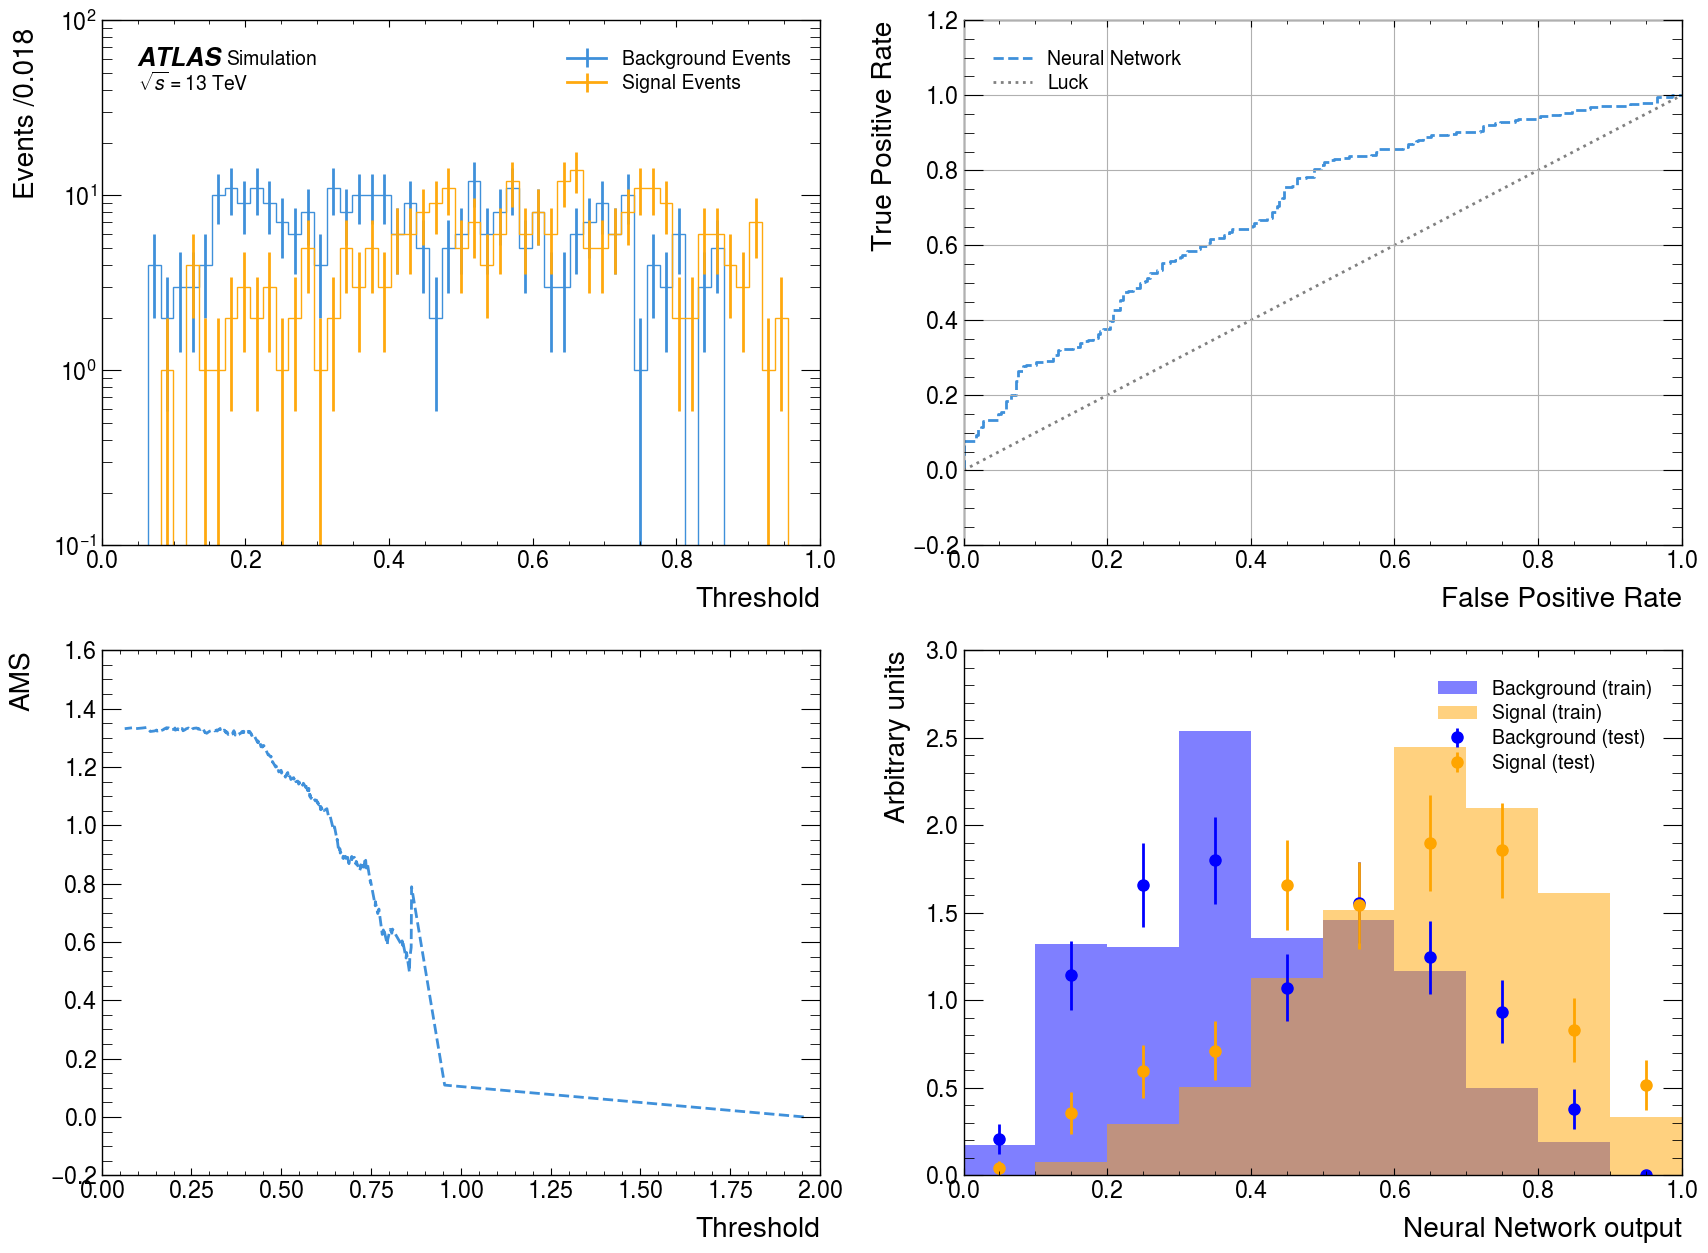

Accuracy Score: 0.6236
AUC Score: 0.692493
              precision    recall  f1-score   support

         0.0       0.67      0.59      0.62       289
         1.0       0.59      0.66      0.62       253

    accuracy                           0.62       542
   macro avg       0.63      0.63      0.62       542
weighted avg       0.63      0.62      0.62       542

Confusion Matrix: 
[[170 119]
 [ 85 168]]
Precision: 0.5854
Recall: 0.664
F1-Score: 0.6222
Area under the Precision-Recall Curve: 0.5455


In [449]:
fig, ax = plt.subplots(2,2, figsize=(20,15))
histogram([decisions_nn_reco_matched[y_test_reco_matched == 0],decisions_nn_reco_matched[y_test_reco_matched == 1]],50,['Background Events','Signal Events'],ax[0,0],ratio=False,x_units='')
ax[0,0].set_xlabel(r'Threshold')
ax[0,0].set_yscale('log')
ax[0,0].legend(loc='upper right')
ax[0,1].plot(fpr_nn_reco_matched, tpr_nn_reco_matched, linestyle="dashed", label="Neural Network")
ax[0,1].plot([0, 1], [0, 1], linestyle="dotted", color="grey", label="Luck")
ax[0,1].set_xlabel("False Positive Rate")
ax[0,1].set_ylabel("True Positive Rate")
ax[0,1].grid()
ax[0,1].legend()
ax[1,0].plot(thresholds_nn_reco_matched, ams_nn_reco_matched, linestyle="dashed", label="Neural Network")
ax[1,0].set_xlabel(r'Threshold')
ax[1,0].set_ylabel(r'AMS')
compare_train_test(NN_clf_reco_matched, X_train_scaled_reco_matched, y_train_reco_matched, X_test_scaled_reco_matched, y_test_reco_matched, "Neural Network output")
plt.show()
print(f"Accuracy Score: {accuracy_score(y_test_reco_matched, y_pred_NN_reco_matched):.4g}")
print(f"AUC Score: {auc_score_reco_matched:.6g}")
print(classification_report(y_test_reco_matched,y_pred_NN_reco_matched))
print(f"Confusion Matrix: \n{cm_reco_matched}")
print(f"Precision: {precision_reco_matched:.4g}")
print(f"Recall: {recall_reco_matched:.4g}")
print(f"F1-Score: {f1_reco_matched:.4g}")
print(f"Area under the Precision-Recall Curve: {auc_pr_reco_matched:.4g}")

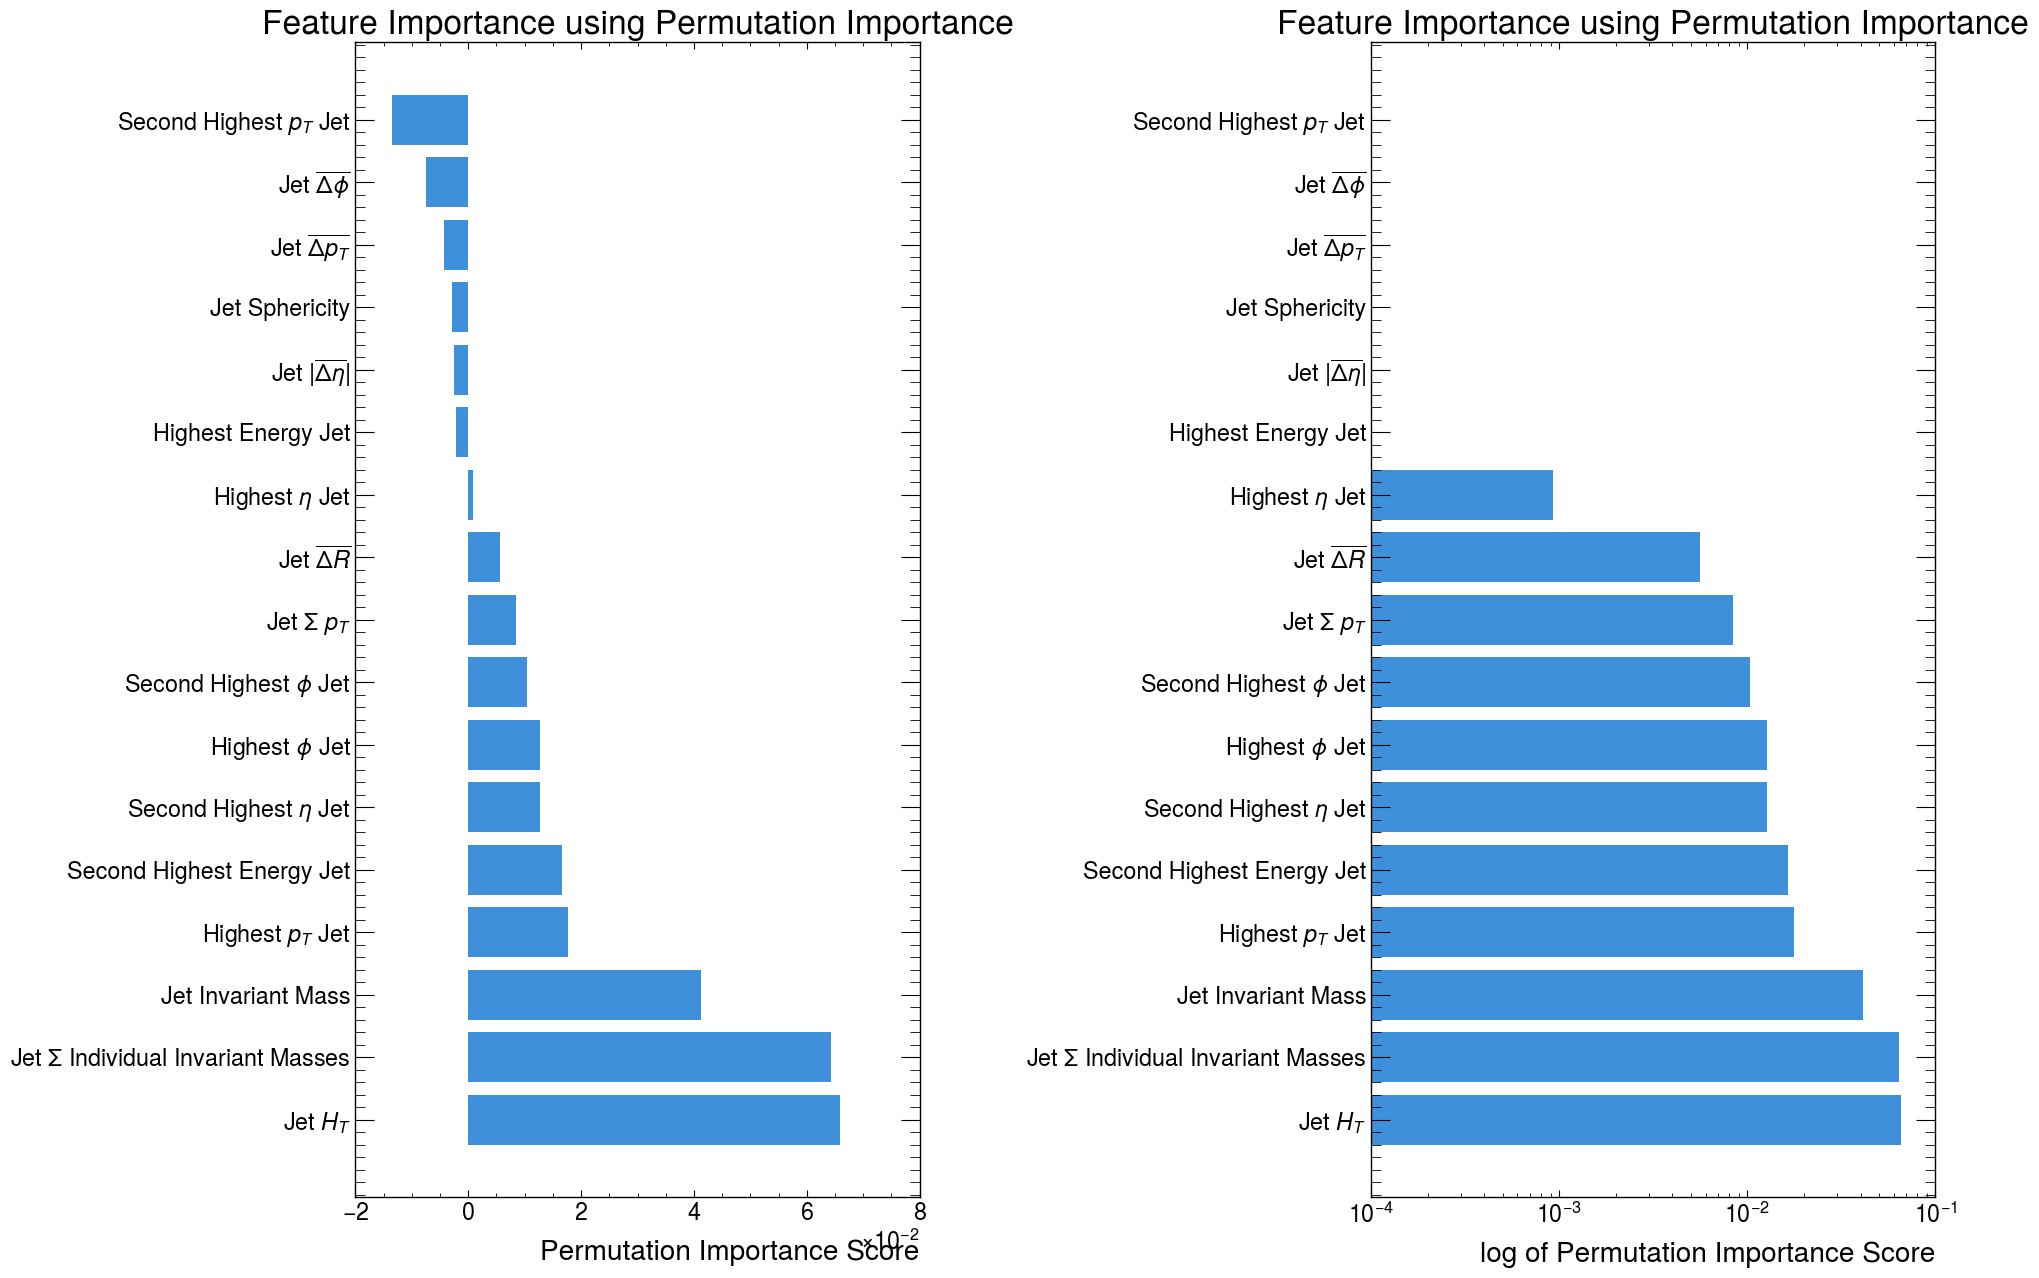

In [450]:
results_reco_matched = permutation_importance(NN_clf_reco_matched, X_test_tensor_reco_matched, y_test_tensor_reco_matched, n_repeats=30, random_state=42)
feature_names_reco_matched = variable_names_reco_reduced_matched

importance_scores_reco_matched = results_reco_matched.importances_mean

feature_importance_reco_matched = sorted(zip(importance_scores_reco_matched), reverse=True)

sorted_indices_reco_matched = np.argsort(importance_scores_reco_matched)[::-1]

sorted_importance_scores_reco_matched = importance_scores_reco_matched[sorted_indices_reco_matched]
sorted_feature_names_reco_matched = np.array(feature_names_reco_matched)[sorted_indices_reco_matched]
fig, ax = plt.subplots(1,2,figsize=(20, 15))
ax[0].barh(sorted_feature_names_reco_matched, sorted_importance_scores_reco_matched, align='center')
ax[0].set_xlabel('Permutation Importance Score')
ax[0].set_title('Feature Importance using Permutation Importance')

ax[1].barh(sorted_feature_names_reco_matched, sorted_importance_scores_reco_matched, align='center')
ax[1].set_xlabel('log of Permutation Importance Score')
ax[1].set_xscale('log')
ax[1].set_title('Feature Importance using Permutation Importance')
plt.subplots_adjust(wspace=0.8)
plt.show()

### Reco

In [60]:
X_reco = trans_combined_data_reco_reduced
y_reco = labels_reco

X_train_reco, X_test_reco, y_train_reco, y_test_reco = train_test_split(X_reco, y_reco, test_size=0.33, random_state=seed_value)

scaler = StandardScaler()
scaler.fit(X_train_reco)

X_train_scaled_reco = scaler.transform(X_train_reco)
X_test_scaled_reco = scaler.transform(X_test_reco)
X_scaled_reco = scaler.transform(X_reco)

KeyboardInterrupt: 

In [ ]:
epochs = 10  # number of training epochs
batch_size = 20  # number of samples per batch
input_size = len(X_reco[1])  # The number of features
num_classes = 2  # The number of output classes. In this case: [signal, background]
hidden_size = 32
hidden_size1 = 32  # The number of nodes at the first hidden layer
hidden_size2 = 32  # The number of nodes at the second hidden layer
dropout_rate = 0.2
learning_rate = 0.001  # The speed of convergence
verbose = True  # flag for printing out stats at each epoch

In [ ]:
X_train_tensor_reco = torch.as_tensor(X_train_scaled_reco, dtype=torch.float)  # make tensor from X_train_scaled
y_train_tensor_reco = torch.as_tensor(y_train_reco, dtype=torch.long)  # make tensor from y_train

X_train_var_reco, y_train_var_reco = Variable(X_train_tensor_reco), Variable(y_train_tensor_reco)  # make variables from tensors

X_valid_var_reco, y_valid_var_reco = (X_train_var_reco[:10000],y_train_var_reco[:10000],)  # get first 100 events for validation
X_train_nn_var_reco, y_train_nn_var_reco = (X_train_var_reco[10000:],y_train_var_reco[10000:],)  # get remaining events for training

train_data_reco = Data.TensorDataset(X_train_nn_var_reco, y_train_nn_var_reco)  # create training dataset
valid_data_reco = Data.TensorDataset(X_valid_var_reco, y_valid_var_reco)  # create validation dataset

train_loader_reco = Data.DataLoader(dataset=train_data_reco,batch_size=batch_size,shuffle=True,)
valid_loader_reco = Data.DataLoader(dataset=valid_data_reco,batch_size=batch_size,shuffle=True,)

In [ ]:
NN_clf_reco = Classifier_MLP(in_dim=input_size, hidden_dim1=hidden_size1, hidden_dim2=hidden_size2, dropout_rate=dropout_rate, out_dim=num_classes)
optimiser_reco = torch.optim.Adam(NN_clf_reco.parameters(), lr=learning_rate)
NN_clf_reco.fit(train_loader_reco,valid_loader_reco,optimiser_reco)

Epoch: 1, Train Loss: 0.590059
Validation Loss: 0.589756, Validation Accuracy: 0.685900
Epoch: 2, Train Loss: 0.587533
Validation Loss: 0.590382, Validation Accuracy: 0.682600
Epoch: 3, Train Loss: 0.586952
Validation Loss: 0.588659, Validation Accuracy: 0.684800
Epoch: 4, Train Loss: 0.586646
Validation Loss: 0.589742, Validation Accuracy: 0.686900
Epoch: 5, Train Loss: 0.586359
Validation Loss: 0.587781, Validation Accuracy: 0.686500
Epoch: 6, Train Loss: 0.586116
Validation Loss: 0.588329, Validation Accuracy: 0.685200
Epoch: 7, Train Loss: 0.585871
Validation Loss: 0.587293, Validation Accuracy: 0.684600
Epoch: 8, Train Loss: 0.585714
Validation Loss: 0.588615, Validation Accuracy: 0.681200
Epoch: 9, Train Loss: 0.585541
Validation Loss: 0.588839, Validation Accuracy: 0.687700
Epoch: 10, Train Loss: 0.585547
Validation Loss: 0.586762, Validation Accuracy: 0.685400
Finished Training
Final validation error:  31.46 %


In [ ]:
X_test_tensor_reco = torch.as_tensor(X_test_scaled_reco, dtype=torch.float)
y_test_tensor_reco = torch.as_tensor(y_test_reco, dtype=torch.long)

X_test_var_reco, y_test_var_reco = Variable(X_test_tensor_reco), Variable(y_test_tensor_reco)
out_reco, prob_reco = NN_clf_reco(X_test_var_reco)
y_pred_NN_reco = (prob_reco.cpu().detach().numpy().argmax(axis=1))

decisions_nn_reco = (NN_clf_reco(X_test_var_reco)[1][:, 1].cpu().detach().numpy())

fpr_nn_reco, tpr_nn_reco, thresholds_nn_reco = roc_curve(y_test_reco, decisions_nn_reco)

ams_nn_reco = AMS(tpr_nn_reco,fpr_nn_reco,b_reg)

auc_score_reco = roc_auc_score(y_test_reco,decisions_nn_reco)

cm_reco = confusion_matrix(y_test_reco, y_pred_NN_reco)
precision_reco = precision_score(y_test_reco, y_pred_NN_reco)
recall_reco = recall_score(y_test_reco, y_pred_NN_reco)
f1_reco = f1_score(y_test_reco, y_pred_NN_reco)
auc_pr_reco = average_precision_score(y_test_reco,y_pred_NN_reco)

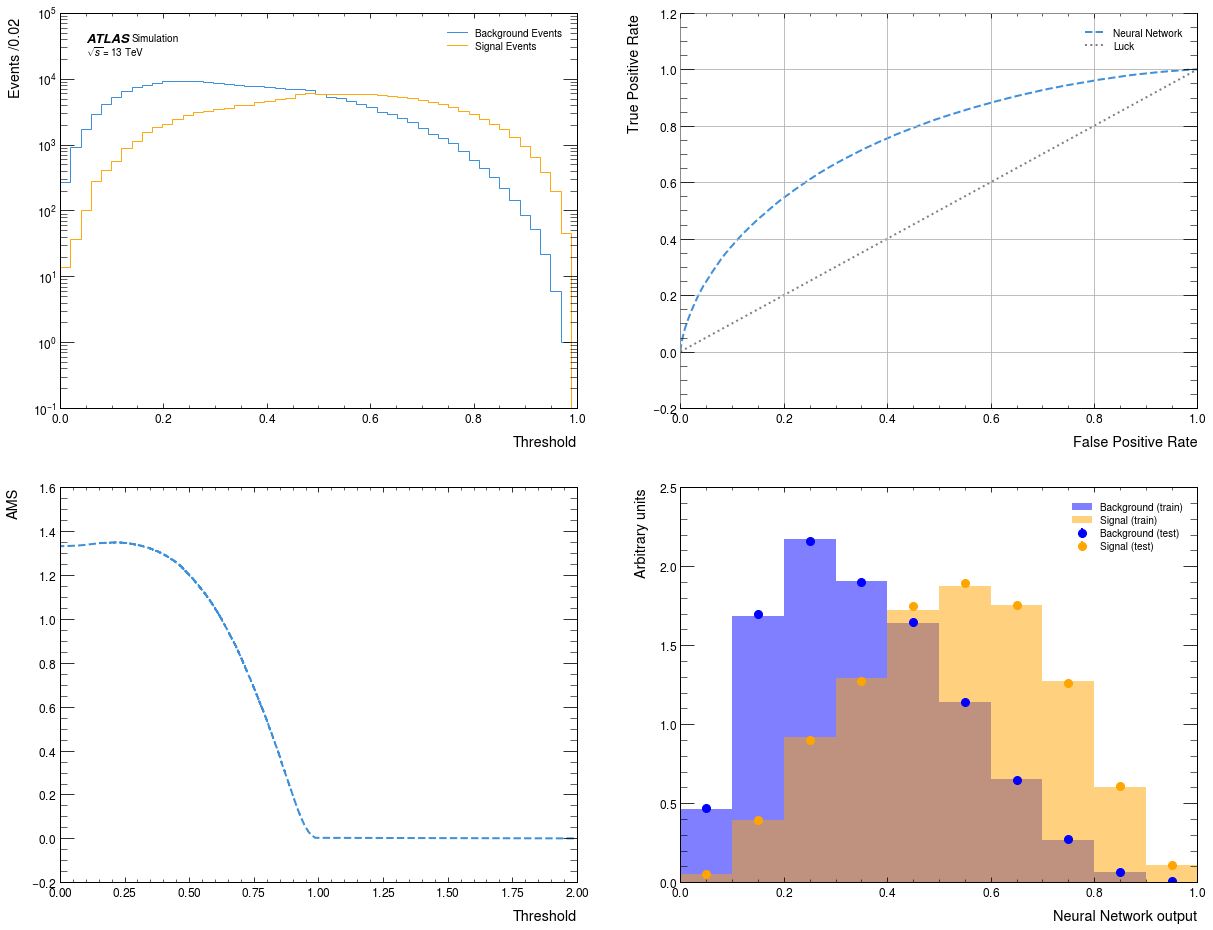

Accuracy Score: 0.6929
AUC Score: 0.748424
              precision    recall  f1-score   support

         0.0       0.71      0.79      0.75    215979
         1.0       0.66      0.56      0.61    156153

    accuracy                           0.69    372132
   macro avg       0.68      0.67      0.68    372132
weighted avg       0.69      0.69      0.69    372132

Confusion Matrix: 
[[169943  46036]
 [ 68263  87890]]
Precision: 0.6563
Recall: 0.5628
F1-Score: 0.606
Area under the Precision-Recall Curve: 0.5528


In [ ]:
fig, ax = plt.subplots(2,2, figsize=(20,15))
histogram([decisions_nn_reco[y_test_reco == 0],decisions_nn_reco[y_test_reco == 1]],50,['Background Events','Signal Events'],ax[0,0],ratio=False,x_units='')
ax[0,0].set_xlabel(r'Threshold')
ax[0,0].set_yscale('log')
ax[0,0].legend(loc='upper right')
ax[0,1].plot(fpr_nn_reco, tpr_nn_reco, linestyle="dashed", label="Neural Network")
ax[0,1].plot([0, 1], [0, 1], linestyle="dotted", color="grey", label="Luck")
ax[0,1].set_xlabel("False Positive Rate")
ax[0,1].set_ylabel("True Positive Rate")
ax[0,1].grid()
ax[0,1].legend()
ax[1,0].plot(thresholds_nn_reco, ams_nn_reco, linestyle="dashed", label="Neural Network")
ax[1,0].set_xlabel(r'Threshold')
ax[1,0].set_ylabel(r'AMS')
compare_train_test(NN_clf_reco, X_train_scaled_reco, y_train_reco, X_test_scaled_reco, y_test_reco, "Neural Network output")
plt.show()
print(f"Accuracy Score: {accuracy_score(y_test_reco, y_pred_NN_reco):.4g}")
print(f"AUC Score: {auc_score_reco:.6g}")
print(classification_report(y_test_reco,y_pred_NN_reco))
print(f"Confusion Matrix: \n{cm_reco}")
print(f"Precision: {precision_reco:.4g}")
print(f"Recall: {recall_reco:.4g}")
print(f"F1-Score: {f1_reco:.4g}")
print(f"Area under the Precision-Recall Curve: {auc_pr_reco:.4g}")

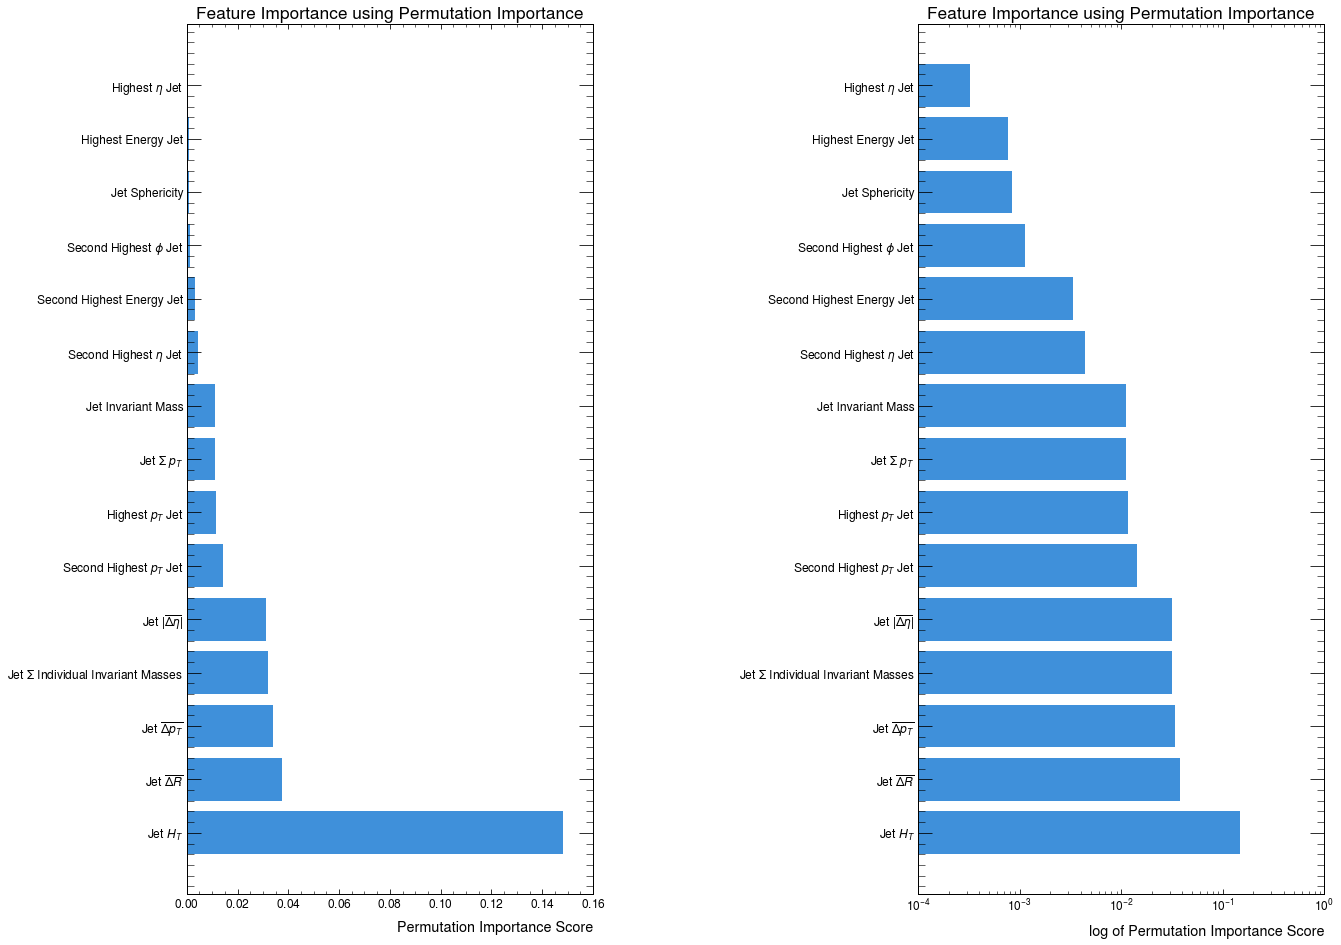

In [ ]:
results_reco = permutation_importance(NN_clf_reco, X_test_tensor_reco, y_test_tensor_reco, n_repeats=30, random_state=42)
feature_names_reco = variable_names_reco_reduced

importance_scores_reco = results_reco.importances_mean

feature_importance_reco = sorted(zip(importance_scores_reco), reverse=True)

sorted_indices_reco = np.argsort(importance_scores_reco)[::-1]

sorted_importance_scores_reco = importance_scores_reco[sorted_indices_reco]
sorted_feature_names_reco = np.array(feature_names_reco)[sorted_indices_reco]
fig, ax = plt.subplots(1,2,figsize=(20, 15))
ax[0].barh(sorted_feature_names_reco, sorted_importance_scores_reco, align='center')
ax[0].set_xlabel('Permutation Importance Score')
ax[0].set_title('Feature Importance using Permutation Importance')

ax[1].barh(sorted_feature_names_reco, sorted_importance_scores_reco, align='center')
ax[1].set_xlabel('log of Permutation Importance Score')
ax[1].set_xscale('log')
ax[1].set_title('Feature Importance using Permutation Importance')
plt.subplots_adjust(wspace=0.8)
plt.show()

### Partonic

In [ ]:
X_partonic = trans_partonic_data_reduced
y_partonic = labels_partonic
X_train_partonic, X_test_partonic, y_train_partonic, y_test_partonic = train_test_split(X_partonic, y_partonic, test_size=0.33, random_state=seed_value)
print(np.shape(X_partonic))
scaler = StandardScaler()
scaler.fit(X_train_partonic)

X_train_scaled_partonic = scaler.transform(X_train_partonic)
X_test_scaled_partonic = scaler.transform(X_test_partonic)
X_scaled_partonic = scaler.transform(X_partonic)

[10661, 18]


In [ ]:
epochs = 20  # number of training epochs
batch_size = 20  # number of samples per batch
input_size = len(X_partonic[1])  # The number of features
num_classes = 2  # The number of output classes. In this case: [signal, background]
hidden_size = 32
hidden_size1 = 32  # The number of nodes at the first hidden layer
hidden_size2 = 32  # The number of nodes at the second hidden layer
hidden_size3 = 64  # The number of nodes at the third hidden layer
dropout_rate = 0.2
learning_rate = 0.001  # The speed of convergence
verbose = True  # flag for printing out stats at each epoch

In [ ]:
X_train_tensor_partonic = torch.as_tensor(X_train_scaled_partonic, dtype=torch.float)  # make tensor from X_train_scaled
y_train_tensor_partonic = torch.as_tensor(y_train_partonic, dtype=torch.long)  # make tensor from y_train
print(np.shape(X_train_partonic))
X_train_var_partonic, y_train_var_partonic = Variable(X_train_tensor_partonic), Variable(y_train_tensor_partonic)  # make variables from tensors

X_valid_var_partonic, y_valid_var_partonic = (X_train_var_partonic[:1000],y_train_var_partonic[:1000],)  # get first 100 events for validation
X_train_nn_var_partonic, y_train_nn_var_partonic = (X_train_var_partonic[1000:],y_train_var_partonic[1000:],)  # get remaining events for training
print(np.shape(X_valid_var_partonic))
train_data_partonic = Data.TensorDataset(X_train_nn_var_partonic, y_train_nn_var_partonic)  # create training dataset
valid_data_partonic = Data.TensorDataset(X_valid_var_partonic, y_valid_var_partonic)  # create validation dataset
print(np.shape(train_data_partonic))
train_loader_partonic = Data.DataLoader(dataset=train_data_partonic,batch_size=batch_size,shuffle=True,)
valid_loader_partonic = Data.DataLoader(dataset=valid_data_partonic,batch_size=batch_size,shuffle=True,)

(7142, 18)
torch.Size([1000, 18])
(6142, 2)


c:\Users\matis\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:1970: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  result = asarray(a).shape
c:\Users\matis\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


In [ ]:
NN_clf_partonic = Classifier_MLP(in_dim=input_size, hidden_dim1=hidden_size1, hidden_dim2=hidden_size2, dropout_rate=dropout_rate, out_dim=num_classes)
optimiser_partonic = torch.optim.Adam(NN_clf_partonic.parameters(), lr=learning_rate)
NN_clf_partonic.fit(train_loader_partonic,valid_loader_partonic,optimiser_partonic)

Epoch: 1, Train Loss: 0.416452
Validation Loss: 0.196118, Validation Accuracy: 0.928000
Epoch: 2, Train Loss: 0.171827
Validation Loss: 0.117644, Validation Accuracy: 0.960000
Epoch: 3, Train Loss: 0.121941
Validation Loss: 0.081237, Validation Accuracy: 0.972000
Epoch: 4, Train Loss: 0.092339
Validation Loss: 0.061183, Validation Accuracy: 0.981000
Epoch: 5, Train Loss: 0.073656
Validation Loss: 0.056156, Validation Accuracy: 0.983000
Epoch: 6, Train Loss: 0.061911
Validation Loss: 0.043322, Validation Accuracy: 0.988000
Epoch: 7, Train Loss: 0.050245
Validation Loss: 0.036989, Validation Accuracy: 0.990000
Epoch: 8, Train Loss: 0.044243
Validation Loss: 0.036038, Validation Accuracy: 0.987000
Epoch: 9, Train Loss: 0.038302
Validation Loss: 0.035683, Validation Accuracy: 0.990000
Epoch: 10, Train Loss: 0.034935
Validation Loss: 0.042123, Validation Accuracy: 0.987000
Epoch: 11, Train Loss: 0.030819
Validation Loss: 0.028460, Validation Accuracy: 0.990000
Epoch: 12, Train Loss: 0.02816

In [ ]:
X_test_tensor_partonic = torch.as_tensor(X_test_scaled_partonic, dtype=torch.float)
y_test_tensor_partonic = torch.as_tensor(y_test_partonic, dtype=torch.long)

X_test_var_partonic, y_test_var_partonic = Variable(X_test_tensor_partonic), Variable(y_test_tensor_partonic)
out_partonic,prob_partonic = NN_clf_partonic(X_test_var_partonic)
y_pred_NN_partonic = (prob_partonic.cpu().detach().numpy().argmax(axis=1))

decisions_nn_partonic = (NN_clf_partonic(X_test_var_partonic)[1][:, 1].cpu().detach().numpy())

fpr_nn_partonic, tpr_nn_partonic, thresholds_nn_partonic = roc_curve(y_test_partonic, decisions_nn_partonic)

ams_nn_partonic = AMS(tpr_nn_partonic,fpr_nn_partonic,b_reg)

auc_score_partonic = roc_auc_score(y_test_partonic,decisions_nn_partonic)

cm_partonic = confusion_matrix(y_test_partonic, y_pred_NN_partonic)
precision_partonic = precision_score(y_test_partonic, y_pred_NN_partonic)
recall_partonic = recall_score(y_test_partonic, y_pred_NN_partonic)
f1_partonic = f1_score(y_test_partonic, y_pred_NN_partonic)
auc_pr_partonic = average_precision_score(y_test_partonic,y_pred_NN_partonic)

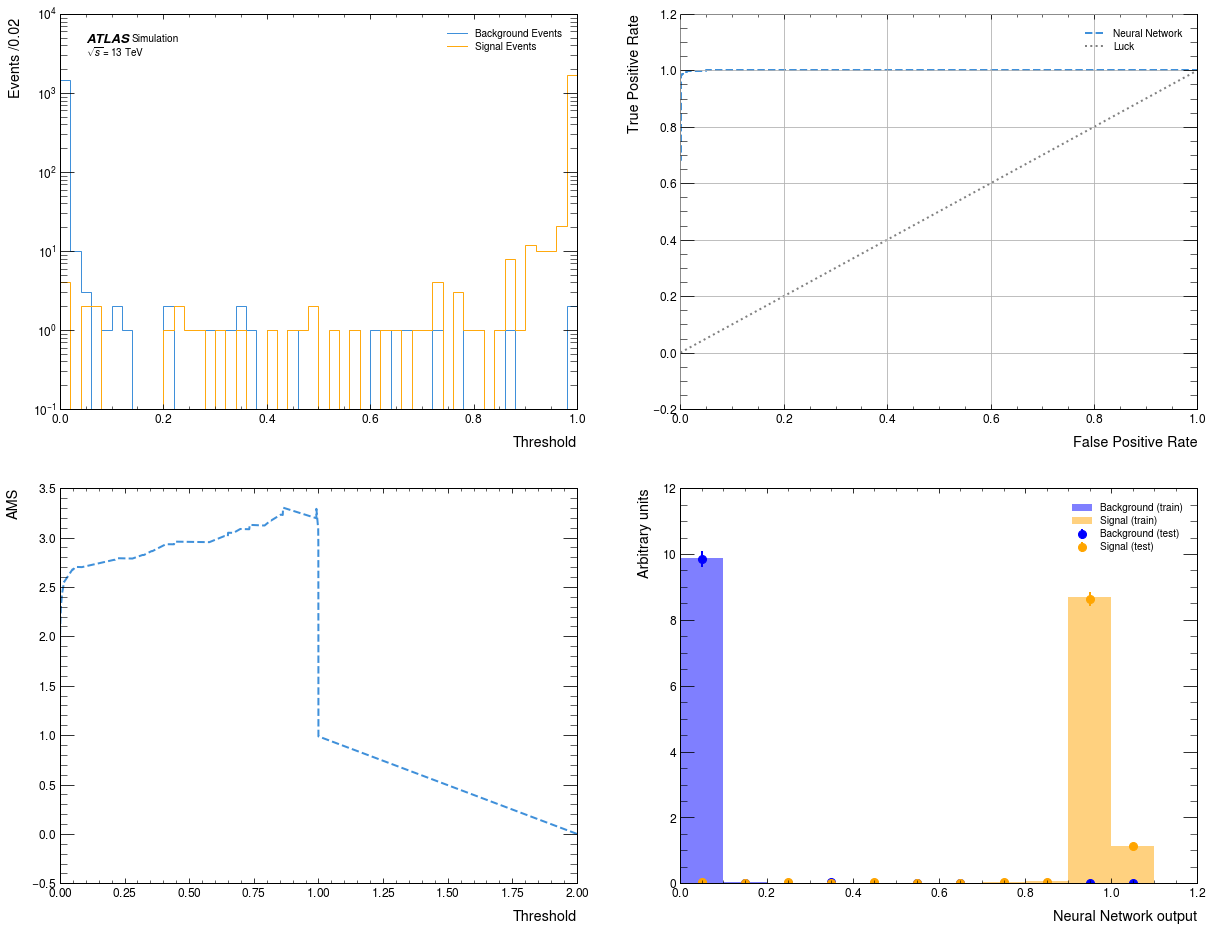

Accuracy Score: 0.991475
AUC Score: 0.99954
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      1505
         1.0       1.00      0.99      0.99      2014

    accuracy                           0.99      3519
   macro avg       0.99      0.99      0.99      3519
weighted avg       0.99      0.99      0.99      3519

Confusion Matrix: 
[[1495   10]
 [  20 1994]]
Precision: 0.995
Recall: 0.9901
F1-Score: 0.9925
Area under the Precision-Recall Curve: 0.9908


In [ ]:
fig, ax = plt.subplots(2,2, figsize=(20,15))
histogram([decisions_nn_partonic[y_test_partonic == 0],decisions_nn_partonic[y_test_partonic == 1]],50,['Background Events','Signal Events'],ax[0,0],ratio=False,x_units='')
ax[0,0].set_xlabel(r'Threshold')
ax[0,0].set_yscale('log')
ax[0,1].plot(fpr_nn_partonic, tpr_nn_partonic, linestyle="dashed", label="Neural Network")
ax[0,1].plot([0, 1], [0, 1], linestyle="dotted", color="grey", label="Luck")
ax[0,1].set_xlabel("False Positive Rate")
ax[0,1].set_ylabel("True Positive Rate")
ax[0,1].grid()
ax[0,1].legend()
ax[1,0].plot(thresholds_nn_partonic, ams_nn_partonic, linestyle="dashed", label="Neural Network")
ax[1,0].set_xlabel(r'Threshold')
ax[1,0].set_ylabel(r'AMS')
compare_train_test(NN_clf_partonic, X_train_scaled_partonic, y_train_partonic, X_test_scaled_partonic, y_test_partonic, "Neural Network output")
plt.show()
print(f"Accuracy Score: {accuracy_score(y_test_partonic, y_pred_NN_partonic):.6g}")
print(f"AUC Score: {auc_score_partonic:.6g}")
print(classification_report(y_test_partonic,y_pred_NN_partonic))
print(f"Confusion Matrix: \n{cm_partonic}")
print(f"Precision: {precision_partonic:.4g}")
print(f"Recall: {recall_partonic:.4g}")
print(f"F1-Score: {f1_partonic:.4g}")
print(f"Area under the Precision-Recall Curve: {auc_pr_partonic:.4g}")

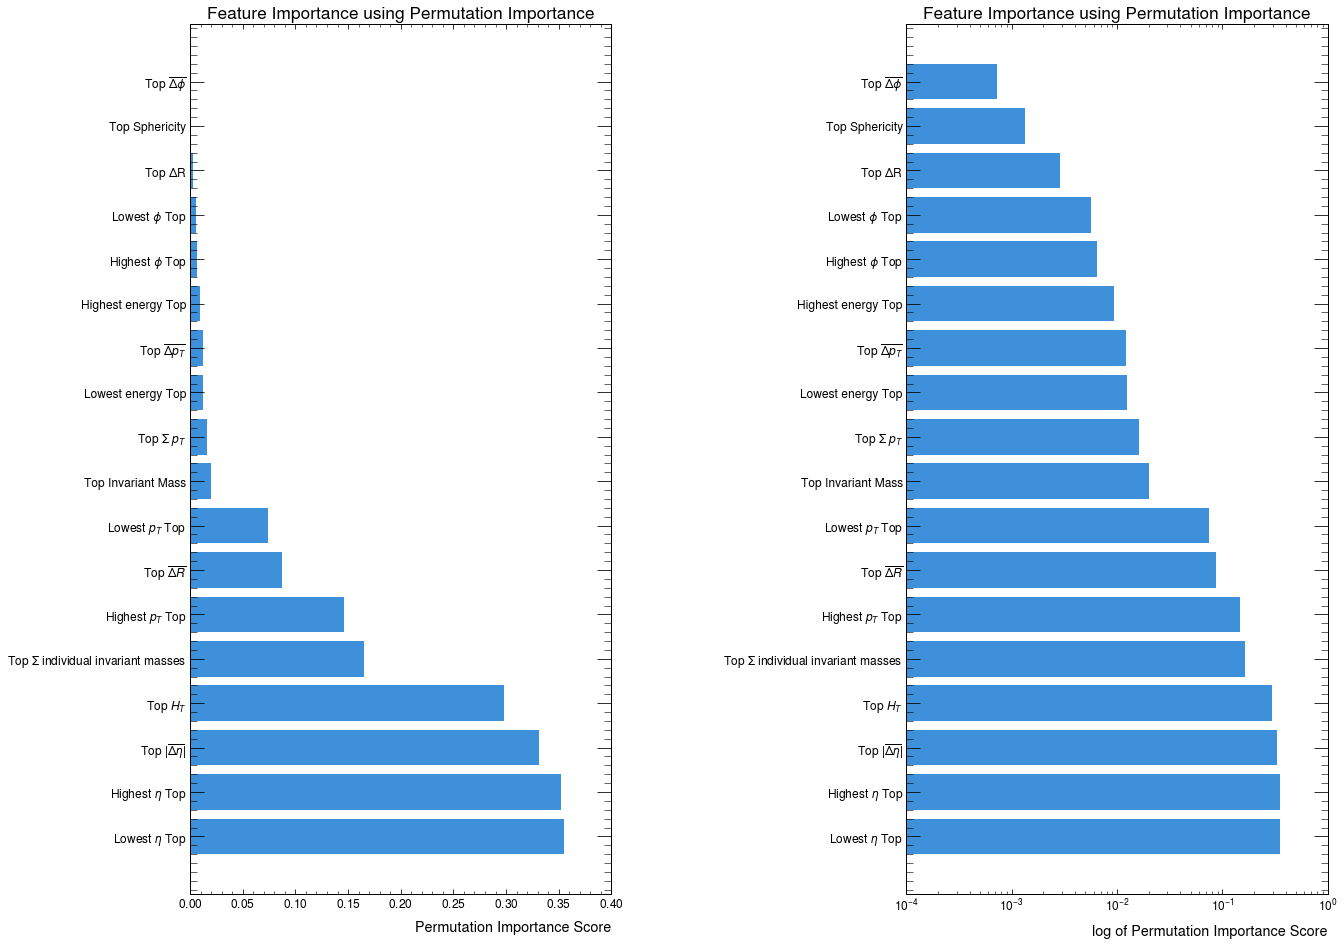

In [ ]:
results_partonic = permutation_importance(NN_clf_partonic, X_test_tensor_partonic, y_test_tensor_partonic, n_repeats=30, random_state=42)
feature_names_partonic = variable_names_partonic_reduced

importance_scores_partonic = results_partonic.importances_mean

feature_importance_partonic = sorted(zip(importance_scores_partonic), reverse=True)

sorted_indices_partonic = np.argsort(importance_scores_partonic)[::-1]

sorted_importance_scores_partonic = importance_scores_partonic[sorted_indices_partonic]
sorted_feature_names_partonic = np.array(feature_names_partonic)[sorted_indices_partonic]

fig, ax = plt.subplots(1,2,figsize=(20, 15))
ax[0].barh(sorted_feature_names_partonic, sorted_importance_scores_partonic, align='center')
ax[0].set_xlabel('Permutation Importance Score')
ax[0].set_title('Feature Importance using Permutation Importance')

ax[1].barh(sorted_feature_names_partonic, sorted_importance_scores_partonic, align='center')
ax[1].set_xlabel('log of Permutation Importance Score')
ax[1].set_xscale('log')
ax[1].set_title('Feature Importance using Permutation Importance')
plt.subplots_adjust(wspace=0.7)
plt.show()